# EDA mit Python & dynamische Visualisierung in Tableau 
# am Beispiel der Ergast F1-Datenbank


# Ziel des Projekts

Das Ziel dieses Projekts ist die explorative Analyse historischer Formel-1-Daten mit modernen Data Science-Methoden. 

Dabei werden verschiedene Aspekte der Datenaufbereitung, Analyse und Visualisierung kombiniert, 
um explorative Analysen dynamisch in einem Visualisierungstool wie z.B. Tableau zu ermöglichen.


## Vorgehen

- **Datenbereinigung:** Korrektur von fehlerhaften oder fehlenden Werten (z. B. inkonsistente Werte, leere Felder, deutsche Wikipedia-URLs).
- **Datenintegration:** Aufbau einer SQL-Datenbank für die Analyse.
- **Explorative Datenanalyse (EDA):** Untersuchung spezifischer Fragestellungen durch statistische Auswertung und Visualisierung in Python.
- **Erstellung eines DataFrames:** Erzeugung einer CSV mit den nötigen Feldern und Berechnungen zur visuellen Darstellung in Tableau.
- **Visualisierung in Tableau:** Dynamisierte Analyse der Beispiele.

## Wahl der Datenquelle – Warum Ergast?

### Was ist Ergast?
- Ergast ist eine öffentlich zugängliche Motorsport-Datenbank mit historischen Formel-1-Renndaten.
- Bereitstellung als API und als vollständige SQL-Datenbank.
- Weitere Informationen: [Ergast API](https://ergast.com/mrd/)

### Vorteile von Ergast
- **Vollständigkeit:** Ergast enthält detaillierte historische Renndaten zu Fahrern, Teams, Rennen und Ergebnissen.
- **Datenstruktur:** Die Daten sind in relationalen Tabellen organisiert und gut für SQL-basierte Analysen geeignet.
- **Konsistenz & Verfügbarkeit:** Die Ergast-Datenbank wird regelmäßig aktualisiert und bietet eine konsistente Struktur.
- **Zukünftige Entwicklung:** Die aktuelle Ergast-Datenbank wird in absehbarer Zeit durch eine neue Version ersetzt.

### Alternative Quellen
- **FIA & F1-Statistikseiten:** Oft eingeschränkter Zugang oder proprietäre Formate.
- **Kaggle & andere Daten-Repositories:** Häufig nicht aktuell oder unvollständig.
- **Eigene Web-Scraping-Methoden:** Hoher Wartungsaufwand und potenzielle rechtliche Einschränkungen.



## Datenbasis

- **Quelle:** Ergast Formula 1 Database
- **Datenformat:** CSV-Dateien
- **Struktur:** Historische Renndaten (Fahrer, Teams, Rennen, Ergebnisse)
- **Verarbeitung:** Python & SQLite für Bereinigung und Berechnung

### Umgebung
- **Datenverarbeitung:** pandas, numpy, sqlite3
- **Visualisierung:** matplotlib, seaborn
- **Dateiverwaltung & Verarbeitung:** os, zipfile, PIL
- **Notebook-Darstellung:** IPython.display
- Eventuell fehlende Bibliotheken ergänzen mit `pip install <bibliothek>`.
- **Visualisierung:** Tableau Public


In [1]:
# bibliotheken installieren (falls noch nicht vorhanden) - einmalig ausführen
# !pip install pandas matplotlib seaborn ##graphviz obsolet

# bibliotheken importieren
import pandas as pd  # datenverarbeitung
import numpy as np  # numerische berechnungen
import matplotlib.pyplot as plt  # visualisierungen
import seaborn as sns  # erweiterte visualisierungen
import os  # dateiverwaltung
import zipfile  # entpacken von zip-dateien
import sqlite3 #für die felderrechnerei
#import graphviz  # darstellung des erd  ##obsolet
from IPython.display import display
from PIL import Image


# pandas-einstellung ändern, damit lange strings nicht abgeschnitten werden (s.u.:url's)
pd.set_option("display.max_colwidth", None)

## Datenverarbeitung & Bereinigung

### ZIP-Archiv herunterladen & entpacken
- Die Ergast-Datenbank wird als ZIP-Archiv bereitgestellt und enthält 14 CSV-Dateien.
- Diese werden in das Arbeitsverzeichnis entpackt und strukturiert überprüft.

### Überprüfung der Tabellenstruktur
- Sicherstellen, dass alle Tabellen vollständig sind und die definierten Spalten enthalten.
- Prüfung der Schlüsselbeziehungen (Primär- & Fremdschlüssel) zur Sicherstellung korrekter Verknüpfungen.

In [2]:
import requests
import zipfile
import os
# Hallo Trainer: da ich bereits bereingte CSV's als f1db.zip mitgeliefert habe: falls ihr die benutzt, wird natürlich nichts
# mehr gefunden oder bereinigt. -> für den fall:
# -> zgt ist zelle redundant zu zelle unten, aber nur so läuft es bei meinen limierten kenntnissen in jeder konstellation 
# (on /off, zip schon da, schon entpackt/CSVs schon da/schon bereinigt?), auch immer richtig durch.
# pfade definieren
zip_url = "https://ergast.com/downloads/f1db_csv.zip"
zip_path = "f1db_csv.zip"
extract_path = "f1db"

# zip-datei herunterladen, falls sie nicht existiert
if not os.path.exists(zip_path):
    print("Lade das Ergast ZIP-Archiv herunter...")
    response = requests.get(zip_url, stream=True)
    if response.status_code == 200:
        with open(zip_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
    else:
        raise Exception(f"Fehler beim Herunterladen der ZIP-Datei! Status Code: {response.status_code}")

# zip-datei entpacken, falls sie noch nicht entpackt wurde
if not os.path.exists(extract_path):
    print("Entpacke das Archiv...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)

# entpackte dateien auflisten
csv_files = [f for f in os.listdir(extract_path) if f.endswith(".csv")]
print("Entpackte Dateien:", csv_files)


Entpacke das Archiv...
Entpackte Dateien: ['circuits.csv', 'constructors.csv', 'constructor_results.csv', 'constructor_standings.csv', 'drivers.csv', 'driver_standings.csv', 'lap_times.csv', 'pit_stops.csv', 'qualifying.csv', 'races.csv', 'results.csv', 'seasons.csv', 'sprint_results.csv', 'status.csv']


In [3]:
# s.o.
# noch mal: zip archiv von ergast herunterladen und entpacken
# url der ergast zip-datei
url = "https://ergast.com/downloads/f1db_csv.zip"

# speicherort der datei im projektverzeichnis
zip_path = "f1db_csv.zip"
extract_path = "f1db"  # verzeichnis, in das entpackt wird

# datei herunterladen
print("lade das ergast zip-archiv herunter...")
response = requests.get(url)

if response.status_code == 200:
    with open(zip_path, "wb") as file:
        file.write(response.content)

    print("entpacke das archiv...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)

    print("daten heruntergeladen und entpackt.")
else:
    print(f"Fehler beim Herunterladen der zip-datei. status code: {response.status_code}")

lade das ergast zip-archiv herunter...
entpacke das archiv...
daten heruntergeladen und entpackt.


## Überblick über die entpackten Daten

Die entpackte Ergast-Datenbank enthält insgesamt 14 CSV-Dateien, die verschiedene Aspekte der Formel-1-Historie abbilden. Hier ein Überblick:

### Saison & Rennen
- `seasons.csv` → Liste aller F1-Saisons mit zugehörigen Wikipedia-Links
- `races.csv` → Details zu allen Rennen (Jahr, Strecke, Datum, Uhrzeit, etc.)

### Fahrer & Teams
- `drivers.csv` → Fahrerinformationen (Name, Nationalität, Geburtsdatum, Fahrer-Code)
- `constructors.csv` → Teams & Konstrukteure (Name, Nationalität, Team-ID)

### Rennergebnisse & Stände
- `results.csv` → Ergebnisse aller Rennen (Platzierung, Punkte, schnellste Runden, Status)
- `driver_standings.csv` → Punktestände der Fahrer im Saisonverlauf
- `constructor_standings.csv` → Punktestände der Konstrukteure im Saisonverlauf

### Qualifying & Sprint
- `qualifying.csv` → Ergebnisse der Qualifying-Sessions (Q1, Q2, Q3-Zeiten)
- `sprint_results.csv` → Ergebnisse der Sprint-Rennen

### Rundenzeiten, Boxenstopps & Status
- `lap_times.csv` → Detaillierte Rundenzeiten pro Fahrer & Rennen
- `pit_stops.csv` → Boxenstopps aller Rennen (Runde, Zeit, Dauer)
- `status.csv` → Übersicht möglicher Renn-Endzustände (z. B. "Finished", "Accident", "Engine Failure")

### Sonstiges
- `circuits.csv` → Streckeninformationen (Name, Standort, Geodaten)
- `constructor_results.csv` → Konstrukteurswertung pro Rennen (Punkte)

Diese Datenstruktur entspricht dem relationalen Modell, das wir später in Tableau visualisieren und für unsere Analysen nutzen werden.

## Entity-Relationship-Diagramm (ERD)

- Ergast ist eine sehr benutzerfreundliche API und stellt ein ERD der Tabellenstruktur und ihrer Beziehungen zur Verfügung.
- Zeigt, wie Fahrer, Teams, Rennen und Ergebnisse miteinander verknüpft sind.


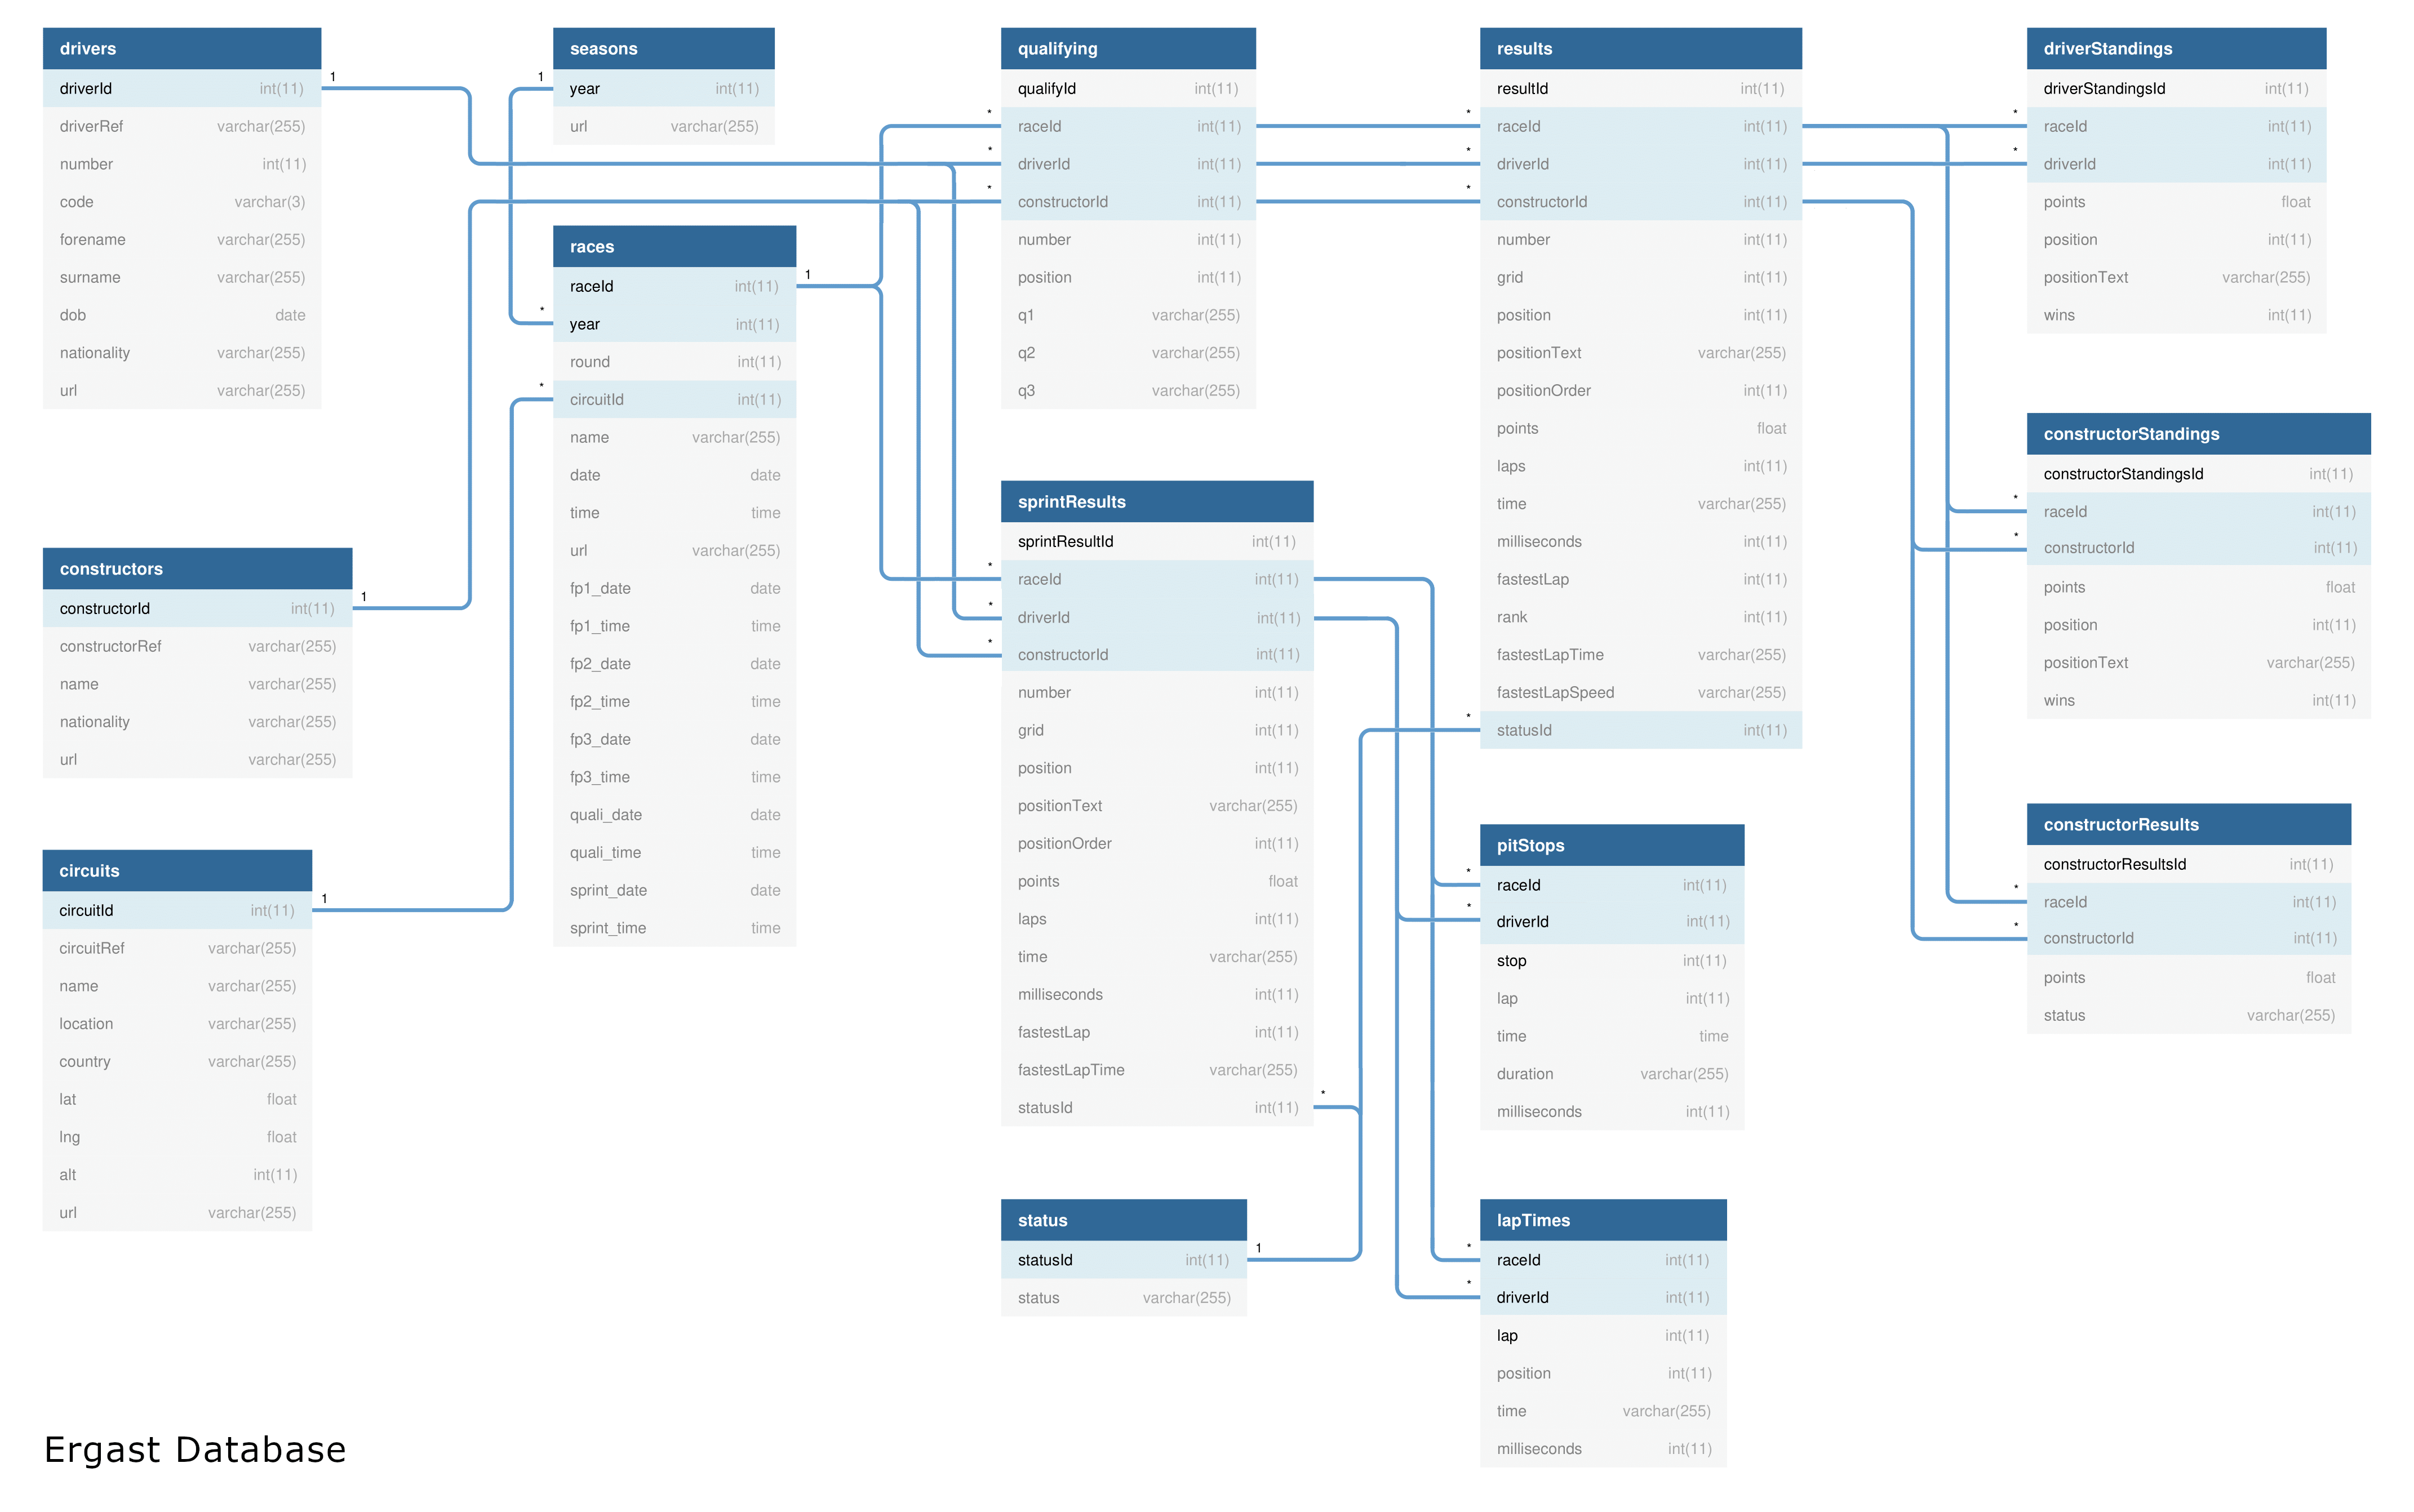

In [4]:
from IPython.display import display
from PIL import Image

# pfad zur erd-grafik
erd_path = "docs/ergast_db.png"

# bild anzeigen
img = Image.open(erd_path)
display(img)


## Datenqualität & erste Prüfung

- Identifikation fehlender Werte
- Überprüfung auf inkonsistente oder fehlerhafte Einträge
- Erste statistische Analysen


In [5]:
# alle csv-dateien im verzeichnis einlesen und deren spalten ausgeben
filecheck = {file: pd.read_csv(f"f1db/{file}") for file in os.listdir("f1db") if file.endswith(".csv")}

# ausgabe der tabellennamen und zugehörigen spalten
for file, df in filecheck.items():
    print(f"\n--- {file} ---")
    print(df.columns.tolist())  # liste der spalten ausgeben



--- circuits.csv ---
['circuitId', 'circuitRef', 'name', 'location', 'country', 'lat', 'lng', 'alt', 'url']

--- constructors.csv ---
['constructorId', 'constructorRef', 'name', 'nationality', 'url']

--- constructor_results.csv ---
['constructorResultsId', 'raceId', 'constructorId', 'points', 'status']

--- constructor_standings.csv ---
['constructorStandingsId', 'raceId', 'constructorId', 'points', 'position', 'positionText', 'wins']

--- drivers.csv ---
['driverId', 'driverRef', 'number', 'code', 'forename', 'surname', 'dob', 'nationality', 'url']

--- driver_standings.csv ---
['driverStandingsId', 'raceId', 'driverId', 'points', 'position', 'positionText', 'wins']

--- lap_times.csv ---
['raceId', 'driverId', 'lap', 'position', 'time', 'milliseconds']

--- pit_stops.csv ---
['raceId', 'driverId', 'stop', 'lap', 'time', 'duration', 'milliseconds']

--- qualifying.csv ---
['qualifyId', 'raceId', 'driverId', 'constructorId', 'number', 'position', 'q1', 'q2', 'q3']

--- races.csv ---


In [6]:
# alle csv-dateien im verzeichnis einlesen und deren spalten ausgeben
filecheck = {file: pd.read_csv(f"f1db/{file}") for file in os.listdir("f1db") if file.endswith(".csv")}

# ausgabe der spalten mit datentypen
for file, df in filecheck.items():
    print(f"\n--- {file} ---")
    print(df.info())  # liste der spalten ausgeben


--- circuits.csv ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   circuitId   77 non-null     int64  
 1   circuitRef  77 non-null     object 
 2   name        77 non-null     object 
 3   location    77 non-null     object 
 4   country     77 non-null     object 
 5   lat         77 non-null     float64
 6   lng         77 non-null     float64
 7   alt         77 non-null     int64  
 8   url         77 non-null     object 
dtypes: float64(2), int64(2), object(5)
memory usage: 5.5+ KB
None

--- constructors.csv ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   constructorId   212 non-null    int64 
 1   constructorRef  212 non-null    object
 2   name            212 non-null    object
 3   nat

### Überprüfung der Tabellenstruktur

**Checkpoints**  
- **Primär- und Fremdschlüssel:** Stimmen die Schlüsselspalten mit den erwarteten Beziehungen überein?  
- **Datenintegrität:** Enthält jede Fremdschlüssel-Spalte nur Werte, die in der referenzierten Tabelle existieren?  
- **Fehlende oder unerwartete Spalten:** Gibt es Abweichungen von der dokumentierten Struktur?  


In [7]:
# erwartete primärschlüssel pro tabelle
primary_keys = {
    "circuits.csv": "circuitId",
    "constructors.csv": "constructorId",
    "drivers.csv": "driverId",
    "races.csv": "raceId",
    "results.csv": "resultId",
    "qualifying.csv": "qualifyId",
    "pit_stops.csv": ["raceId", "driverId", "stop"],  # zusammengesetzter schlüssel
    "lap_times.csv": ["raceId", "driverId", "lap"],  # zusammengesetzter schlüssel
    "constructor_results.csv": "constructorResultsId",
    "constructor_standings.csv": "constructorStandingsId",
    "driver_standings.csv": "driverStandingsId",
    "status.csv": "statusId"
}

# prüfen, ob die primärschlüssel in den daten wirklich eindeutig
for file, key in primary_keys.items():
    df = filecheck[file]  # entsprechende datei laden
    if isinstance(key, list):  # falls zusammengesetzter schlüssel
        is_unique = not df.duplicated(subset=key).any()
    else:
        is_unique = df[key].is_unique

    print(f"{file}: {'Eindeutig' if is_unique else 'Nicht eindeutig!'}")


circuits.csv: Eindeutig
constructors.csv: Eindeutig
drivers.csv: Eindeutig
races.csv: Eindeutig
results.csv: Eindeutig
qualifying.csv: Eindeutig
pit_stops.csv: Eindeutig
lap_times.csv: Eindeutig
constructor_results.csv: Eindeutig
constructor_standings.csv: Eindeutig
driver_standings.csv: Eindeutig
status.csv: Eindeutig


In [8]:
# untersuchen der datenbank-struktur: primär- und fremdschlüssel
# primärschlüssel sind eindeutig, fremdschlüssel verweisen auf andere tabellen

# mögliche primärschlüssel identifizieren (erste spalte jeder tabelle)
primary_keys = {file: df.columns[0] for file, df in filecheck.items()}

# mögliche fremdschlüssel identifizieren (spalten, die in anderen tabellen als primärschlüssel existieren)
foreign_keys = {}

for file, df in filecheck.items():
    for col in df.columns:
        for other_file, other_df in filecheck.items():
            if file != other_file and col in other_df.columns:
                if file not in foreign_keys:
                    foreign_keys[file] = []
                foreign_keys[file].append((col, other_file))

# ausgabe der primärschlüssel pro tabelle
print("Primärschlüssel pro Tabelle:")
for table, pk in primary_keys.items():
    print(f"- {table}: {pk}")

# ausgabe der fremdschlüssel-verweise
print("\nFremdschlüssel-Verweise:")
for table, refs in foreign_keys.items():
    print(f"- {table}:")
    for fk, ref_table in refs:
        print(f"  → {fk} referenziert {ref_table}")


Primärschlüssel pro Tabelle:
- circuits.csv: circuitId
- constructors.csv: constructorId
- constructor_results.csv: constructorResultsId
- constructor_standings.csv: constructorStandingsId
- drivers.csv: driverId
- driver_standings.csv: driverStandingsId
- lap_times.csv: raceId
- pit_stops.csv: raceId
- qualifying.csv: qualifyId
- races.csv: raceId
- results.csv: resultId
- seasons.csv: year
- sprint_results.csv: resultId
- status.csv: statusId

Fremdschlüssel-Verweise:
- circuits.csv:
  → circuitId referenziert races.csv
  → name referenziert constructors.csv
  → name referenziert races.csv
  → url referenziert constructors.csv
  → url referenziert drivers.csv
  → url referenziert races.csv
  → url referenziert seasons.csv
- constructors.csv:
  → constructorId referenziert constructor_results.csv
  → constructorId referenziert constructor_standings.csv
  → constructorId referenziert qualifying.csv
  → constructorId referenziert results.csv
  → constructorId referenziert sprint_results

In [9]:
# mapping für sonderfälle, damit tabellennamen korrekt sind
table_mapping = {
    "statusId": "status.csv",
    "constructorResultsId": "constructor_results.csv",
    "constructorStandingsId": "constructor_standings.csv",
    "driverStandingsId": "driver_standings.csv",
    "qualifyId": "qualifying.csv"
}

# überprüfung der fremdschlüssel
issues_found = False  # flag für probleme

for table, df in filecheck.items():
    for col in df.columns:
        if col.endswith("Id") and col != "resultId":  # nur typische fremdschlüssel prüfen
            
            # sonderfälle aus table_mapping nehmen, sonst standardregel anwenden
            ref_table = table_mapping.get(col, col.replace("Id", "s.csv"))

            if ref_table in filecheck:
                valid_refs = filecheck[ref_table][col]  # alle gültigen ids holen
                missing = df.loc[~df[col].isin(valid_refs), col]  # fehlende ids finden

                if not missing.empty:
                    print(f"Fehlende Fremdschlüssel in {table}, Spalte {col}: {missing.unique()}")
                    issues_found = True  

# falls keine probleme → bestätigung ausgeben
if not issues_found:
    print("Alle Fremdschlüssel sind korrekt verknüpft.")


Alle Fremdschlüssel sind korrekt verknüpft.


## Datenqualität & erste Prüfung

- Identifikation fehlender Werte
- Überprüfung auf inkonsistente oder fehlerhafte Einträge
- Erste statistische Analysen

In [10]:
# alle dateien einlesen und head anzeigen
for file, df in filecheck.items():
    print(f"\n--- {file} ---")
    display(df.head())  # display für schönere formatierung in jupyter


--- circuits.csv ---


circuitId   circuitRef                            name      location  \
0          1  albert_park  Albert Park Grand Prix Circuit     Melbourne   
1          2       sepang    Sepang International Circuit  Kuala Lumpur   
2          3      bahrain   Bahrain International Circuit        Sakhir   
3          4    catalunya  Circuit de Barcelona-Catalunya      Montmeló   
4          5     istanbul                   Istanbul Park      Istanbul   

     country       lat        lng  alt  \
0  Australia -37.84970  144.96800   10   
1   Malaysia   2.76083  101.73800   18   
2    Bahrain  26.03250   50.51060    7   
3      Spain  41.57000    2.26111  109   
4     Turkey  40.95170   29.40500  130   

                                                           url  
0    http://en.wikipedia.org/wiki/Melbourne_Grand_Prix_Circuit  
1    http://en.wikipedia.org/wiki/Sepang_International_Circuit  
2   http://en.wikipedia.org/wiki/Bahrain_International_Circuit  
3  http://en.wikipedia.org/wiki/Circuit_de_Barcelona-Catalunya  
4                   http://en.wikipedia.org/wiki/Istanbul_Park


--- constructors.csv ---


constructorId constructorRef        name nationality  \
0              1        mclaren     McLaren     British   
1              2     bmw_sauber  BMW Sauber      German   
2              3       williams    Williams     British   
3              4        renault     Renault      French   
4              5     toro_rosso  Toro Rosso     Italian   

                                                            url  
0                          http://en.wikipedia.org/wiki/McLaren  
1                       http://en.wikipedia.org/wiki/BMW_Sauber  
2  http://en.wikipedia.org/wiki/Williams_Grand_Prix_Engineering  
3           http://en.wikipedia.org/wiki/Renault_in_Formula_One  
4              http://en.wikipedia.org/wiki/Scuderia_Toro_Rosso


--- constructor_results.csv ---


constructorResultsId  raceId  constructorId  points status
0                     1      18              1    14.0     \N
1                     2      18              2     8.0     \N
2                     3      18              3     9.0     \N
3                     4      18              4     5.0     \N
4                     5      18              5     2.0     \N


--- constructor_standings.csv ---


constructorStandingsId  raceId  constructorId  points  position  \
0                       1      18              1    14.0         1   
1                       2      18              2     8.0         3   
2                       3      18              3     9.0         2   
3                       4      18              4     5.0         4   
4                       5      18              5     2.0         5   

  positionText  wins  
0            1     1  
1            3     0  
2            2     0  
3            4     0  
4            5     0


--- drivers.csv ---


driverId   driverRef number code  forename     surname         dob  \
0         1    hamilton     44  HAM     Lewis    Hamilton  1985-01-07   
1         2    heidfeld     \N  HEI      Nick    Heidfeld  1977-05-10   
2         3     rosberg      6  ROS      Nico     Rosberg  1985-06-27   
3         4      alonso     14  ALO  Fernando      Alonso  1981-07-29   
4         5  kovalainen     \N  KOV    Heikki  Kovalainen  1981-10-19   

  nationality                                             url  
0     British     http://en.wikipedia.org/wiki/Lewis_Hamilton  
1      German      http://en.wikipedia.org/wiki/Nick_Heidfeld  
2      German       http://en.wikipedia.org/wiki/Nico_Rosberg  
3     Spanish    http://en.wikipedia.org/wiki/Fernando_Alonso  
4     Finnish  http://en.wikipedia.org/wiki/Heikki_Kovalainen


--- driver_standings.csv ---


driverStandingsId  raceId  driverId  points  position positionText  wins
0                  1      18         1    10.0         1            1     1
1                  2      18         2     8.0         2            2     0
2                  3      18         3     6.0         3            3     0
3                  4      18         4     5.0         4            4     0
4                  5      18         5     4.0         5            5     0


--- lap_times.csv ---


raceId  driverId  lap  position      time  milliseconds
0     841        20    1         1  1:38.109         98109
1     841        20    2         1  1:33.006         93006
2     841        20    3         1  1:32.713         92713
3     841        20    4         1  1:32.803         92803
4     841        20    5         1  1:32.342         92342


--- pit_stops.csv ---


raceId  driverId  stop  lap      time duration  milliseconds
0     841       153     1    1  17:05:23   26.898         26898
1     841        30     1    1  17:05:52   25.021         25021
2     841        17     1   11  17:20:48   23.426         23426
3     841         4     1   12  17:22:34   23.251         23251
4     841        13     1   13  17:24:10   23.842         23842


--- qualifying.csv ---


qualifyId  raceId  driverId  constructorId  number  position        q1  \
0          1      18         1              1      22         1  1:26.572   
1          2      18         9              2       4         2  1:26.103   
2          3      18         5              1      23         3  1:25.664   
3          4      18        13              6       2         4  1:25.994   
4          5      18         2              2       3         5  1:25.960   

         q2        q3  
0  1:25.187  1:26.714  
1  1:25.315  1:26.869  
2  1:25.452  1:27.079  
3  1:25.691  1:27.178  
4  1:25.518  1:27.236


--- races.csv ---


raceId  year  round  circuitId                   name        date  \
0       1  2009      1          1  Australian Grand Prix  2009-03-29   
1       2  2009      2          2   Malaysian Grand Prix  2009-04-05   
2       3  2009      3         17     Chinese Grand Prix  2009-04-19   
3       4  2009      4          3     Bahrain Grand Prix  2009-04-26   
4       5  2009      5          4     Spanish Grand Prix  2009-05-10   

       time                                                      url fp1_date  \
0  06:00:00  http://en.wikipedia.org/wiki/2009_Australian_Grand_Prix       \N   
1  09:00:00   http://en.wikipedia.org/wiki/2009_Malaysian_Grand_Prix       \N   
2  07:00:00     http://en.wikipedia.org/wiki/2009_Chinese_Grand_Prix       \N   
3  12:00:00     http://en.wikipedia.org/wiki/2009_Bahrain_Grand_Prix       \N   
4  12:00:00     http://en.wikipedia.org/wiki/2009_Spanish_Grand_Prix       \N   

  fp1_time fp2_date fp2_time fp3_date fp3_time quali_date quali_time  \
0       \N       \N       \N       \N       \N         \N         \N   
1       \N       \N       \N       \N       \N         \N         \N   
2       \N       \N       \N       \N       \N         \N         \N   
3       \N       \N       \N       \N       \N         \N         \N   
4       \N       \N       \N       \N       \N         \N         \N   

  sprint_date sprint_time  
0          \N          \N  
1          \N          \N  
2          \N          \N  
3          \N          \N  
4          \N          \N


--- results.csv ---


resultId  raceId  driverId  constructorId number  grid position  \
0         1      18         1              1     22     1        1   
1         2      18         2              2      3     5        2   
2         3      18         3              3      7     7        3   
3         4      18         4              4      5    11        4   
4         5      18         5              1     23     3        5   

  positionText  positionOrder  points  laps         time milliseconds  \
0            1              1    10.0    58  1:34:50.616      5690616   
1            2              2     8.0    58       +5.478      5696094   
2            3              3     6.0    58       +8.163      5698779   
3            4              4     5.0    58      +17.181      5707797   
4            5              5     4.0    58      +18.014      5708630   

  fastestLap rank fastestLapTime fastestLapSpeed  statusId  
0         39    2       1:27.452         218.300         1  
1         41    3       1:27.739         217.586         1  
2         41    5       1:28.090         216.719         1  
3         58    7       1:28.603         215.464         1  
4         43    1       1:27.418         218.385         1


--- seasons.csv ---


year                                                   url
0  2009  http://en.wikipedia.org/wiki/2009_Formula_One_season
1  2008  http://en.wikipedia.org/wiki/2008_Formula_One_season
2  2007  http://en.wikipedia.org/wiki/2007_Formula_One_season
3  2006  http://en.wikipedia.org/wiki/2006_Formula_One_season
4  2005  http://en.wikipedia.org/wiki/2005_Formula_One_season


--- sprint_results.csv ---


resultId  raceId  driverId  constructorId  number  grid position  \
0         1    1061       830              9      33     2        1   
1         2    1061         1            131      44     1        2   
2         3    1061       822            131      77     3        3   
3         4    1061       844              6      16     4        4   
4         5    1061       846              1       4     6        5   

  positionText  positionOrder  points  laps       time milliseconds  \
0            1              1       3    17  25:38.426      1538426   
1            2              2       2    17     +1.430      1539856   
2            3              3       1    17     +7.502      1545928   
3            4              4       0    17    +11.278      1549704   
4            5              5       0    17    +24.111      1562537   

  fastestLap fastestLapTime  statusId  
0         14       1:30.013         1  
1         17       1:29.937         1  
2         17       1:29.958         1  
3         16       1:30.163         1  
4         16       1:30.566         1


--- status.csv ---


statusId        status
0         1      Finished
1         2  Disqualified
2         3      Accident
3         4     Collision
4         5        Engine

In [11]:
df.describe()

statusId
count  139.000000
mean    71.237410
std     41.092434
min      1.000000
25%     35.500000
50%     72.000000
75%    106.500000
max    141.000000

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   statusId  139 non-null    int64 
 1   status    139 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.3+ KB


In [13]:
# überprüfung auf fehlende werte in allen dateien
missing_values = {file: df.isnull().sum().sum() for file, df in filecheck.items()}

# ausgabe der ergebnisse
for file, missing in missing_values.items():
    print(f"{file}: {missing} fehlende Werte" if missing > 0 else f"{file}: Keine fehlenden Werte")


circuits.csv: Keine fehlenden Werte
constructors.csv: Keine fehlenden Werte
constructor_results.csv: Keine fehlenden Werte
constructor_standings.csv: Keine fehlenden Werte
drivers.csv: Keine fehlenden Werte
driver_standings.csv: Keine fehlenden Werte
lap_times.csv: Keine fehlenden Werte
pit_stops.csv: Keine fehlenden Werte
qualifying.csv: 68 fehlende Werte
races.csv: Keine fehlenden Werte
results.csv: Keine fehlenden Werte
seasons.csv: Keine fehlenden Werte
sprint_results.csv: Keine fehlenden Werte
status.csv: Keine fehlenden Werte


### **Umgang mit fehlenden Werten**  
Analyse zeigt, dass nur die **qualifying.csv** fehlende Werte enthält (insgesamt 68).  

**Bereinigung:**  
1. **Analyse der fehlenden Werte**: Welche Spalten sind betroffen?  
2. **Geeignete Strategie wählen**:  
   - Falls es sich um bewusst nicht vorhandene Werte handelt (z. B. ein Fahrer hat Q2/Q3 nicht erreicht), setzen wir `\N`.  
   - Falls es sich um fehlerhafte Einträge handelt, prüfen wir, ob eine Korrektur notwendig ist.  
3. **Bereinigte Daten speichern**: Damit die Anpassung für weitere Analysen übernommen wird.  


In [14]:
# detaillierte analyse: alle zeilen aus qualifying.csv anzeigen, die mindestens einen NaN enthalten
df_qualifying = filecheck["qualifying.csv"]

# erweitern der ansicht um jahr und austragungsort (join mit races.csv)
df_qualifying_with_info = df_qualifying.merge(
    filecheck["races.csv"][["raceId", "year", "name"]], 
    on="raceId", 
    how="left"
)

# nur zeilen mit fehlenden werten anzeigen, sortiert nach raceId
missing_qualifying = df_qualifying_with_info[df_qualifying_with_info.isnull().any(axis=1)].sort_values(by="raceId")

# ausgabe der ersten 10 zeilen mit nans
display(missing_qualifying.head(10))


qualifyId  raceId  driverId  constructorId  number  position        q1  \
10005      10063    1120         1            131      44        11  1:24.437   
10006      10064    1120       839            214      31        12  1:24.565   
10007      10065    1120       840            117      18        13  1:24.405   
10008      10066    1120       848              3      23        14  1:24.298   
10009      10067    1120       817            213       3        15  1:24.461   
10010      10068    1120       832              6      55        16  1:24.738   
10011      10069    1120       825            210      20        17  1:24.764   
10012      10070    1120       822             51      77        18  1:24.788   
10013      10071    1120       855             51      24        19  1:25.159   
10053      10111    1122       858              3       2        19  1:29.526   

             q2   q3  year                      name  
10005  1:24.359  NaN  2023      Abu Dhabi Grand Prix  
10006  1:24.391  NaN  2023      Abu Dhabi Grand Prix  
10007  1:24.422  NaN  2023      Abu Dhabi Grand Prix  
10008  1:24.439  NaN  2023      Abu Dhabi Grand Prix  
10009  1:24.442  NaN  2023      Abu Dhabi Grand Prix  
10010       NaN  NaN  2023      Abu Dhabi Grand Prix  
10011       NaN  NaN  2023      Abu Dhabi Grand Prix  
10012       NaN  NaN  2023      Abu Dhabi Grand Prix  
10013       NaN  NaN  2023      Abu Dhabi Grand Prix  
10053       NaN  NaN  2024  Saudi Arabian Grand Prix

### Bereinigung:   

- Diese Werte entstehen durch **inkonsistente Datenpflege** oder weil bestimmte Zeiten (z. B. Q2, Q3) für einige Fahrer in bestimmten Rennen nicht erfasst wurden.  
- Da die Datenbank `\N` als Standardnotation für "nicht vorhanden" verwendet, **werden alle fehlenden Werte konsistent belegt mit `\N`**.  
- Nach der Bereinigung überprüfen, ob noch irgendwo **NaN-Werte** vorhanden sind.
- Sicherheitshalber entfernen wir am Ende **jegliche verbleibenden fehlenden Werte** aus allen Tabellen,
- um eine vollständig bereinigte Datenbasis sicherzustellen.  


In [15]:
# detaillierte analyse: welche spalten in qualifying.csv haben fehlende werte?
df_qualifying = filecheck["qualifying.csv"]
missing_per_column = df_qualifying.isnull().sum()

print("Fehlende Werte pro Spalte in qualifying.csv:")
print(missing_per_column[missing_per_column > 0])

# ersetzen der fehlenden werte mit \N (entspricht der db notation für "nicht vorhanden")
df_qualifying.fillna("\\N", inplace=True)

# überprüfung, ob die bereinigung erfolgreich war
print("\nFehlende Werte nach der Bereinigung:")
print(df_qualifying.isnull().sum().sum())

# speicherung der bereinigten daten
df_qualifying.to_csv("f1db/qualifying.csv", index=False)


Fehlende Werte pro Spalte in qualifying.csv:
q2    22
q3    46
dtype: int64

Fehlende Werte nach der Bereinigung:
0


In [16]:
# überprüfung auf fehlende werte in allen tabellen
missing_values = {file: df.isnull().sum().sum() for file, df in filecheck.items()}

# nur tabellen anzeigen, die tatsächlich nullwerte enthalten
missing_values = {file: count for file, count in missing_values.items() if count > 0}

if missing_values:
    print("Fehlende Werte in folgenden Tabellen gefunden:")
    for file, count in missing_values.items():
        print(f"- {file}: {count} fehlende Werte")
else:
    print("Keine fehlenden Werte in den verbleibenden Tabellen.")


Keine fehlenden Werte in den verbleibenden Tabellen.


In [17]:
# alle verbleibenden fehlenden werte aus allen tabellen entfernen (falls noch welche existieren)
for file, df in filecheck.items():
    if df.isnull().sum().sum() > 0:
        df.dropna(inplace=True)

# überprüfung nach dem dropna()
missing_values_after = {file: df.isnull().sum().sum() for file, df in filecheck.items()}
if any(missing_values_after.values()):
    print("Achtung! Noch fehlende Werte in Tabellen:")
    for file, count in missing_values_after.items():
        if count > 0:
            print(f"- {file}: {count} verbleibende fehlende Werte")
else:
    print("Keine Nullwerte vorhanden.")


Keine Nullwerte vorhanden.


In [18]:
# überprüfung auf doppelte zeilen in allen tabellen
duplicates = {file: df.duplicated().sum() for file, df in filecheck.items()}

# nur tabellen anzeigen, die tatsächlich doppelte einträge enthalten
duplicates = {file: count for file, count in duplicates.items() if count > 0}

if duplicates:
    print("Doppelte Einträge in folgenden Tabellen gefunden:")
    for file, count in duplicates.items():
        print(f"- {file}: {count} doppelte Zeilen")
else:
    print("Keine Duplikate in den Tabellen gefunden.")


Keine Duplikate in den Tabellen gefunden.


## Entfernen unnötiger Spalten & `\N`-Werte  
Irrelevante Spalten entfernen und `\N`-Werte bereinigen.  

### Spalten-Drop für `races.csv`**
Die folgenden Spalten sind unvollständig und von geringer Qualität:  
- `fp1_date`, `fp1_time`  
- `fp2_date`, `fp2_time`  
- `fp3_date`, `fp3_time`  
- `quali_date`, `quali_time`  
- `sprint_date`, `sprint_time`  

Da sie keinen Mehrwert für die Analyse bieten und obendrein sehr lückenhaft sind, werden sie entfernt.  


In [19]:
# `races.csv`: unnötige spalten entfernen
races_path = "f1db/races.csv"
df_races = pd.read_csv(races_path)

cols_to_drop = ["fp1_date", "fp1_time", "fp2_date", "fp2_time", 
                "fp3_date", "fp3_time", "quali_date", "quali_time", 
                "sprint_date", "sprint_time"]

df_races.drop(columns=cols_to_drop, inplace=True, errors="ignore")

# gesäuberte datei speichern
df_races.to_csv(races_path, index=False)
print("`races.csv` bereinigt & gespeichert.")


`races.csv` bereinigt & gespeichert.


In [20]:
import pandas as pd
import os
# w/ mixed datatype error und milliseconds

base_path = "f1db/"
csv_files = [f for f in os.listdir(base_path) if f.endswith(".csv")]

# problematische spalten mit mixed-datatype-Fix
dtype_fixes = {
    "results": {"position": str},  # "position" als string
    "lap_times": {"milliseconds": "Int64"},  # 
    "pit_stops": {"milliseconds": "Int64"},
    "driver_standings": {"position": str},
    "constructor_standings": {"position": str},
}

for file in csv_files:
    df_name = file.replace(".csv", "")
    df_path = os.path.join(base_path, file)
    
    print(f"Lade {file} ...")
    df = pd.read_csv(df_path, na_values=["\\N"], low_memory=False)

    # falls fix-spalte definiert wurde, anwenden
    if df_name in dtype_fixes:
        df = df.astype(dtype_fixes[df_name])
        print(f"Fix für {df_name} angewendet.")

    # bereinigte datei speichern
    df.to_csv(df_path, index=False)
    print(f"{df_name}.csv gespeichert!\n")

print("\nCSVs bereinigt.")



Lade circuits.csv ...
circuits.csv gespeichert!

Lade constructors.csv ...
constructors.csv gespeichert!

Lade constructor_results.csv ...
constructor_results.csv gespeichert!

Lade constructor_standings.csv ...
Fix für constructor_standings angewendet.
constructor_standings.csv gespeichert!

Lade drivers.csv ...
drivers.csv gespeichert!

Lade driver_standings.csv ...
Fix für driver_standings angewendet.
driver_standings.csv gespeichert!

Lade lap_times.csv ...
Fix für lap_times angewendet.
lap_times.csv gespeichert!

Lade pit_stops.csv ...
Fix für pit_stops angewendet.
pit_stops.csv gespeichert!

Lade qualifying.csv ...
qualifying.csv gespeichert!

Lade races.csv ...
races.csv gespeichert!

Lade results.csv ...
Fix für results angewendet.
results.csv gespeichert!

Lade seasons.csv ...
seasons.csv gespeichert!

Lade sprint_results.csv ...
sprint_results.csv gespeichert!

Lade status.csv ...
status.csv gespeichert!


CSVs bereinigt.


### Rennen: Wikipedia-URLs anpassen


In [21]:
# mapping englisch → deutsch für wiki-links
country_translation = {
    "Australian": "Australien",
    "Malaysian": "Malaysia",
    "Chinese": "China",
    "Bahrain": "Bahrain",
    "Spanish": "Spanien",
    "Monaco": "Monaco",
    "Turkish": "Türkei",
    "British": "Großbritannien",
    "German": "Deutschland",
    "Hungarian": "Ungarn",
    "European": "Europa",
    "Belgian": "Belgien",
    "Italian": "Italien",
    "Singapore": "Singapur",
    "Japanese": "Japan",
    "Brazilian": "Brasilien",
    "Abu_Dhabi": "Abu_Dhabi",
    "Canadian": "Kanada",
    "French": "Frankreich",
    "United_States": "USA",
    "San_Marino": "San_Marino",
    "Austrian": "Österreich",
    "Argentine": "Argentinien",
    "Luxembourg": "Luxemburg",
    "Portuguese": "Portugal",
    "Pacific": "Pazifik",
    "South_African": "Südafrika",
    "Mexican": "Mexiko",
    "Korean": "Korea",
    "Dutch": "Niederlande",
    "Swiss": "Schweiz",
    "Swedish": "Schweden",
    "Moroccan": "Marokko",
    "Indian": "Indien",
    "Russian": "Russland",
    "Azerbaijan": "Aserbaidschan",
    "Styrian": "Steiermark",
    "Tuscan": "Toskana",
    "Eifel": "Eifel",
    "Emilia_Romagna": "Emilia-Romagna",
    "Sakhir": "Sakhir",
    "Qatar": "Katar",
    "Saudi_Arabian": "Saudi-Arabien",
    "Miami": "Miami",
    "Mexico_City": "Mexiko-Stadt",
    "Las_Vegas": "Las_Vegas"
}

# ausnahmen korrigieren
special_cases = {
    "Detroit": "https://de.wikipedia.org/wiki/Großer_Preis_der_USA",
    "Dallas": "https://de.wikipedia.org/wiki/Großer_Preis_der_USA",
    "Indian": "https://de.wikipedia.org/wiki/Indianapolis_500",
    "Eifel": "https://de.wikipedia.org/wiki/Großer_Preis_der_Eifel",
    "Sakhir": "https://de.wikipedia.org/wiki/Großer_Preis_von_Sachir"
}


# funktion zum anpassen der wikipedia-links mit dynamischem jahr
def correct_special_wikipedia_urls(url):
    match = pd.Series(url).str.extract(r'wiki/(\d+)_(\w+)_Grand_Prix')
    if match.isnull().values.any():
        return url  # falls keine übereinstimmung gefunden wurde, url unverändert lassen
    
    year, country = match.iloc[0]
    if country in special_cases:
        return f"{special_cases[country]}_{year}"  # jahr dynamisch hinzufügen
    
    if country in country_translation:
        return f"https://de.wikipedia.org/wiki/Großer_Preis_von_{country_translation[country]}_{year}"
    
    return url  # falls land nicht gefunden wurde, url unverändert lassen

# anwenden der korrekturen auf die urls in races.csv
filecheck["races.csv"]["url"] = filecheck["races.csv"]["url"].apply(correct_special_wikipedia_urls)

# überprüfung der neuen urls
for country in special_cases.keys():
    example_row = filecheck["races.csv"][filecheck["races.csv"]["url"].str.contains(special_cases[country], case=False, na=False)]
    if not example_row.empty:
        print(f"{country}: {example_row.iloc[0]['url']}")

# speichern der bereinigten urls
filecheck["races.csv"][["raceId", "url"]].to_csv("f1db/races_urls_de.csv", index=False)


Detroit: https://de.wikipedia.org/wiki/Großer_Preis_der_USA_1988
Dallas: https://de.wikipedia.org/wiki/Großer_Preis_der_USA_1988
Indian: https://de.wikipedia.org/wiki/Indianapolis_500_2011
Eifel: https://de.wikipedia.org/wiki/Großer_Preis_der_Eifel_2020
Sakhir: https://de.wikipedia.org/wiki/Großer_Preis_von_Sachir_2020


### Konstrukteure: Wikipedia-URLs anpassen

In [22]:
# spezielle ausnahmen für constructor wikipedia-links
constructor_special_cases = {
    "Modena": "https://de.wikipedia.org/wiki/Modena_Team",
    "Onyx": "https://de.wikipedia.org/wiki/Onyx_Grand_Prix",
    "Life": "https://de.wikipedia.org/wiki/Life_Racing",
    "Spirit": "https://de.wikipedia.org/wiki/Spirit_Racing",
    "ATS": "https://de.wikipedia.org/wiki/ATS_Racing_Team",
    "Veritas": "https://de.wikipedia.org/wiki/Veritas_%28Automarke%29",
    "McLaren": "https://de.wikipedia.org/wiki/McLaren_Racing",
    "Ensign": "https://de.wikipedia.org/wiki/Ensign_Racing",
    "Fittipaldi": "https://de.wikipedia.org/wiki/Fittipaldi_Automotive",
    "Martini": "https://de.wikipedia.org/wiki/Automobiles_Martini",
    "RE": "https://en.wikipedia.org/wiki/Realpha",  # kein deutscher artikel:
    "Rial": "https://de.wikipedia.org/wiki/Rial_Racing",
    "Renault": "https://de.wikipedia.org/wiki/Alpine_F1_Team",
    "Tyrrell": "https://de.wikipedia.org/wiki/Tyrrell",
    "Forti": "https://de.wikipedia.org/wiki/Forti_Corse",
    "Euro_Brun": "https://de.wikipedia.org/wiki/EuroBrun_Racing",
    "Osella": "https://de.wikipedia.org/wiki/Osella_Engineering",
    "Ligier": "https://de.wikipedia.org/wiki/%C3%89quipe_Ligier",
    "Alfa_Romeo": "https://de.wikipedia.org/wiki/Alfa_Romeo_Motorsport",
    "Merzario": "https://de.wikipedia.org/wiki/Team_Merzario",
    "Kauhsen": "https://de.wikipedia.org/wiki/Willi_Kauhsen_Racing_Team",
    "Surtees": "https://de.wikipedia.org/wiki/Surtees_Racing_Organisation",
    "Footwork_Arrows": "https://de.wikipedia.org/wiki/Arrows_Grand_Prix_International",
    "RB_Formula_One_Team": "https://de.wikipedia.org/wiki/Red_Bull_Racing",
    "Hispania_Racing": "https://de.wikipedia.org/wiki/HRT_F1_Team",
    "Fry": "https://de.wikipedia.org/wiki/Fry_(Rennwagen)",
    "Apollon": "https://en.wikipedia.org/wiki/Apollon",
    "Bellasi": "https://en.wikipedia.org/wiki/Bellasi",
    "Gilby": "https://en.wikipedia.org/wiki/Gilby_Engineering",
    "Stebro": "https://en.wikipedia.org/wiki/Stebro",
    "JBW": "https://en.wikipedia.org/wiki/JBW_Cars",
    "A_J_Watson": "https://en.wikipedia.org/wiki/A._J._Watson",
    "Realpha": "https://en.wikipedia.org/wiki/Realpha",
    "Ecurie_Nationale_Belge": "https://en.wikipedia.org/wiki/Ecurie_Nationale_Belge",
    "Monteverdi_Basel_Motors": "https://en.wikipedia.org/wiki/Monteverdi_Basel_Motors",
    "Christensen": "https://en.wikipedia.org/wiki/Christensen_(racing_team)",
    "Derrington-Francis": "https://en.wikipedia.org/wiki/Derrington-Francis",
    "Alta_Auto_Racing_Team": "https://en.wikipedia.org/wiki/Alta_Racing_Cars",
    "Sutton": "https://en.wikipedia.org/wiki/Sutton_(racing_team)",
    "Officine": "https://en.wikipedia.org/wiki/Officine_(racing_team)",
    "Sherman": "https://en.wikipedia.org/wiki/Sherman_(racing_team)",
    "Bromme": "https://en.wikipedia.org/wiki/Bromme_(racing_team)"
}

# funktion zur bereinigung der constructor wikipedia-links
def clean_constructor_url(url):
    if isinstance(url, str) and "wikipedia.org" in url:
        # englische wikipedia-links in deutsche umwandeln
        url = url.replace("en.wikipedia.org", "de.wikipedia.org")

        # spezielle fälle direkt ersetzen
        for key, value in constructor_special_cases.items():
            if key in url:
                return value

        # bekannte klammer-anhänge entfernen
        if "Veritas" not in url:  # veritas-link nicht verändern werden
            url = url.replace("_(racing)", "").replace("_(racing_team)", "")
            url = url.replace("_(motorsport)", "").replace("_(cars)", "")
            url = url.replace("_(Racing_team)", "").replace("_(constructor)", "")
            url = url.replace("_(automobile)", "").replace("_(team)", "")
            url = url.replace("_(F1_team)", "").replace("_(Formula_One_team)", "")
            url = url.replace("_(Formula_One)", "").replace("_(wheels)", "")

    return url

# funktion auf alle urls in constructors.csv anwenden
filecheck["constructors.csv"]["url"] = filecheck["constructors.csv"]["url"].apply(clean_constructor_url)

# überprüfung der bereinigten urls
print(filecheck["constructors.csv"][["constructorId", "url"]].head(10))

# deutsche version speichern
filecheck["constructors.csv"][["constructorId", "url"]].to_csv("f1db/constructors_urls_de.csv", index=False)



   constructorId                                                           url
0              1                  https://de.wikipedia.org/wiki/McLaren_Racing
1              2                       http://de.wikipedia.org/wiki/BMW_Sauber
2              3  http://de.wikipedia.org/wiki/Williams_Grand_Prix_Engineering
3              4                  https://de.wikipedia.org/wiki/Alpine_F1_Team
4              5              http://de.wikipedia.org/wiki/Scuderia_Toro_Rosso
5              6                 http://de.wikipedia.org/wiki/Scuderia_Ferrari
6              7                    http://de.wikipedia.org/wiki/Toyota_Racing
7              8                   http://de.wikipedia.org/wiki/Super_Aguri_F1
8              9                  http://de.wikipedia.org/wiki/Red_Bull_Racing
9             10         http://de.wikipedia.org/wiki/Racing_Point_Force_India


### Fahrer: Wikipedia-URLs anpassen

In [23]:
# spezielle ausnahmen für driver wikipedia-links
driver_special_cases = {
    "Michael Schumacher": "https://de.wikipedia.org/wiki/Michael_Schumacher",
    "Ayrton Senna": "https://de.wikipedia.org/wiki/Ayrton_Senna",
    "Nelson Piquet": "https://de.wikipedia.org/wiki/Nelson_Piquet",
    "Jacques Villeneuve": "https://de.wikipedia.org/wiki/Jacques_Villeneuve",
    "Alan Jones": "https://de.wikipedia.org/wiki/Alan_Jones_(Rennfahrer)",
    "Jackie Stewart": "https://de.wikipedia.org/wiki/Jackie_Stewart",
    "Damon Hill": "https://de.wikipedia.org/wiki/Damon_Hill",
    "Nico Rosberg": "https://de.wikipedia.org/wiki/Nico_Rosberg",
    "Keke Rosberg": "https://de.wikipedia.org/wiki/Keke_Rosberg",
    "Graham Hill": "https://de.wikipedia.org/wiki/Graham_Hill",
    "Max Verstappen": "https://de.wikipedia.org/wiki/Max_Verstappen",
    "Jos Verstappen": "https://de.wikipedia.org/wiki/Jos_Verstappen"
}

# funktion zur bereinigung der fahrer wikipedia-links
def clean_driver_url(url, driver_name):
    if isinstance(url, str) and "wikipedia.org" in url:
        # englische wikipedia-links in deutsche umwandeln
        url = url.replace("en.wikipedia.org", "de.wikipedia.org")

        # spezielle fälle direkt ersetzen
        if driver_name in driver_special_cases:
            return driver_special_cases[driver_name]

        # allgemeine bereinigung: unerwünschte klammer-anhänge entfernen
        url = url.replace("_(racing_driver)", "").replace("_(Formula_One)", "")
        url = url.replace("_(driver)", "").replace("_(motorsport)", "")
        url = url.replace("_(Rennfahrer)", "").replace("_(Fahrer)", "")
        url = url.replace(",_", "_").rstrip(",")  # falls url auf ',' endet
        url = url.replace("_Jr.", "_junior")  # 'Jr.' zu 'junior' umwandeln

    return url

# anwendung der bereinigungsfunktion auf die urls in drivers.csv
filecheck["drivers.csv"]["url"] = filecheck["drivers.csv"].apply(
    lambda row: clean_driver_url(row["url"], row["forename"] + " " + row["surname"]), axis=1
)

# überprüfung der bereinigten urls
print(filecheck["drivers.csv"][["driverId", "forename", "surname", "url"]].head(10))

# speichern der bereinigten fahrer-urls
filecheck["drivers.csv"][["driverId", "url"]].to_csv("f1db/drivers_urls_de.csv", index=False)


   driverId   forename     surname  \
0         1      Lewis    Hamilton   
1         2       Nick    Heidfeld   
2         3       Nico     Rosberg   
3         4   Fernando      Alonso   
4         5     Heikki  Kovalainen   
5         6     Kazuki    Nakajima   
6         7  Sébastien    Bourdais   
7         8       Kimi   Räikkönen   
8         9     Robert      Kubica   
9        10       Timo       Glock   

                                                     url  
0            http://de.wikipedia.org/wiki/Lewis_Hamilton  
1             http://de.wikipedia.org/wiki/Nick_Heidfeld  
2             https://de.wikipedia.org/wiki/Nico_Rosberg  
3           http://de.wikipedia.org/wiki/Fernando_Alonso  
4         http://de.wikipedia.org/wiki/Heikki_Kovalainen  
5           http://de.wikipedia.org/wiki/Kazuki_Nakajima  
6   http://de.wikipedia.org/wiki/S%C3%A9bastien_Bourdais  
7  http://de.wikipedia.org/wiki/Kimi_R%C3%A4ikk%C3%B6nen  
8             http://de.wikipedia.org/wiki/Robert_

### Strecken: Wikipedia-URLs anpassen

In [24]:
# spezielle ausnahmen für circuit wikipedia-links mit korrektur für bestimmte strecken
circuit_special_cases = {
    "Montjuïc": "https://de.wikipedia.org/wiki/Circuit_de_Montju%C3%AFc",
    "Charade": "https://de.wikipedia.org/wiki/Circuit_de_Charade",
    "TI_Circuit": "https://de.wikipedia.org/wiki/Okayama_International_Circuit",
    "Okayama": "https://de.wikipedia.org/wiki/Okayama_International_Circuit",
    "Zolder": "https://de.wikipedia.org/wiki/Circuit_Zolder"
}

# funktion zur bereinigung der strecken wikipedia-links
def clean_circuit_url(url, circuit_name):
    if isinstance(url, str):
        # allgemeine umwandlung von en.wikipedia.org → de.wikipedia.org
        url = url.replace("en.wikipedia.org", "de.wikipedia.org")

        # spezielle fälle zuerst prüfen
        for key, value in circuit_special_cases.items():
            if key in circuit_name:
                return value

        # sonst link beibehalten, nur sprachumstellung
    return url

# anwendung der bereinigungsfunktion auf circuits.csv
filecheck["circuits.csv"]["url"] = filecheck["circuits.csv"].apply(
    lambda row: clean_circuit_url(row["url"], row["name"]), axis=1
)

# überprüfung der bereinigten urls nach erneuter anwendung
print(filecheck["circuits.csv"][["circuitId", "name", "url"]].head(10))

# speichern der bereinigten urls in circuits_urls_de.csv
filecheck["circuits.csv"][["circuitId", "url"]].to_csv("f1db/circuits_urls_de.csv", index=False)


   circuitId                            name  \
0          1  Albert Park Grand Prix Circuit   
1          2    Sepang International Circuit   
2          3   Bahrain International Circuit   
3          4  Circuit de Barcelona-Catalunya   
4          5                   Istanbul Park   
5          6               Circuit de Monaco   
6          7       Circuit Gilles Villeneuve   
7          8   Circuit de Nevers Magny-Cours   
8          9             Silverstone Circuit   
9         10                  Hockenheimring   

                                                           url  
0    http://de.wikipedia.org/wiki/Melbourne_Grand_Prix_Circuit  
1    http://de.wikipedia.org/wiki/Sepang_International_Circuit  
2   http://de.wikipedia.org/wiki/Bahrain_International_Circuit  
3  http://de.wikipedia.org/wiki/Circuit_de_Barcelona-Catalunya  
4                   http://de.wikipedia.org/wiki/Istanbul_Park  
5               http://de.wikipedia.org/wiki/Circuit_de_Monaco  
6       http://d

### Saisons: Wikipedia-URLs anpassen
Wikipedia-Links für die Formel-1-Saisons (`seasons.csv`) haben eine Besonderheit:  
Vor 1981 heißen sie **"Automobil-Weltmeisterschaft"**  
Ab 1981 heißen sie **"Formel-1-Weltmeisterschaft"**

In [25]:
# funktion zur umwandlung der seasons wikipedia-links (vor/nach 1980 unterschied)
def convert_season_url(year):
    base_url = "https://de.wikipedia.org/wiki/"
    if year < 1981:
        return f"{base_url}Automobil-Weltmeisterschaft_{year}"
    else:
        return f"{base_url}Formel-1-Weltmeisterschaft_{year}"

# anwenden der funktion auf seasons.csv
filecheck["seasons.csv"]["url"] = filecheck["seasons.csv"]["year"].apply(convert_season_url)

# überprüfung der neuen urls
print(filecheck["seasons.csv"].head())

# speichern der bereinigten urls in seasons_urls_de.csv
filecheck["seasons.csv"][["year", "url"]].to_csv("f1db/seasons_urls_de.csv", index=False)


   year                                                            url
0  2009  https://de.wikipedia.org/wiki/Formel-1-Weltmeisterschaft_2009
1  2008  https://de.wikipedia.org/wiki/Formel-1-Weltmeisterschaft_2008
2  2007  https://de.wikipedia.org/wiki/Formel-1-Weltmeisterschaft_2007
3  2006  https://de.wikipedia.org/wiki/Formel-1-Weltmeisterschaft_2006
4  2005  https://de.wikipedia.org/wiki/Formel-1-Weltmeisterschaft_2005


In [26]:
## damit tableuau wirklich kein problem mit q1,q2. q3 bekommt:
## Kontrolle: Sind `duration`, `q1`, `q2`, `q3` jetzt numerisch? nein
#for table in ["pit_stops", "qualifying"]:
#    print(f"--- {table}.csv ---")
#    print(dataframes[table].dtypes)
#    print()

## Integration in eine SQLite-Datenbank

- Laden der bereinigten CSV-Dateien in SQLite3
- Nutzung von SQL-Abfragen zur effizienten Abfrage großer Datensätze

**CSVs in SQLite importieren**

In [27]:
import sqlite3
import pandas as pd
import os

# Pfade setzen
base_path = "f1db/"  # Bereinigte CSVs liegen hier
db_path = "data/f1db.sqlite"  # SQLite-Datenbank

# Verbindung zur SQLite-Datenbank herstellen
conn = sqlite3.connect(db_path)

# Alle CSV-Dateien einlesen und mit dem korrekten Namen speichern
for csv_file in os.listdir(base_path):
    if csv_file.endswith(".csv"):
        table_name = csv_file.replace(".csv", "")  # Exakter Tabellenname = CSV-Name
        csv_path = os.path.join(base_path, csv_file)
        
        # CSV einlesen
        df = pd.read_csv(csv_path)
        
        # In SQLite speichern (Überschreiben, falls schon vorhanden)
        df.to_sql(table_name, conn, if_exists="replace", index=False)
        print(f"Importiert: {table_name}")

# Verbindung schließen
conn.close()
print("CSV-Dateien in SQLite gespeichert!")

Importiert: circuits
Importiert: circuits_urls_de
Importiert: constructors
Importiert: constructors_urls_de
Importiert: constructor_results
Importiert: constructor_standings
Importiert: drivers
Importiert: drivers_urls_de
Importiert: driver_standings
Importiert: lap_times
Importiert: pit_stops
Importiert: qualifying
Importiert: races
Importiert: races_urls_de
Importiert: results
Importiert: seasons
Importiert: seasons_urls_de
Importiert: sprint_results
Importiert: status
CSV-Dateien in SQLite gespeichert!


In [28]:
import sqlite3


conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# abfrage aller tabellen in der datenbank
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

conn.close()

# tabellen ausgeben
print("Tabellen in SQLite:", [t[0] for t in tables])


Tabellen in SQLite: ['circuits', 'circuits_urls_de', 'constructors', 'constructors_urls_de', 'constructor_results', 'constructor_standings', 'drivers', 'drivers_urls_de', 'driver_standings', 'lap_times', 'pit_stops', 'qualifying', 'races', 'races_urls_de', 'results', 'seasons', 'seasons_urls_de', 'sprint_results', 'status']


In [29]:
# verbindung zur SQLite-Datenbank erneut öffnen
conn = sqlite3.connect(db_path)

# DataFrames aus der Datenbank holen
df_driver_standings = pd.read_sql("SELECT * FROM driver_standings;", conn)
df_results = pd.read_sql("SELECT * FROM results;", conn)
df_drivers = pd.read_sql("SELECT * FROM drivers;", conn)

print("DataFrames aus SQLite geladen!")

# verbindung schließen (falls nicht mehr benötigt)
# conn.close()


DataFrames aus SQLite geladen!


In [30]:
df_driver_standings.head

<bound method NDFrame.head of        driverStandingsId  raceId  driverId  points  position positionText  \
0                      1      18         1    10.0         1            1   
1                      2      18         2     8.0         2            2   
2                      3      18         3     6.0         3            3   
3                      4      18         4     5.0         4            4   
4                      5      18         5     4.0         5            5   
...                  ...     ...       ...     ...       ...          ...   
34858              73266    1144       858     0.0        23           23   
34859              73267    1144       860     7.0        18           18   
34860              73268    1144       861     5.0        19           19   
34861              73269    1144       859     4.0        21           21   
34862              73270    1144       862     0.0        24           24   

       wins  
0         1  
1         0  
2  

## Erstellung eines DataFrames für die weitere Analyse

- Extraktion aus der SQLite-Datenbank
- Strukturierter DataFrame für Analysen, wird aufgebaut im Laufe der folgenden EDA

In [31]:
import sqlite3

conn = sqlite3.connect(db_path)
cursor = conn.cursor()

cursor.execute("DROP TABLE IF EXISTS f1season_results;")

sql_query = """
CREATE TABLE f1season_results AS
WITH base_results AS (
    SELECT 
        r.year,
        r.name AS race_name,
        r.round AS race_round,
        d.driverId,
        d.forename || ' ' || d.surname AS driver_fullname,
        substr(d.forename, 1, 1) || '. ' || d.surname AS driver_unique,
        c.name AS team,
        res.points
    FROM results res
    JOIN races r ON res.raceId = r.raceId
    JOIN drivers d ON res.driverId = d.driverId
    JOIN constructors c ON res.constructorId = c.constructorId
),
cumulative_calc AS (
    SELECT *,
           SUM(points) OVER (PARTITION BY driverId, year ORDER BY race_round) AS cumulative_points
    FROM base_results
)
SELECT * FROM cumulative_calc;
"""

cursor.execute(sql_query)

conn.commit()
conn.close()

print("`f1season_results` erstellt.")


`f1season_results` erstellt.


In [32]:
import sqlite3

conn = sqlite3.connect(db_path)
cursor = conn.cursor()

cursor.execute("DROP TABLE IF EXISTS f1drivers_dataset;")

sql_query = """
CREATE TABLE f1drivers_dataset AS
WITH driver_stats AS (
    SELECT 
        d.driverId,
        d.surname || ', ' || d.forename AS Driver,
        d.nationality AS Nationality,
        MIN(r.year) || '-' || MAX(r.year) AS Seasons,
        COUNT(DISTINCT ds.raceId) AS Race_Entries,
        COUNT(CASE WHEN rs.position IS NOT NULL THEN 1 END) AS Race_Starts,
        COUNT(CASE WHEN rs.grid = 1 THEN 1 END) AS Pole_Positions,
        COUNT(CASE WHEN rs.position = 1 THEN 1 END) AS Race_Wins,
        COUNT(CASE WHEN rs.position <= 3 THEN 1 END) AS Podiums,
        COUNT(CASE WHEN rs.fastestLap = 1 THEN 1 END) AS Fastest_Laps,
        SUM(ds.points) AS Points,
        CASE WHEN MAX(r.year) = (SELECT MAX(year) FROM races) THEN 'Yes' ELSE 'No' END AS Active,
        COUNT(CASE WHEN ds.position = 1 THEN 1 END) AS Championships,  -- Fix: `ds.positionOrder` ersetzt durch `ds.position`
        GROUP_CONCAT(CASE WHEN ds.position = 1 THEN r.year END) AS Championship_Years,
        (MIN(r.year) / 10) * 10 AS Decade
    FROM drivers d
    LEFT JOIN driver_standings ds ON d.driverId = ds.driverId
    LEFT JOIN races r ON ds.raceId = r.raceId
    LEFT JOIN results rs ON ds.raceId = rs.raceId AND ds.driverId = rs.driverId
    GROUP BY d.driverId
)
SELECT 
    Driver,
    Nationality,
    Seasons,
    Championships,
    Championship_Years,
    Race_Entries,
    Race_Starts,
    Pole_Positions,
    Race_Wins,
    Podiums,
    Fastest_Laps,
    Points,
    Active,
    Decade,
    ROUND(Pole_Positions * 1.0 / Race_Entries, 3) AS Pole_Rate,
    ROUND(Race_Starts * 1.0 / Race_Entries, 3) AS Start_Rate,
    ROUND(Race_Wins * 1.0 / Race_Entries, 3) AS Win_Rate,
    ROUND(Podiums * 1.0 / Race_Entries, 3) AS Podium_Rate,
    ROUND(Fastest_Laps * 1.0 / Race_Entries, 3) AS FastLap_Rate,
    ROUND(Points * 1.0 / Race_Entries, 3) AS Points_Per_Entry
FROM driver_stats;
"""

cursor.execute(sql_query)

# änderungen speichern und verbindung schließen
conn.commit()
conn.close()

print("Tabelle 'f1drivers_dataset' erstellt.")


Tabelle 'f1drivers_dataset' erstellt.


## Explorative Datenanalyse (EDA)

- Lap Times & Rennverläufe über die Jahre
- Statistiken
- Beispiel: Saisonverlauf 2000 (kumulierte Punkte)
- In sqlite3 berechnete Differenzen, Durchschnittswerte, Kumulationen, und sonstige statistische Werte werden dabei für die abschließende Masterquery gesammelt.


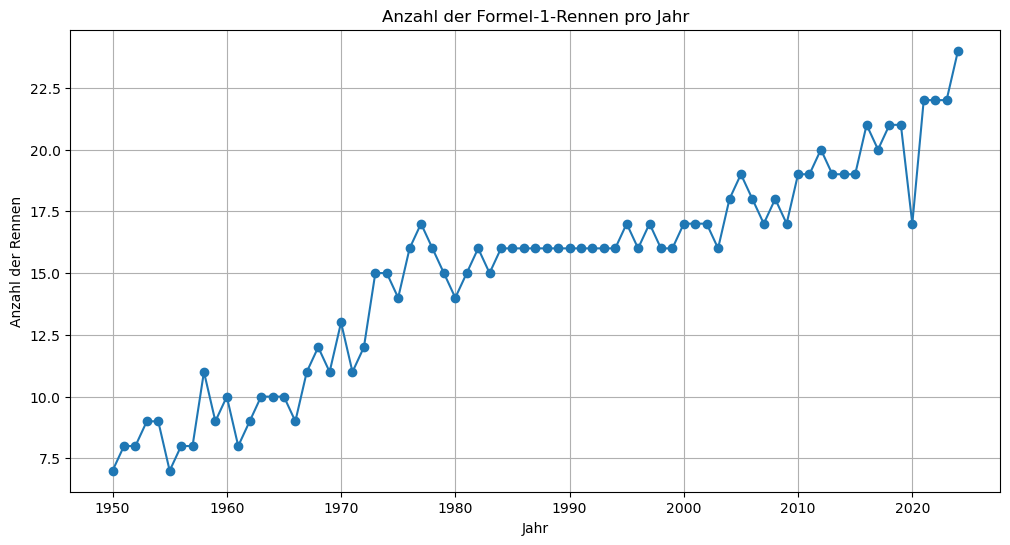

In [33]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect(db_path)

# anzahl der rennen pro jahr berechnen
query = """
SELECT year, COUNT(*) AS race_count
FROM races
GROUP BY year
ORDER BY year;
"""
df_races = pd.read_sql(query, conn)

conn.close()

# visualisierung
plt.figure(figsize=(12, 6))
plt.plot(df_races["year"], df_races["race_count"], marker="o", linestyle="-")

# achsenbeschriftungen und titel
plt.xlabel("Jahr")
plt.ylabel("Anzahl der Rennen")
plt.title("Anzahl der Formel-1-Rennen pro Jahr")

# gitterlinien
plt.grid(True)
plt.show()


## Anzahl der Formel-1-Rennen pro Jahr

Dieser Plot zeigt die Entwicklung der Anzahl an Formel-1-Rennen pro Jahr seit 1950.

### **Analyse & Erkenntnisse**
- Die Anzahl der Rennen pro Saison ist im Laufe der Jahrzehnte kontinuierlich gestiegen.
- In den 1950er- und 1960er-Jahren lag die Anzahl der Rennen typischerweise zwischen 7 und 11.
- Ab den 1970er-Jahren begann eine deutliche Zunahme der Rennanzahl, mit einem ersten Sprung auf ca. 15 Rennen pro Jahr.
- In den 1980er- und 1990er-Jahren pendelte sich die Anzahl der Rennen um die 16–17 pro Saison ein.
- Ab den 2000er-Jahren zeigt sich eine weitere Steigerung, mit Saisons, die regelmäßig über 20 Rennen umfassen.
- Der starke Rückgang um 2020 ist auf die COVID-19-Pandemie zurückzuführen, gefolgt von einem schnellen Anstieg auf neue Rekordwerte.

Die zunehmende Anzahl an Rennen spiegelt die wachsende Kommerzialisierung und weltweite Expansion der Formel 1 wider.


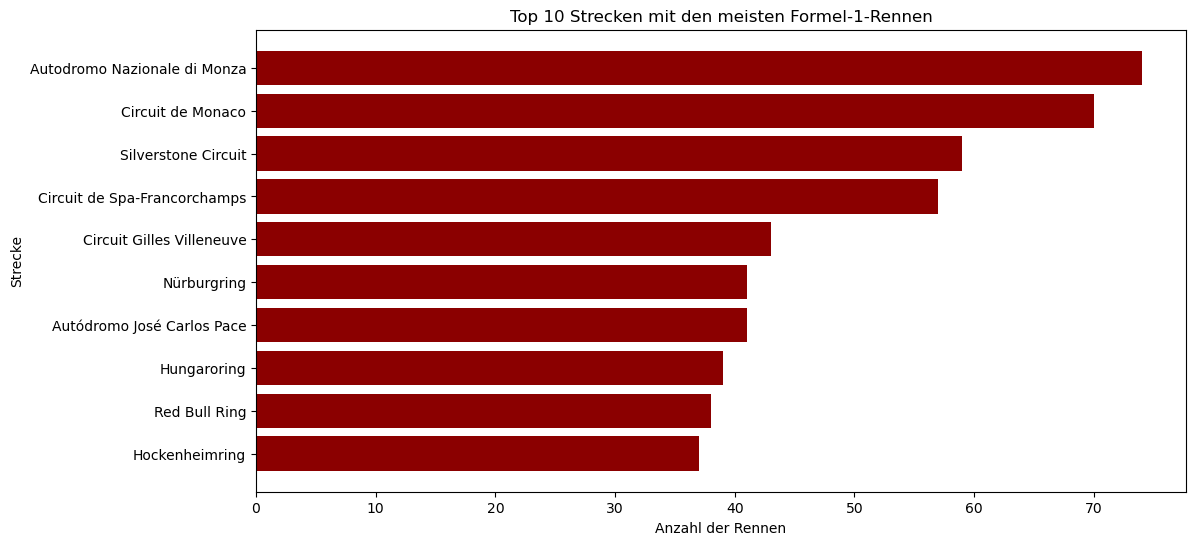

In [34]:
conn = sqlite3.connect(db_path)

# anzahl der rennen pro strecke berechnen
query = """
SELECT c.name AS circuit_name, COUNT(r.raceId) AS race_count
FROM races r
JOIN circuits c ON r.circuitId = c.circuitId
GROUP BY c.name
ORDER BY race_count DESC
LIMIT 10;
"""
df_circuits = pd.read_sql(query, conn)

conn.close()

# visualisierung
plt.figure(figsize=(12, 6))
plt.barh(df_circuits["circuit_name"], df_circuits["race_count"], color="darkred")

# achsenbeschriftungen und titel
plt.xlabel("Anzahl der Rennen")
plt.ylabel("Strecke")
plt.title("Top 10 Strecken mit den meisten Formel-1-Rennen")
plt.gca().invert_yaxis()  # höchste werte oben anzeigen

plt.show()


## Top 10 Strecken mit den meisten Formel-1-Rennen

Dieser Plot zeigt die zehn Rennstrecken mit den meisten ausgetragenen Formel-1-Rennen in der Geschichte des Sports.

### **Analyse & Erkenntnisse**
- Der **Autodromo Nazionale di Monza** führt die Liste mit den meisten ausgetragenen Rennen an. Die Strecke ist eine der traditionsreichsten im Formel-1-Kalender.
- **Monaco, Silverstone und Spa-Francorchamps** gehören ebenfalls zu den Strecken mit der längsten Historie und sind nahezu durchgehend Teil der Meisterschaft gewesen.
- Der **Circuit Gilles Villeneuve** in Kanada sowie der **Nürburgring** in Deutschland sind ebenfalls bedeutende Austragungsorte, allerdings mit unterbrochener Kontinuität.
- Das Ranking enthält sowohl europäische als auch außereuropäische Strecken, was die zunehmende Internationalisierung der Formel 1 widerspiegelt.
- Interessanterweise sind mit dem **Hockenheimring** und dem **Nürburgring** zwei deutsche Strecken in der Top 10 vertreten, was die frühere Bedeutung Deutschlands für die Formel 1 unterstreicht.

Die Daten verdeutlichen die langfristige Bedeutung bestimmter Traditionsstrecken im Rennkalender.


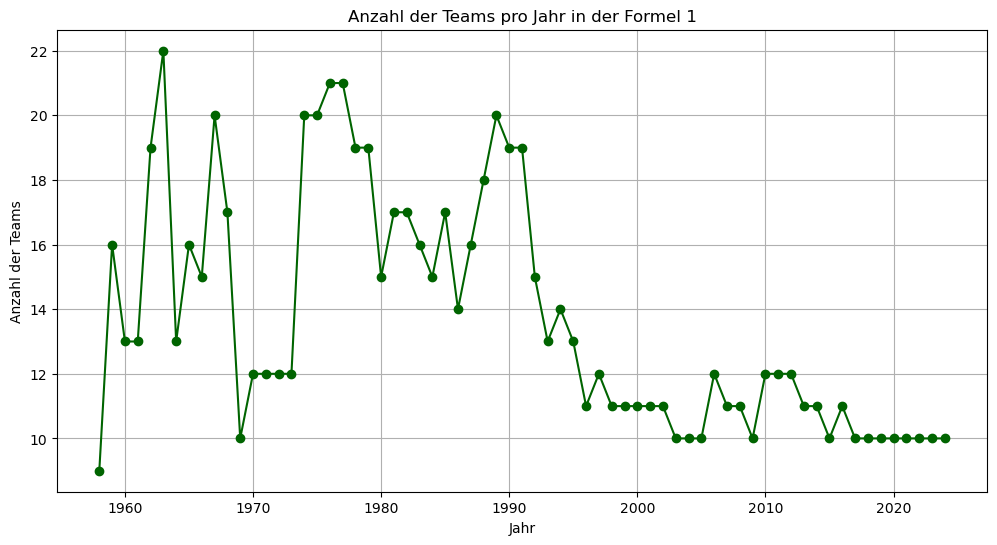

In [35]:
conn = sqlite3.connect(db_path)

# anzahl der teams pro jahr berechnen
query = """
SELECT r.year, COUNT(DISTINCT cs.constructorId) AS team_count
FROM constructor_standings cs
JOIN races r ON cs.raceId = r.raceId
GROUP BY r.year
ORDER BY r.year;
"""
df_teams = pd.read_sql(query, conn)

conn.close()

# visualisierung
plt.figure(figsize=(12, 6))
plt.plot(df_teams["year"], df_teams["team_count"], marker="o", linestyle="-", color="darkgreen")

# achsenbeschriftungen und titel
plt.xlabel("Jahr")
plt.ylabel("Anzahl der Teams")
plt.title("Anzahl der Teams pro Jahr in der Formel 1")

# gitterlinien
plt.grid(True)
plt.show()


## Anzahl der Teams pro Jahr in der Formel 1

Dieser Plot zeigt die Entwicklung der Anzahl an Teams pro Jahr in der Formel 1.

### **Analyse & Erkenntnisse**
- In den 1950er- bis 1960er-Jahren gab es starke Schwankungen in der Anzahl der teilnehmenden Teams. Grund: Indianapolis 500 zählte in den 50gern  mit   zur Formel 1 WM und die dort antretenden Teams sind folglich in dieser Statistik vertreten.
- -1972 machten Konstrukteure wie March, später Brabham, Surtees und McLaren ihre Autos auch Privatfahrern zugänglich. 
- Die 1980er- und frühen 1990er-Jahre waren von einer relativ hohen Teamanzahl geprägt, mit Spitzenwerten von über 20 Teams pro Saison.
- Seit Mitte der 1990er-Jahre ist ein deutlicher Rückgang zu beobachten, mit einer Stabilisierung bei rund 10 Teams seit den 2000er-Jahren.
- Diese Reduktion ist auf steigende Kosten, strengere Regularien und die zunehmende Kommerzialisierung des Sports zurückzuführen.
- Die konstante Anzahl der Teams in den letzten Jahren deutet darauf hin, dass die Formel 1 sich auf eine langfristige wirtschaftliche Stabilität eingelassen hat.

Die Daten zeigen den Wandel von einer vielfältigen, teils experimentellen Teamlandschaft hin zu einer festen Elite von Teams mit großen Budgets.


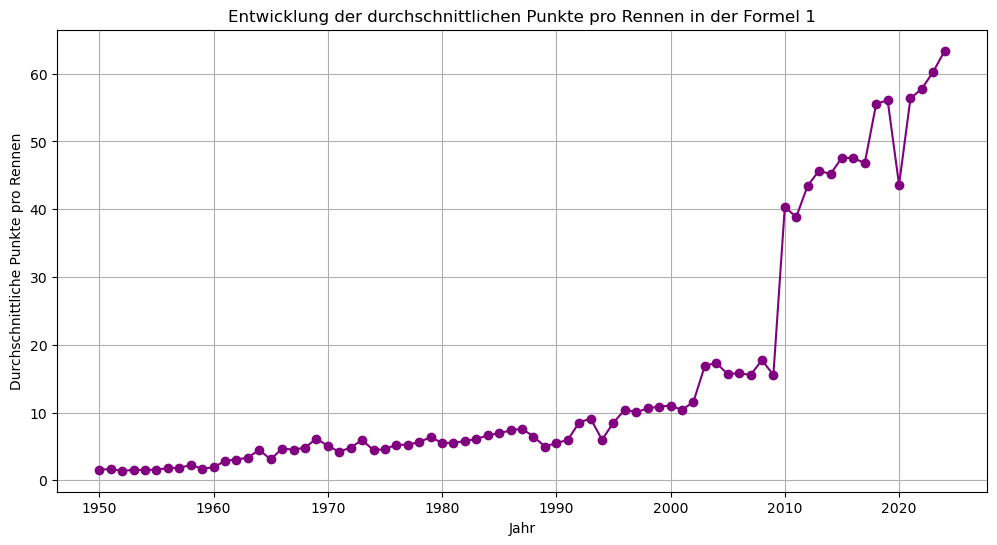

In [36]:
conn = sqlite3.connect(db_path)

# durchschnittliche punkte pro rennen
query = """
SELECT r.year, AVG(ds.points) AS avg_points
FROM driver_standings ds
JOIN races r ON ds.raceId = r.raceId
GROUP BY r.year
ORDER BY r.year;
"""
df_points = pd.read_sql(query, conn)

conn.close()

# visualisierung
plt.figure(figsize=(12, 6))
plt.plot(df_points["year"], df_points["avg_points"], marker="o", linestyle="-", color="purple")

# achsenbeschriftungen und titel
plt.xlabel("Jahr")
plt.ylabel("Durchschnittliche Punkte pro Rennen")
plt.title("Entwicklung der durchschnittlichen Punkte pro Rennen in der Formel 1")

# gitterlinien
plt.grid(True)
plt.show()


## Entwicklung der durchschnittlichen Punkte pro Rennen in der Formel 1

Dieser Plot zeigt die Entwicklung der durchschnittlichen vergebenen Punkte pro Rennen in der Geschichte der Formel 1.

### **Analyse & Erkenntnisse**
- Von 1950 bis in die frühen 2000er blieb die durchschnittliche Punktzahl pro Rennen relativ niedrig und stieg nur langsam an.
- In den späten 2000er-Jahren zeigt sich ein sprunghafter Anstieg, bedingt durch Änderungen im Punktesystem.
- Die Einführung des neuen Punktesystems 2010, bei dem die Top 10 anstelle der Top 6 Punkte erhalten, führte zu einem starken Anstieg der durchschnittlichen Punkte pro Rennen.
- Seitdem hat sich das System weiterentwickelt, insbesondere durch die Einführung von Bonuspunkten für die schnellste Rennrunde und Sprint-Rennen, was weitere Steigerungen in den letzten Jahren erklärt.
- Die stetige Zunahme der durchschnittlichen Punkte spiegelt die Anpassungen des Punktesystems wider, das darauf abzielt, das Rennformat spannender zu gestalten und mehr Fahrern eine Chance auf Punkte zu geben.

Die Entwicklung zeigt, wie Regeländerungen das Wettkampfniveau und die Dynamik der Meisterschaft beeinflussen.


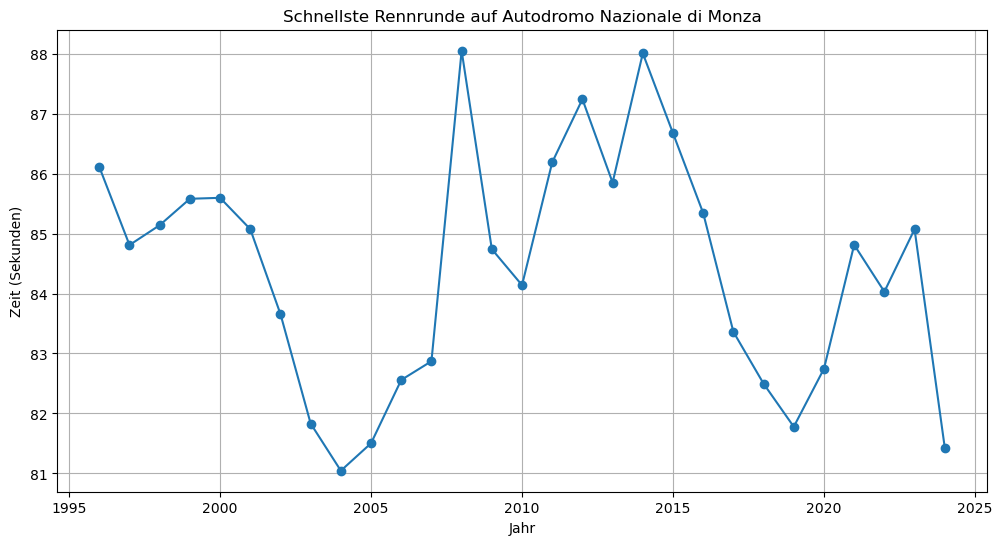

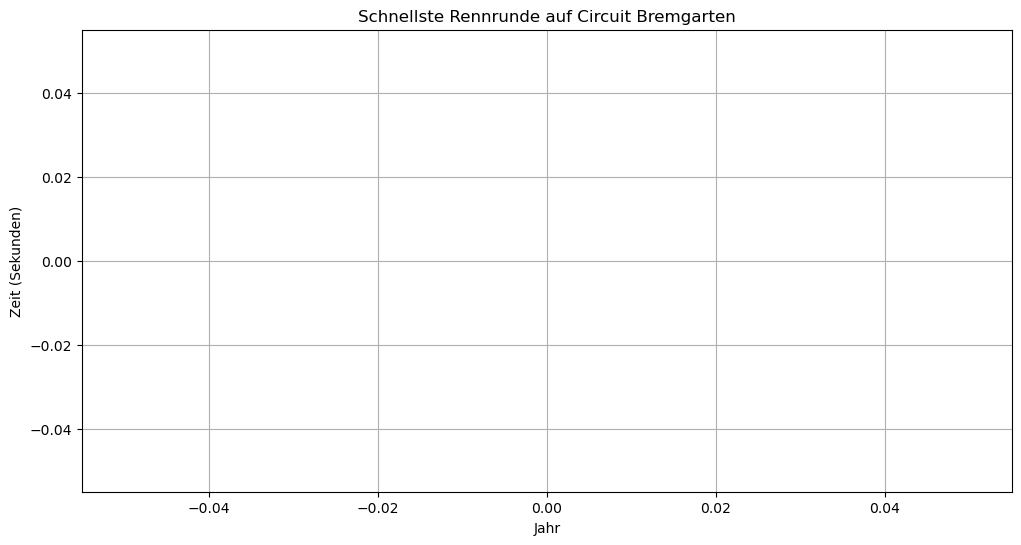

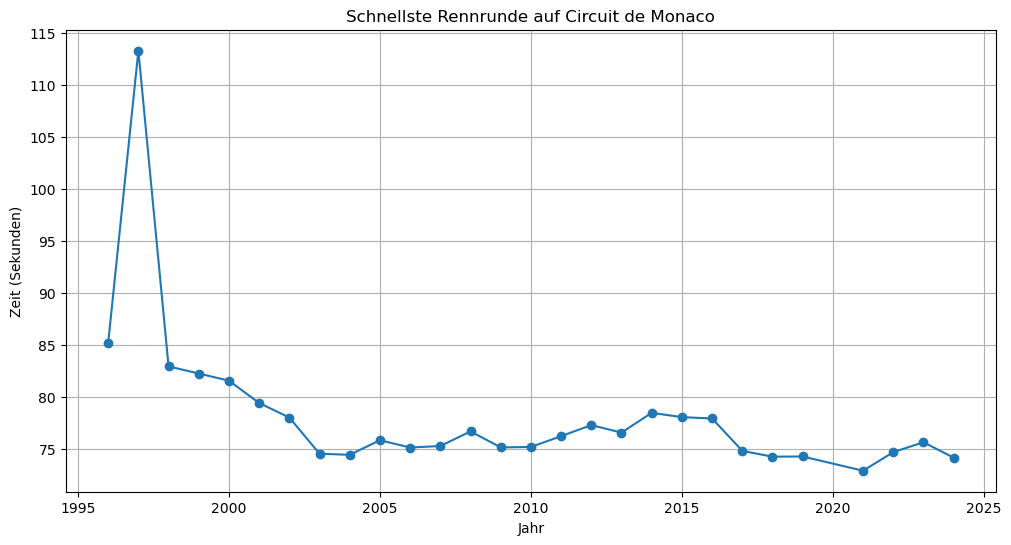

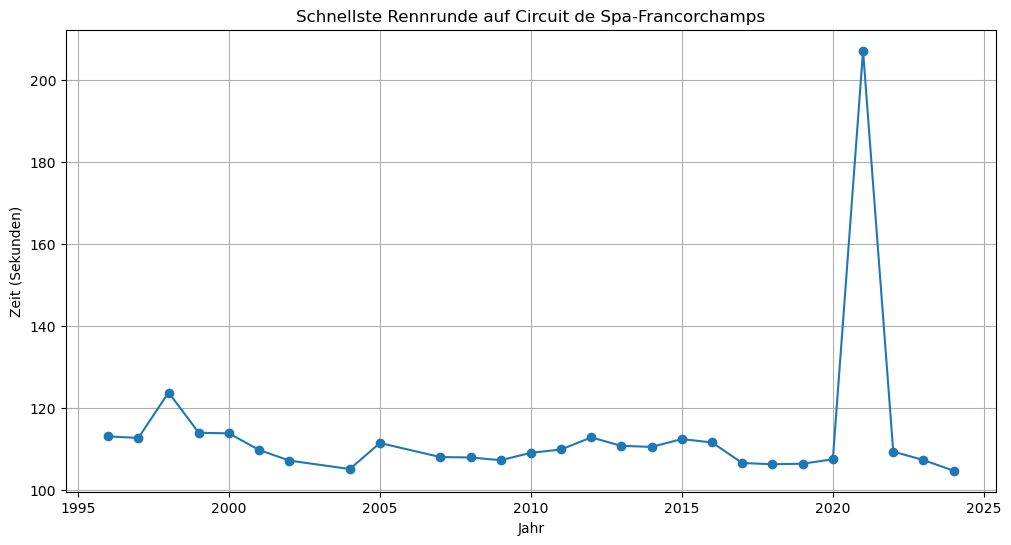

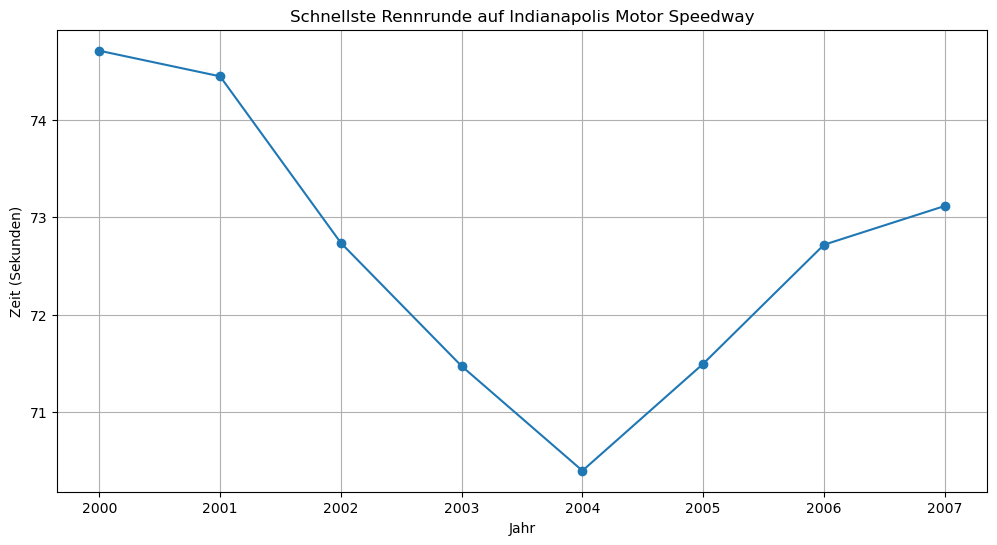

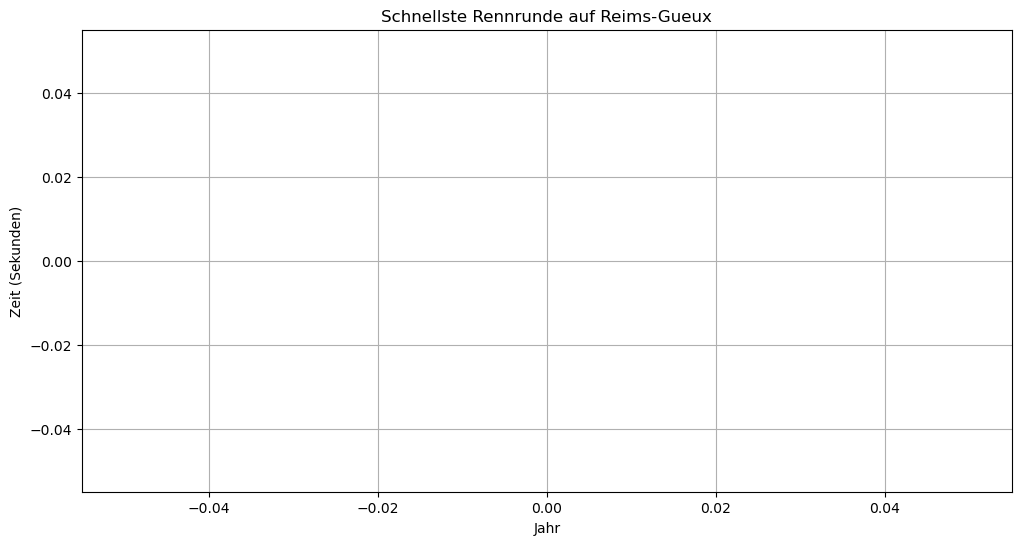

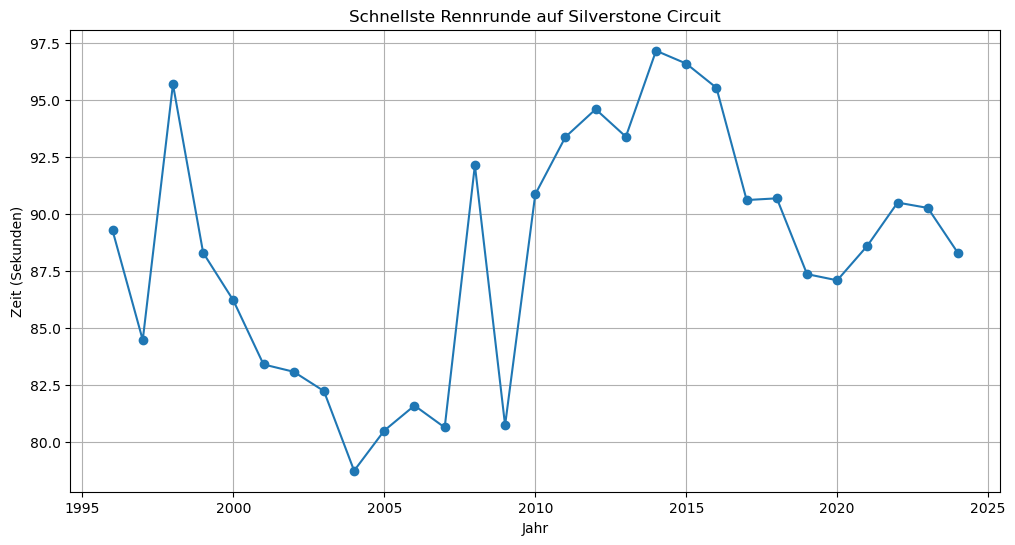

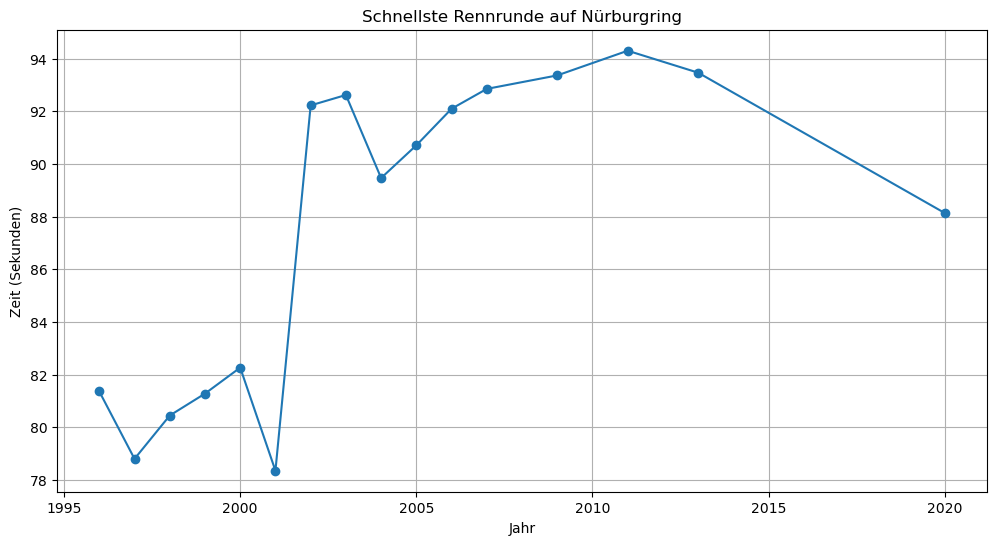

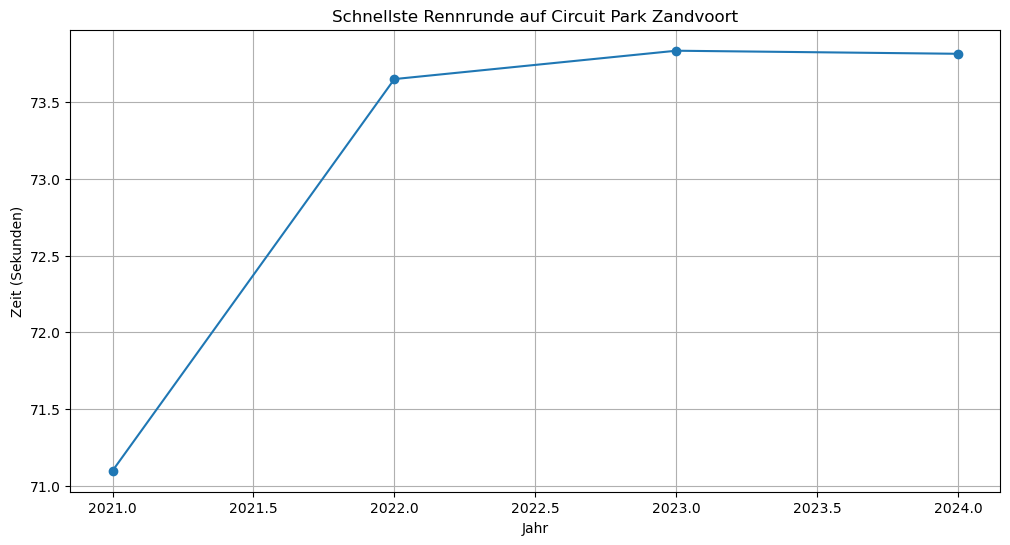

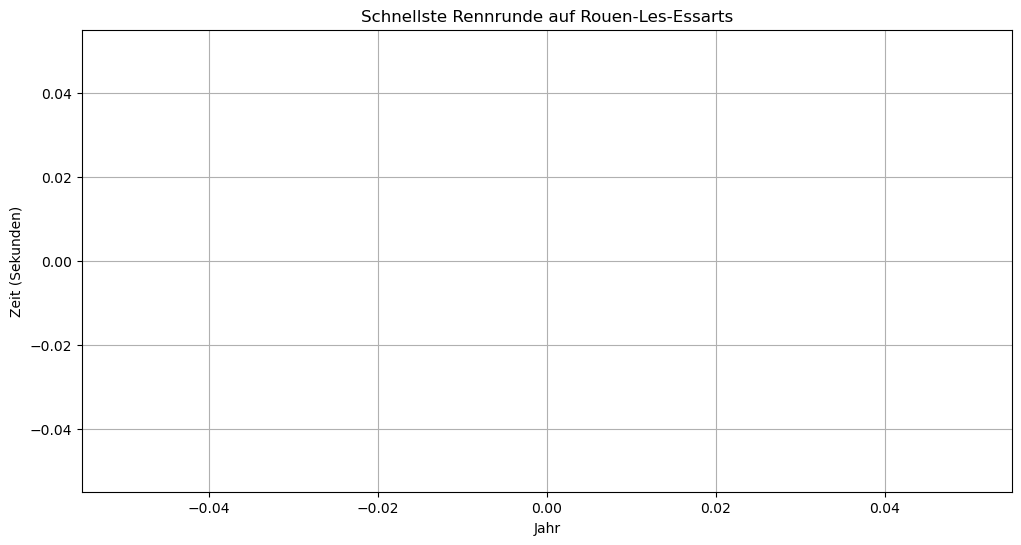

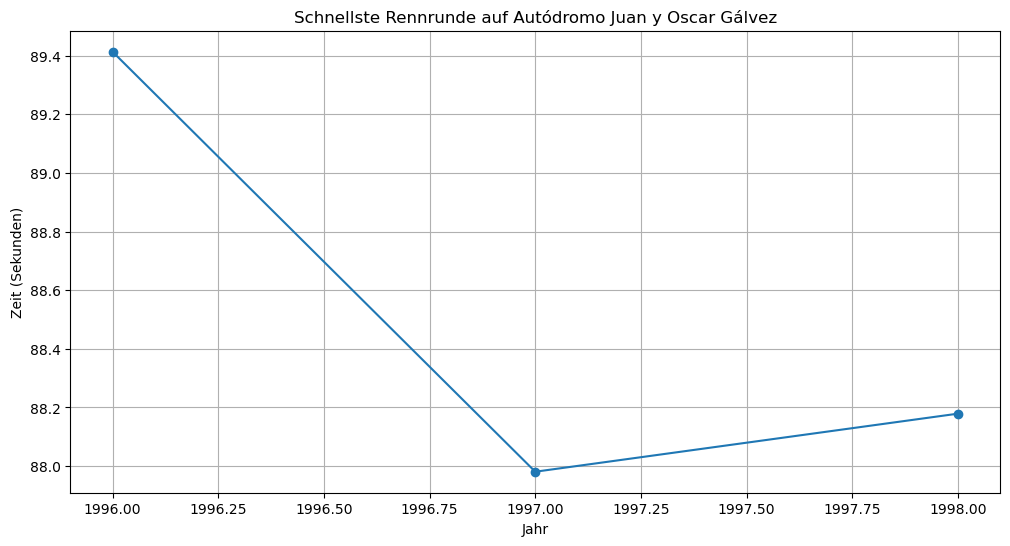

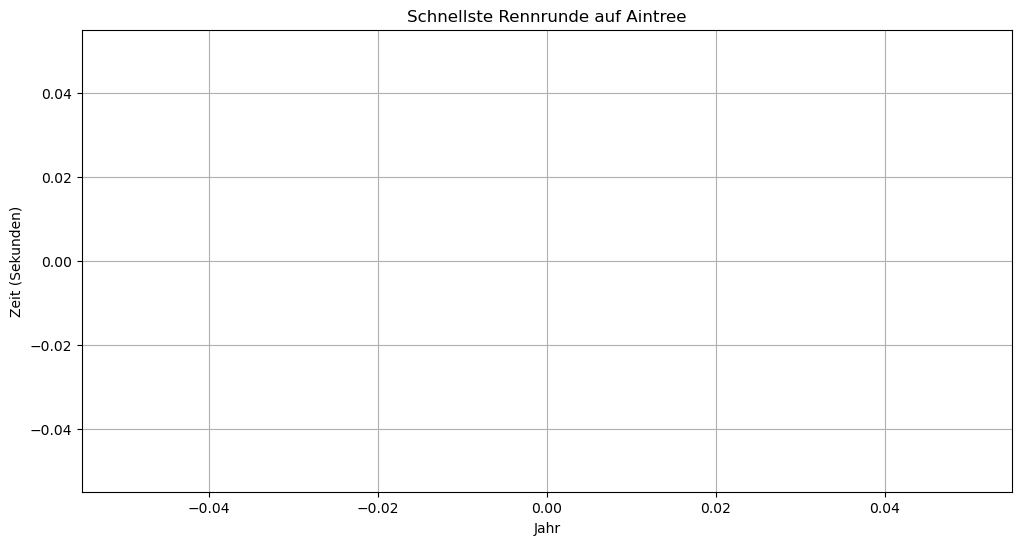

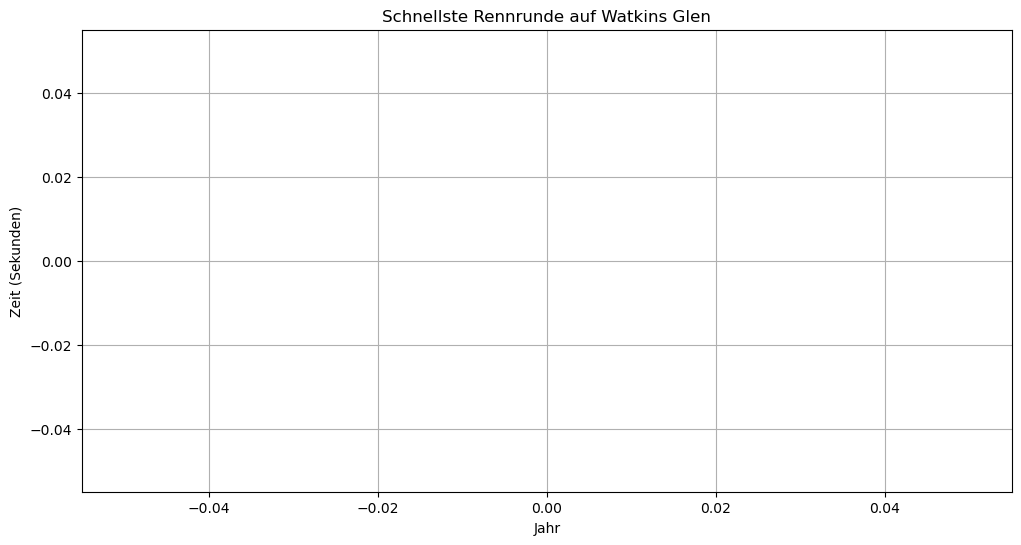

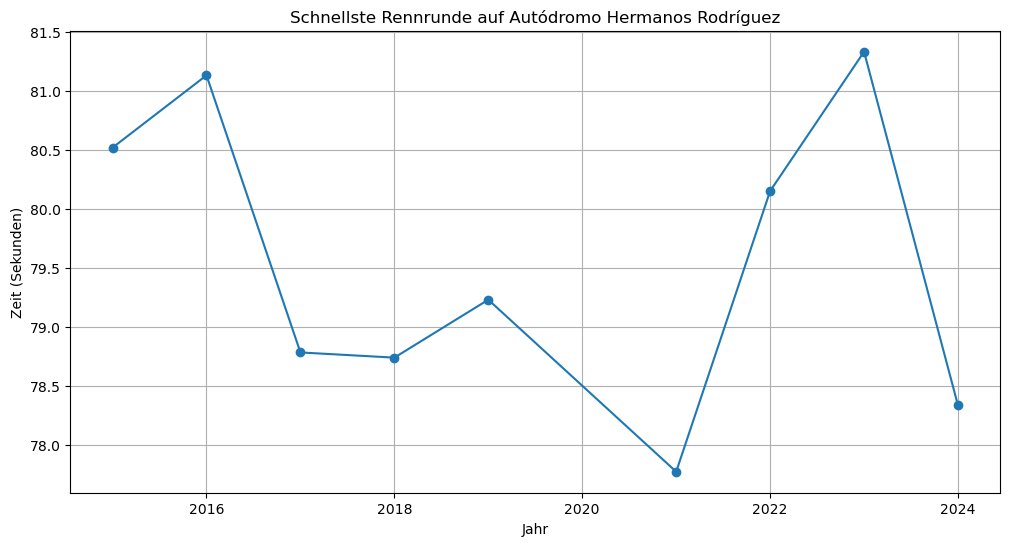

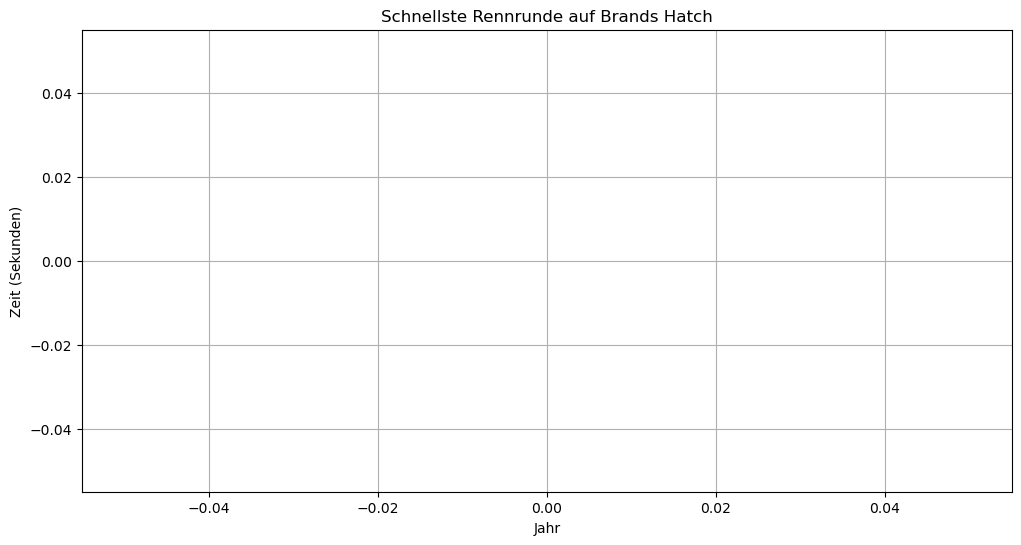

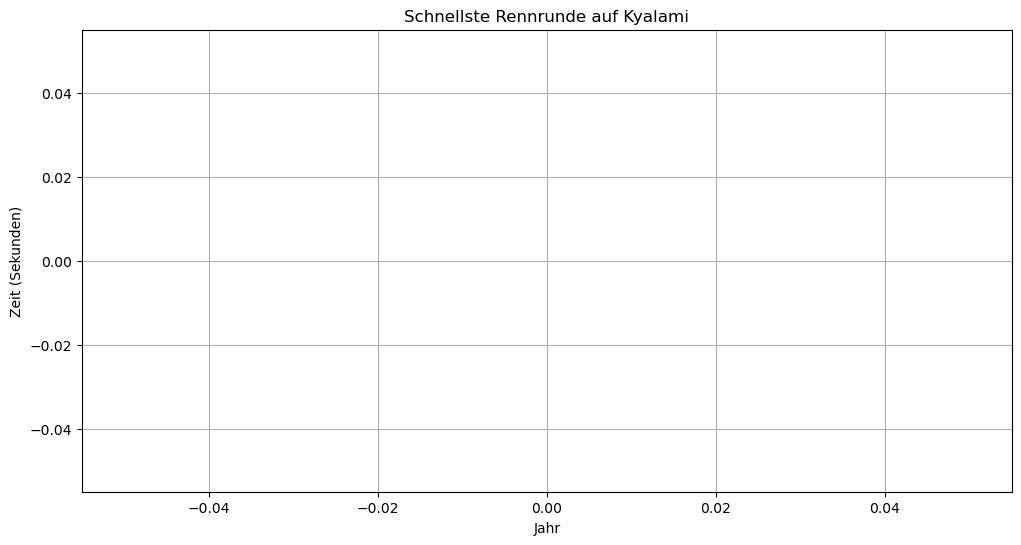

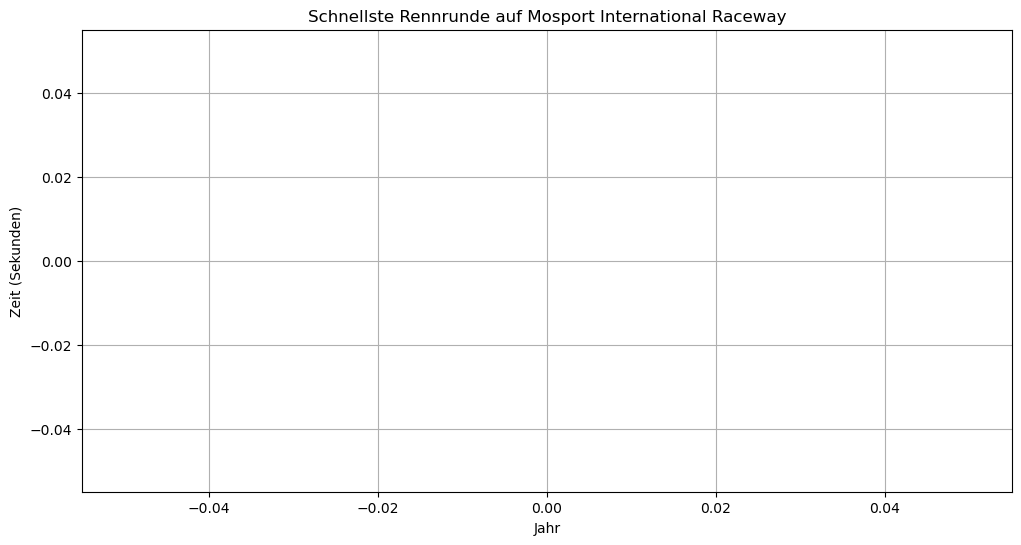

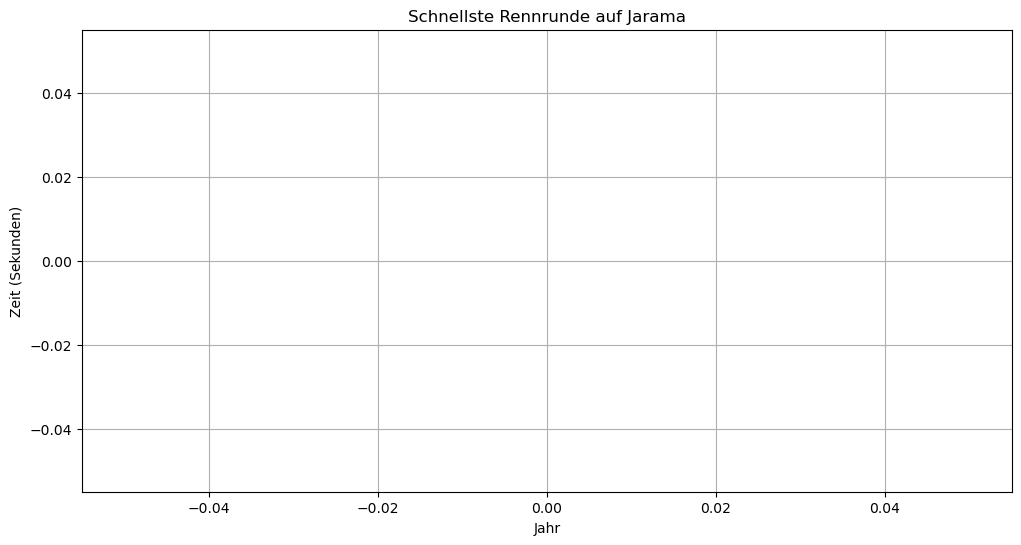

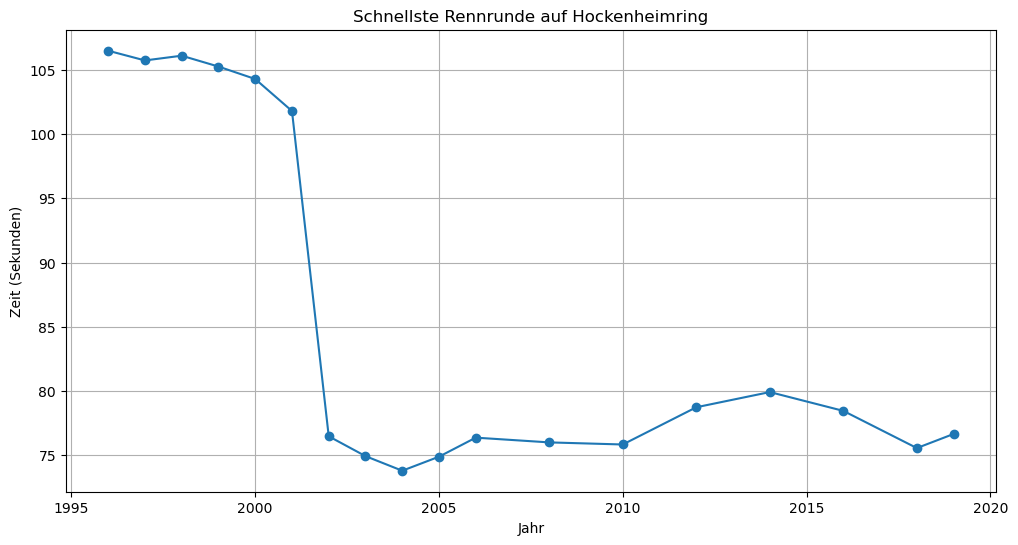

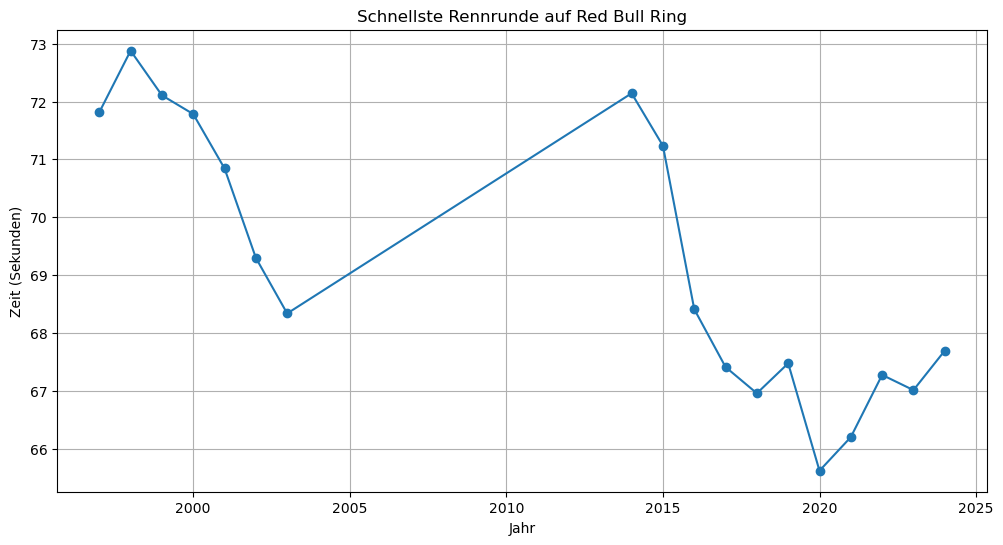

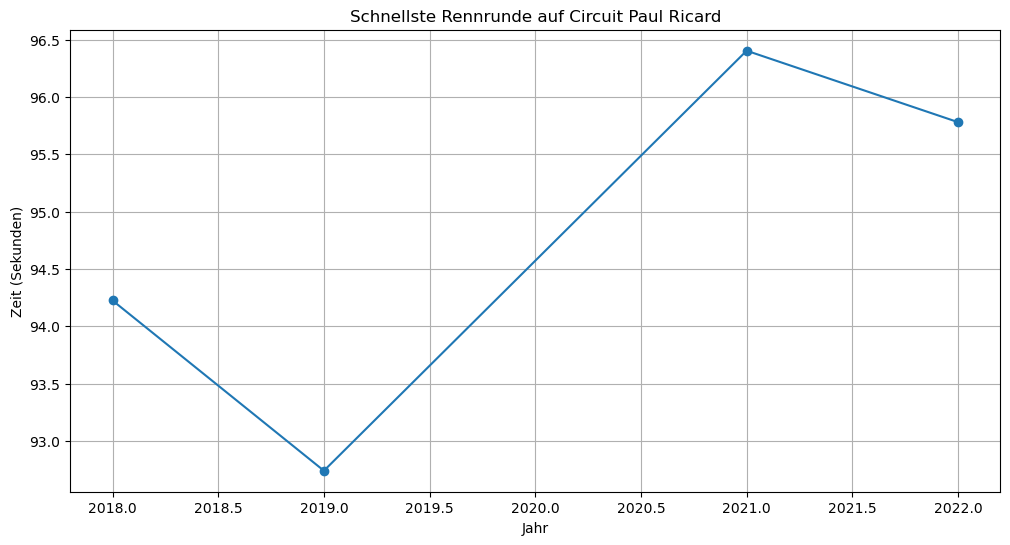

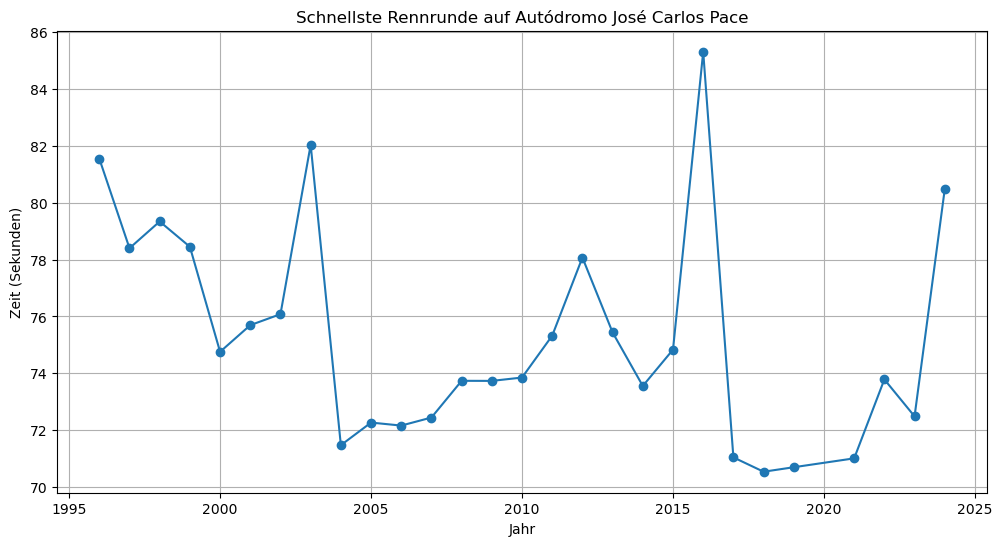

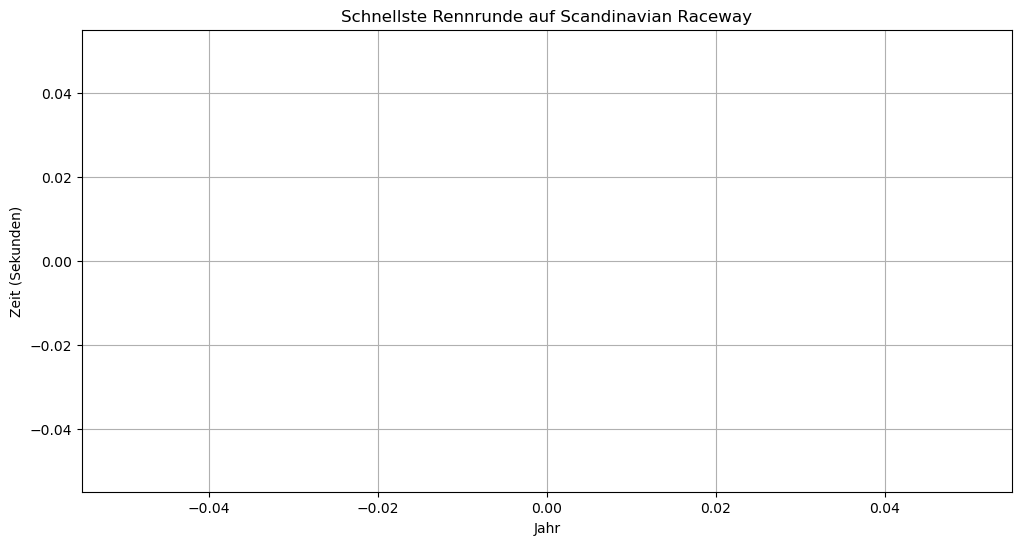

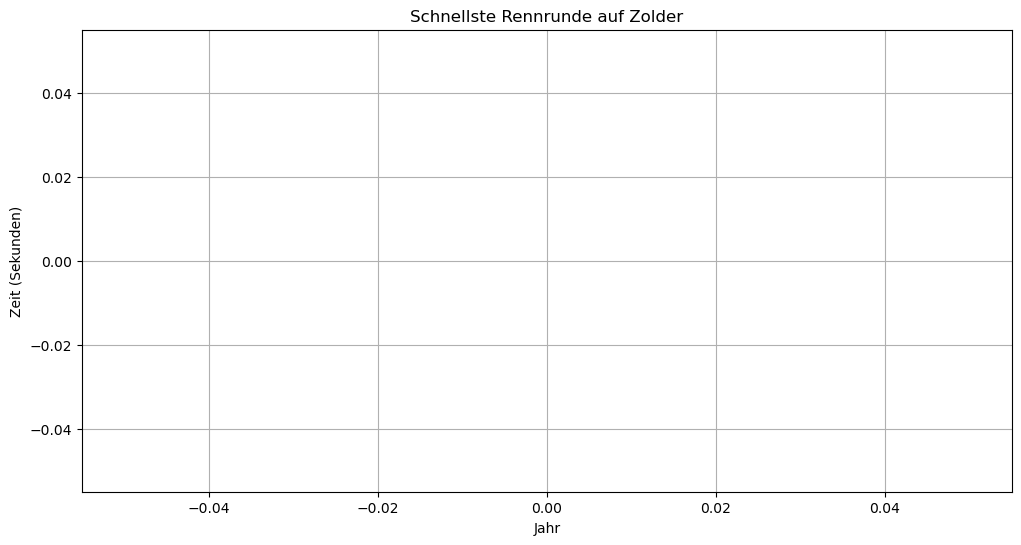

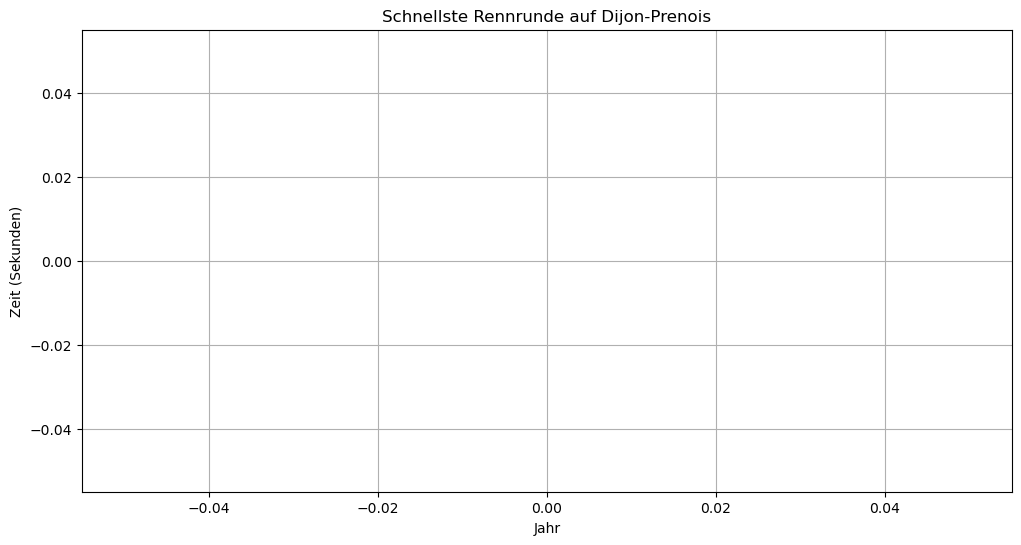

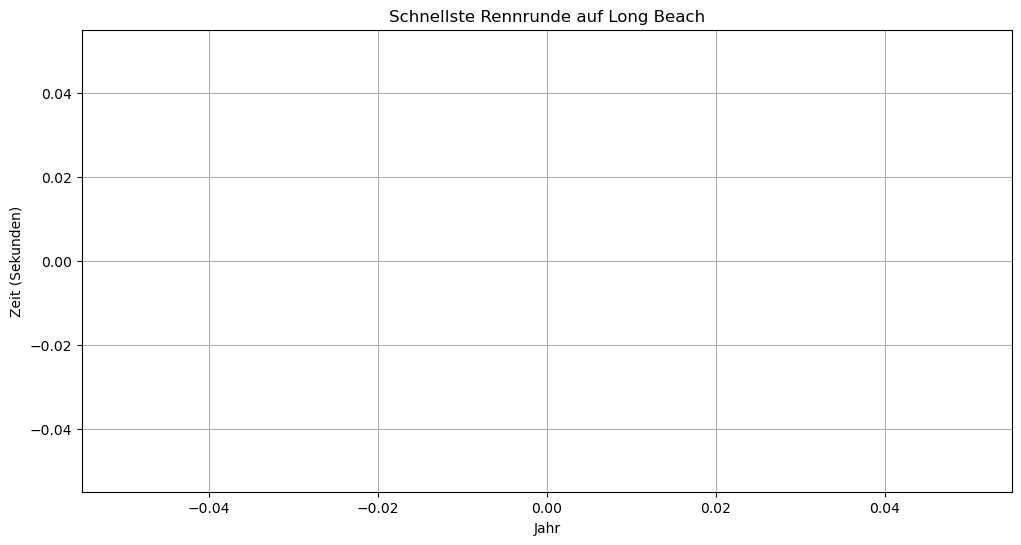

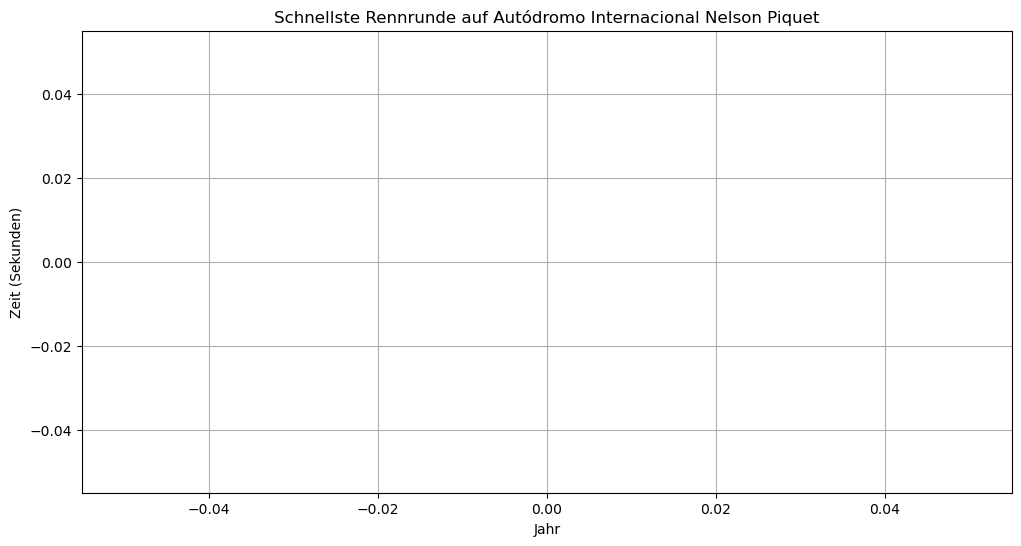

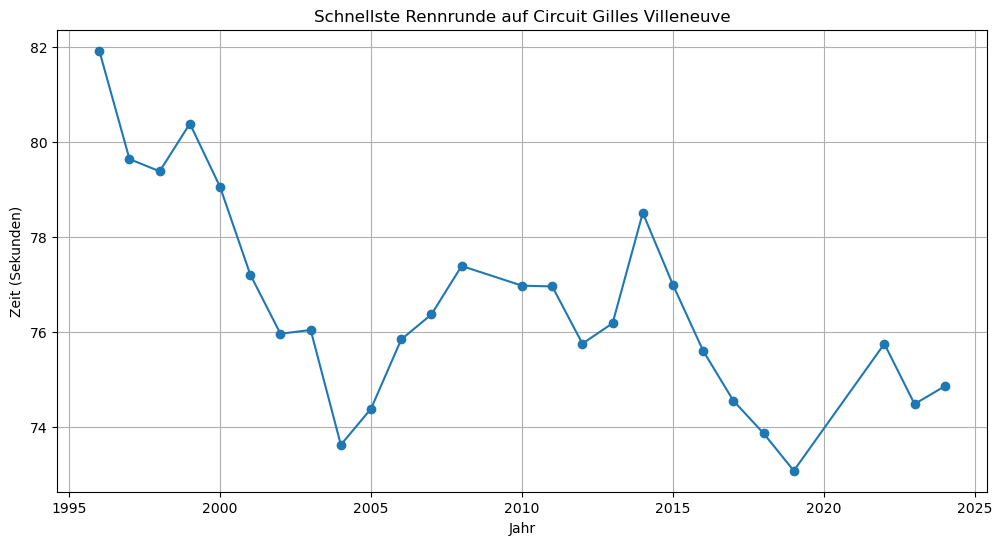

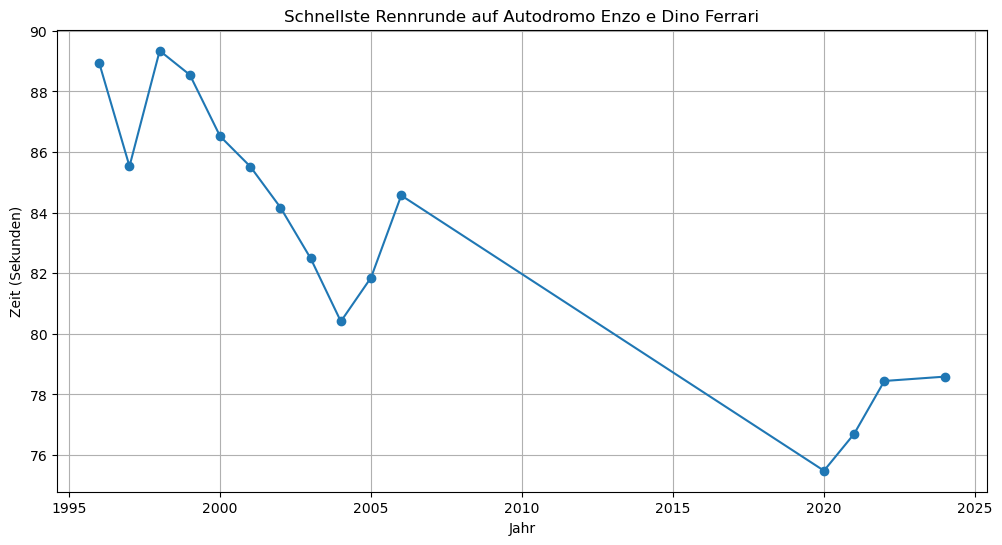

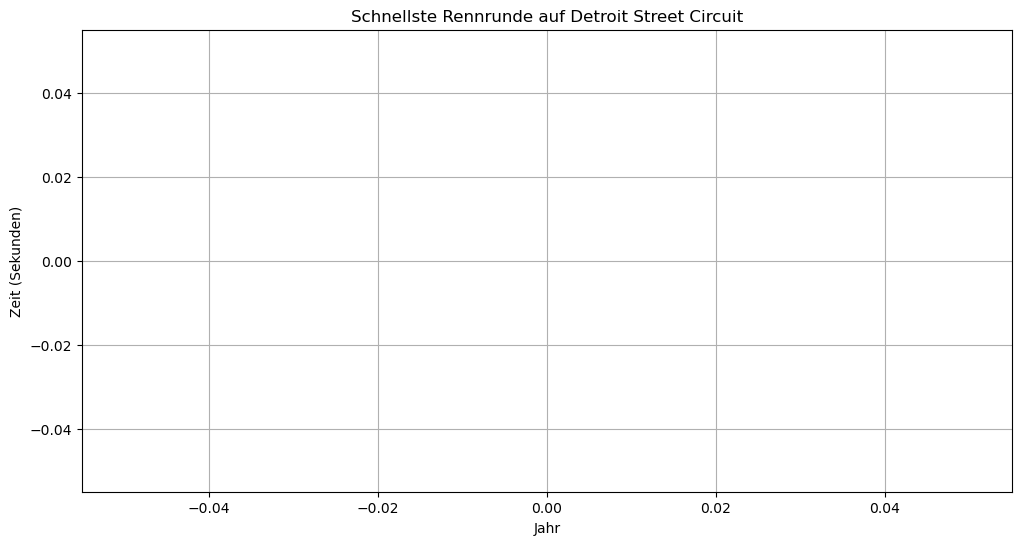

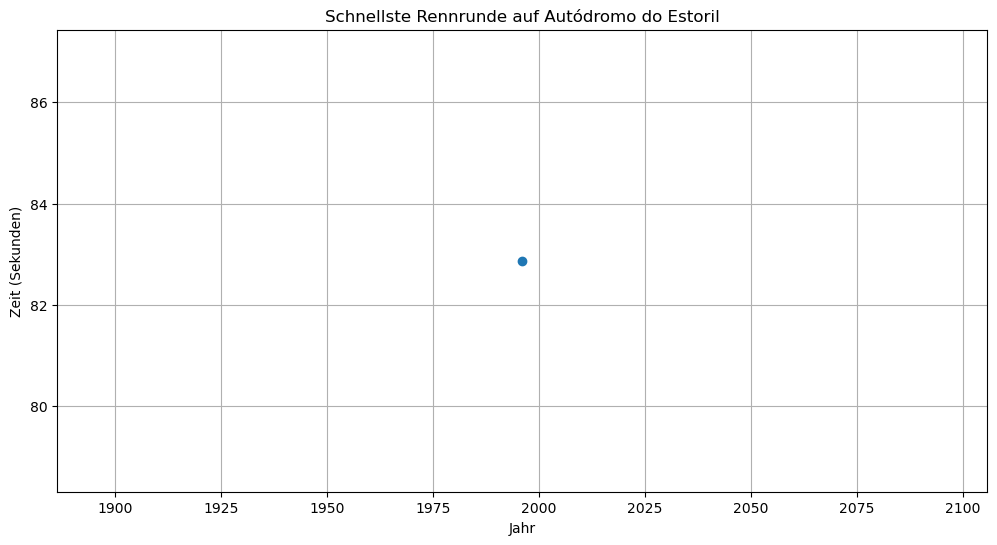

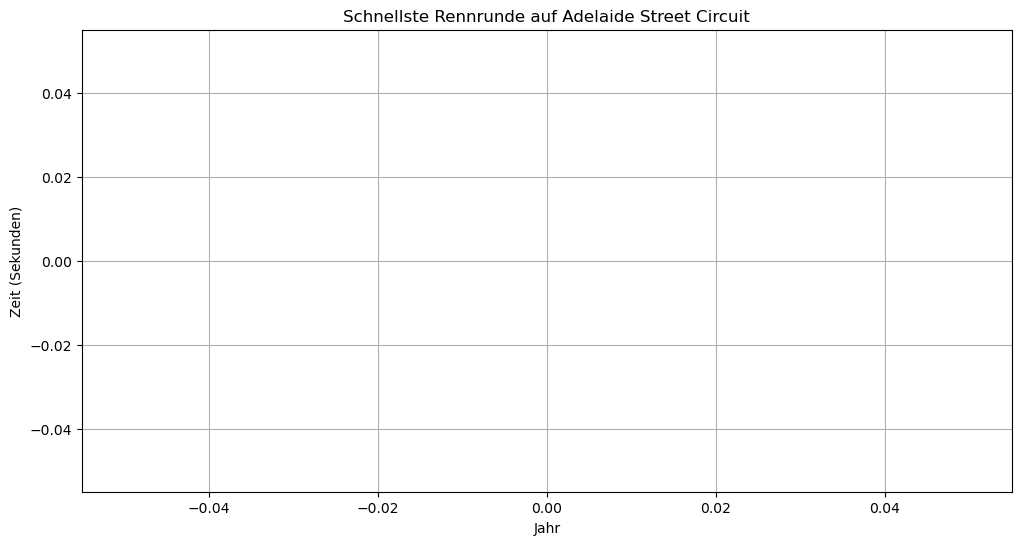

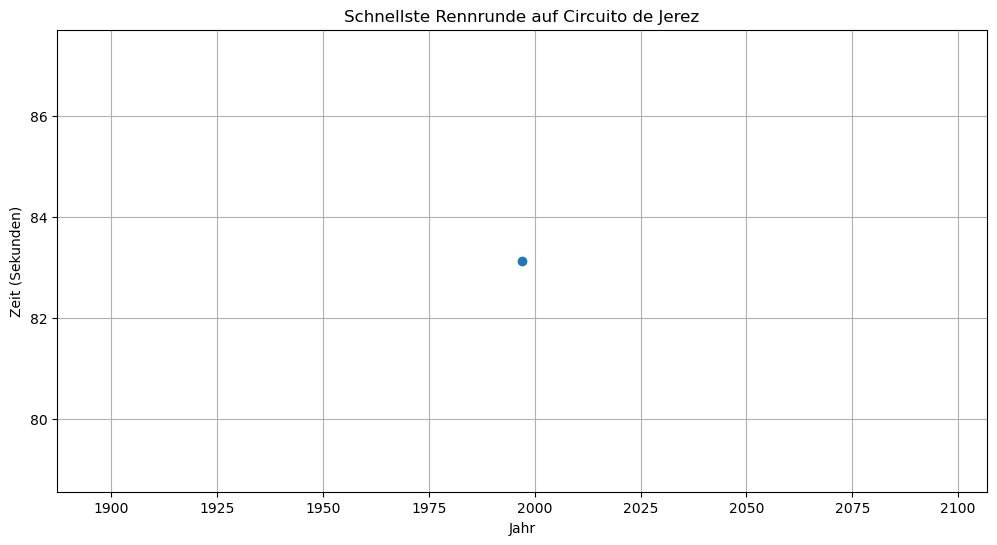

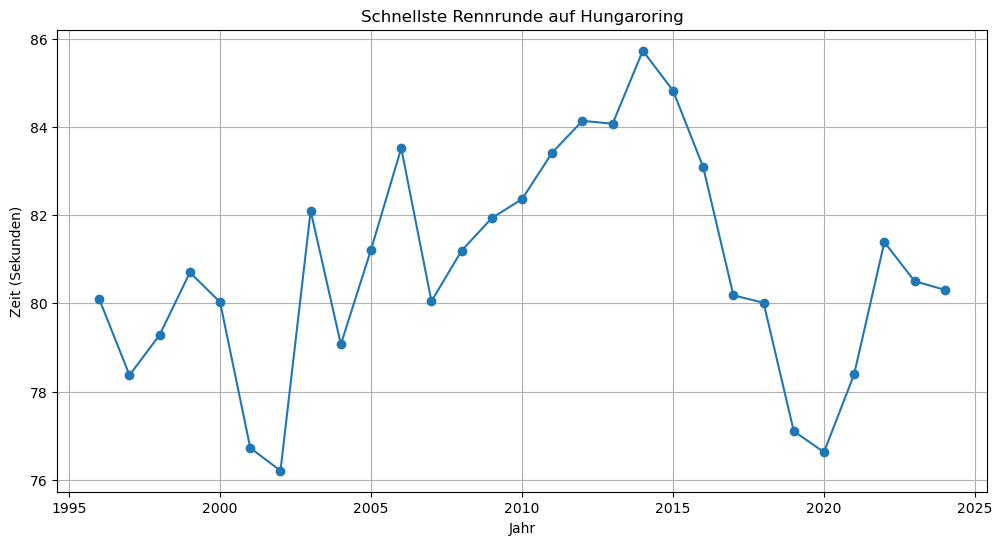

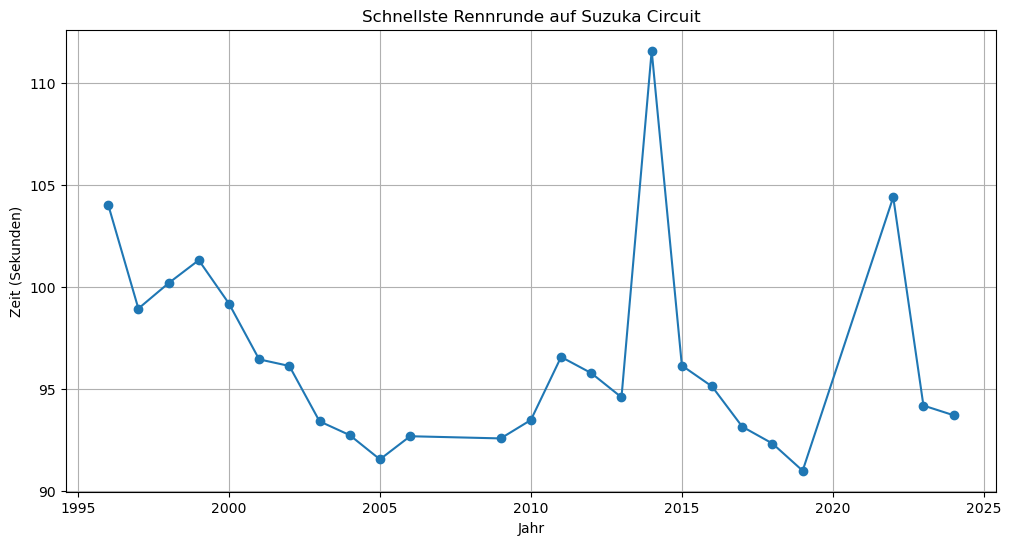

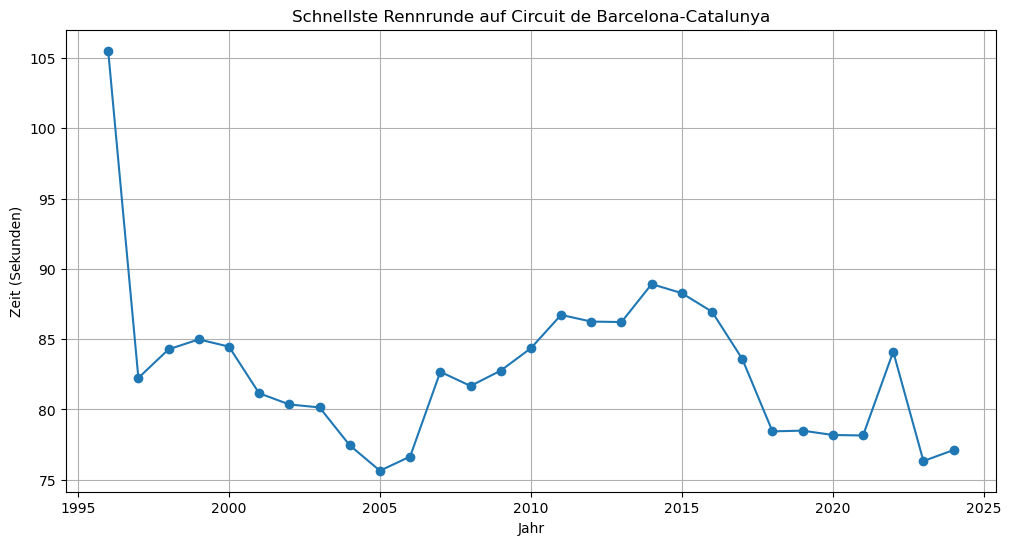

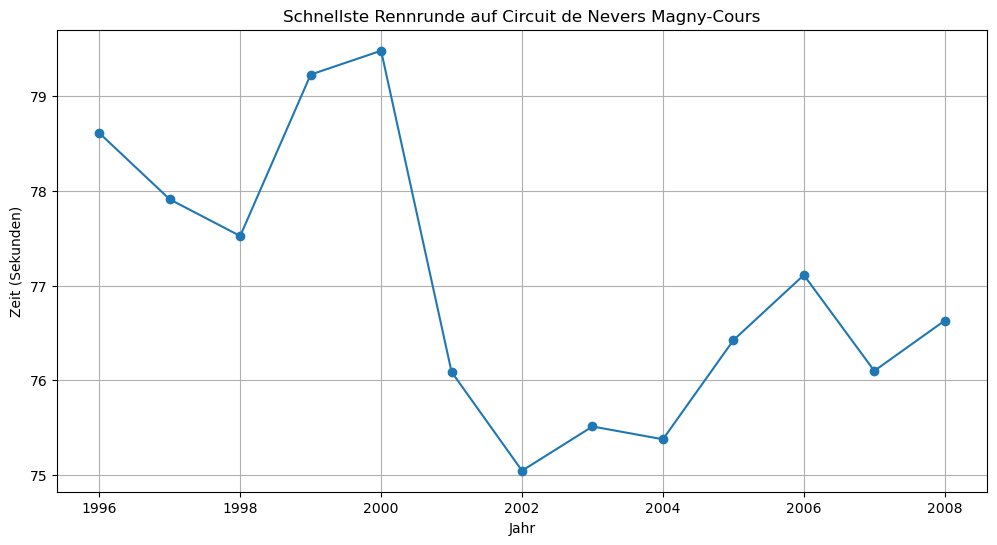

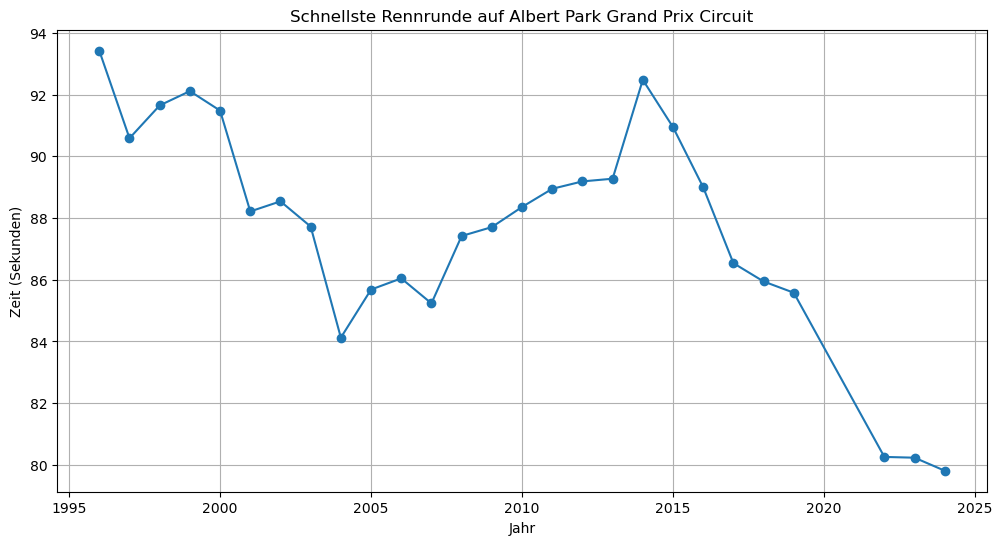

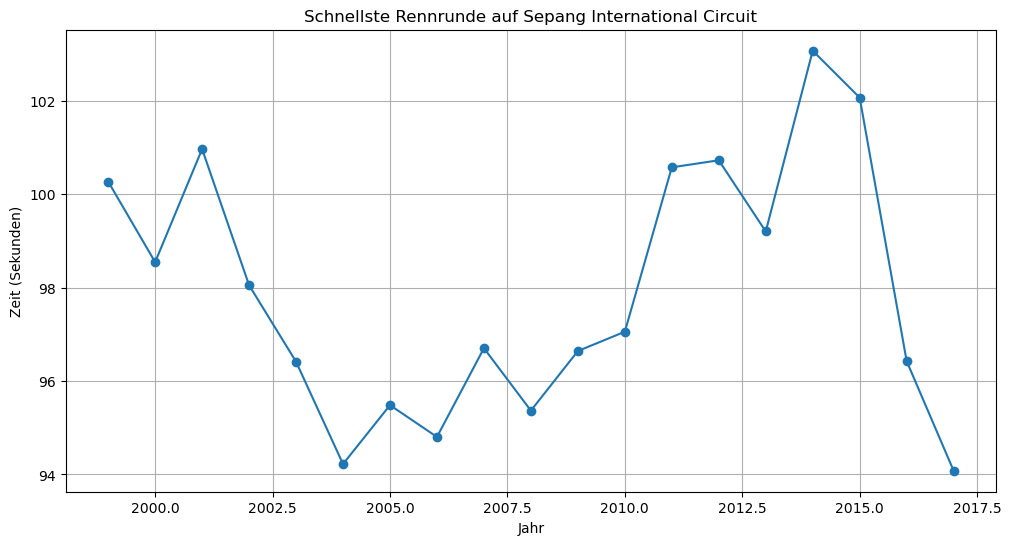

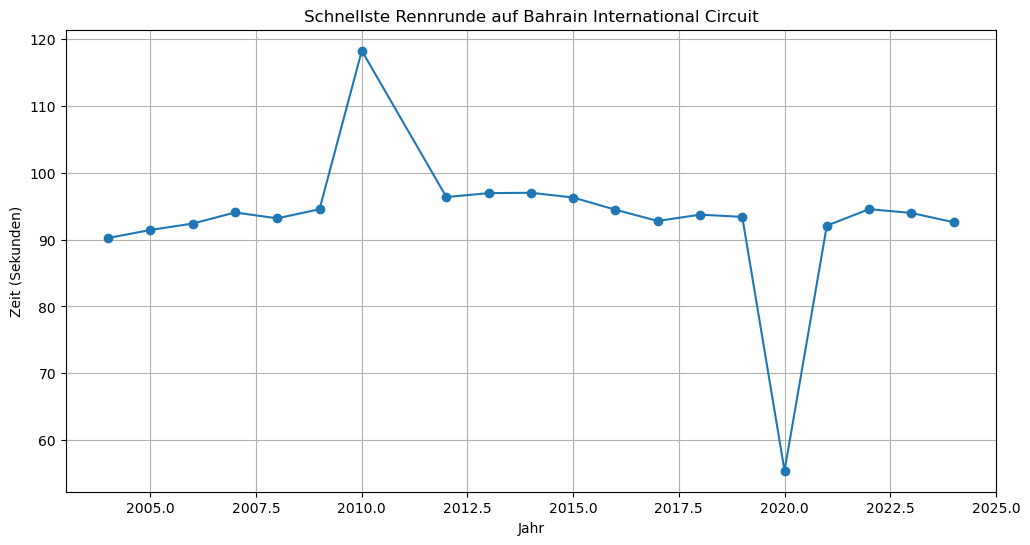

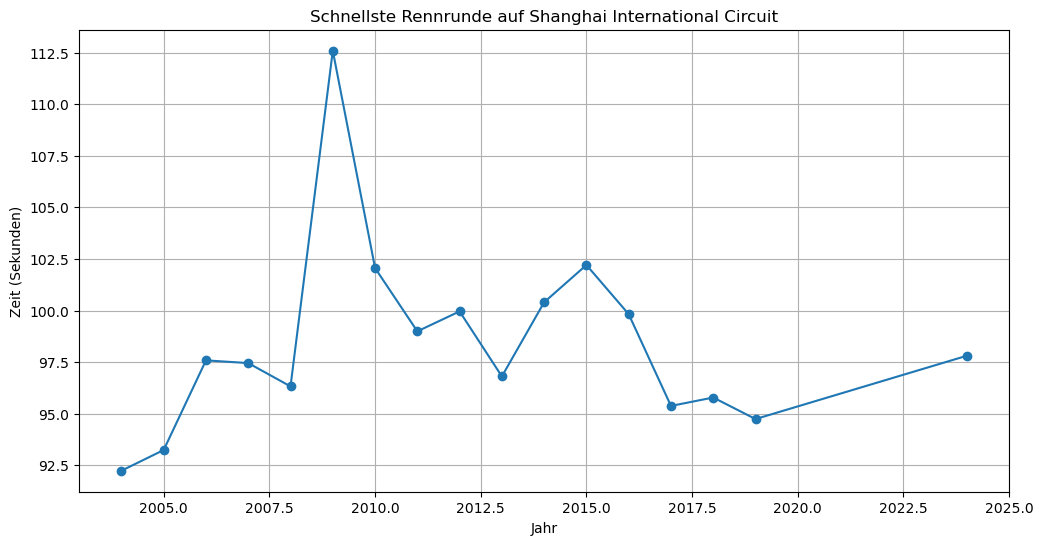

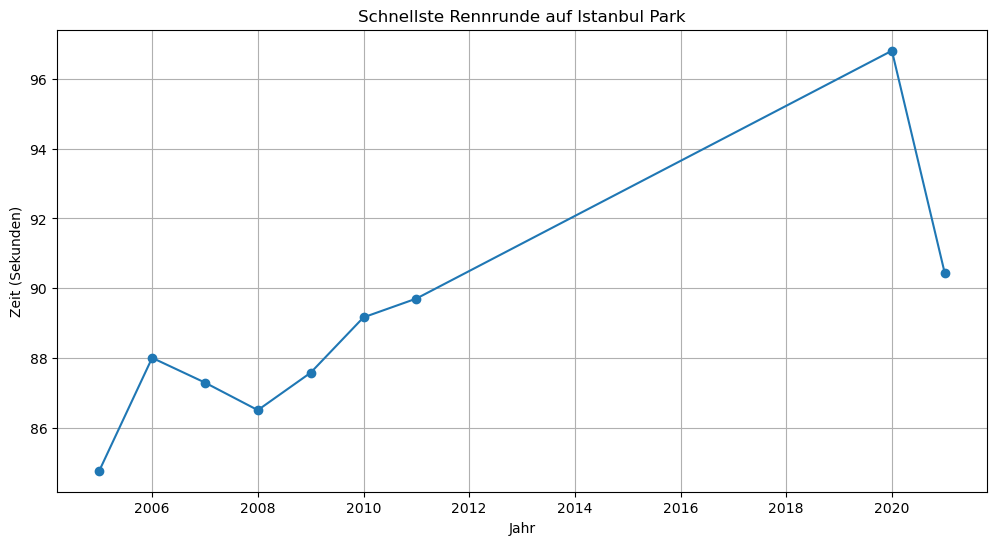

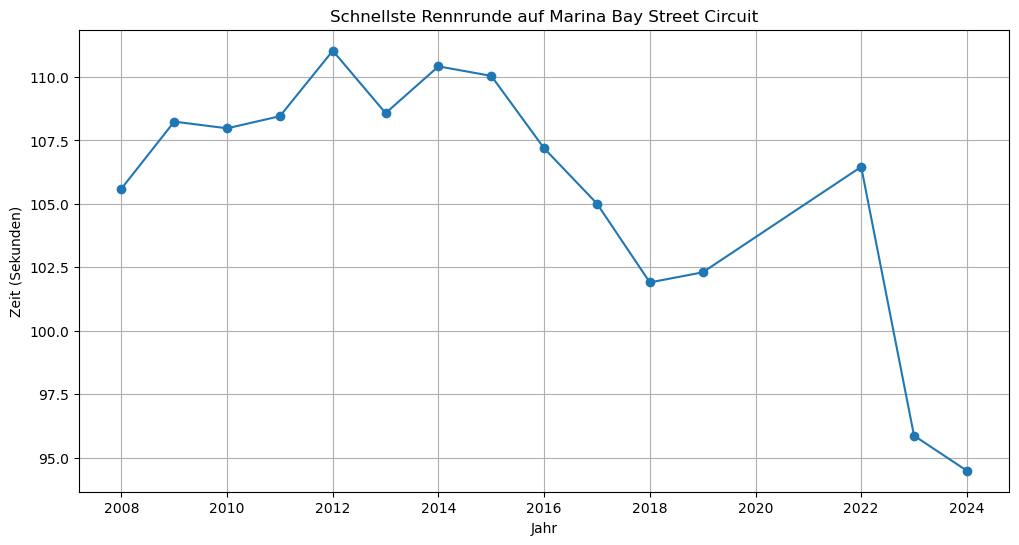

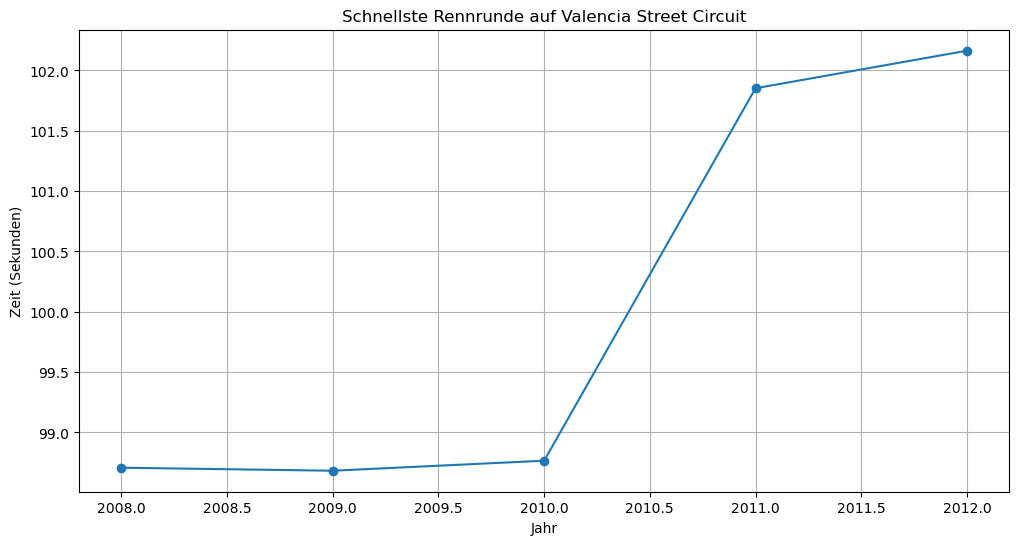

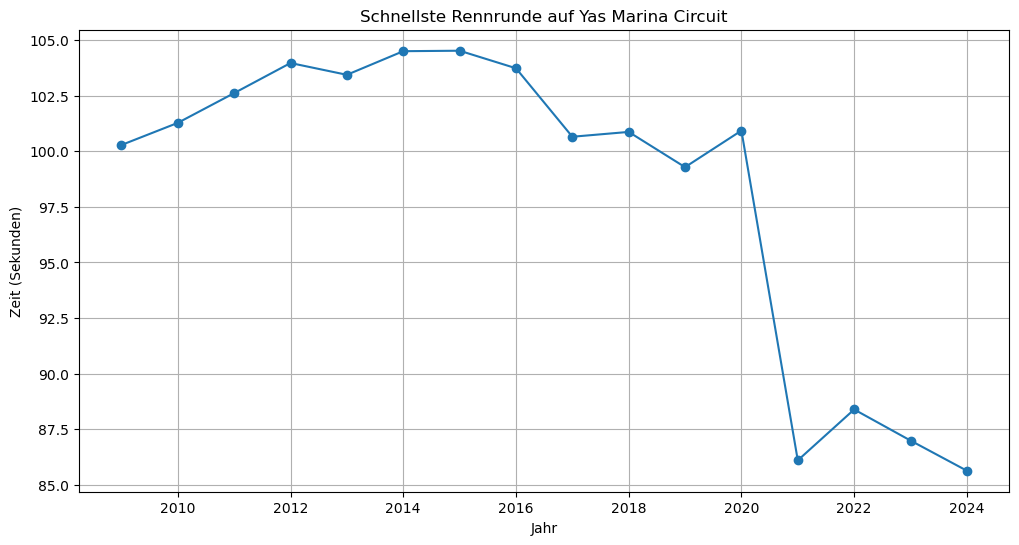

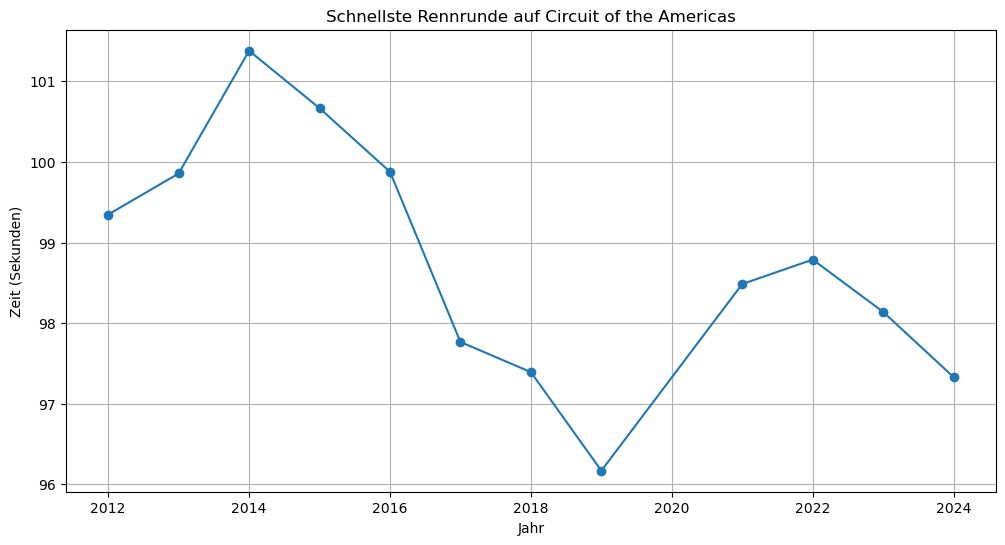

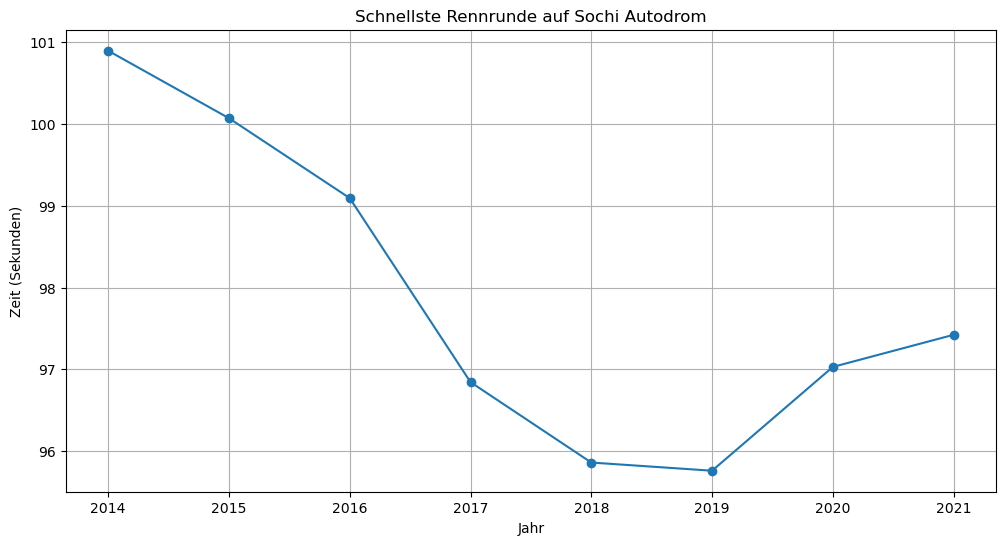

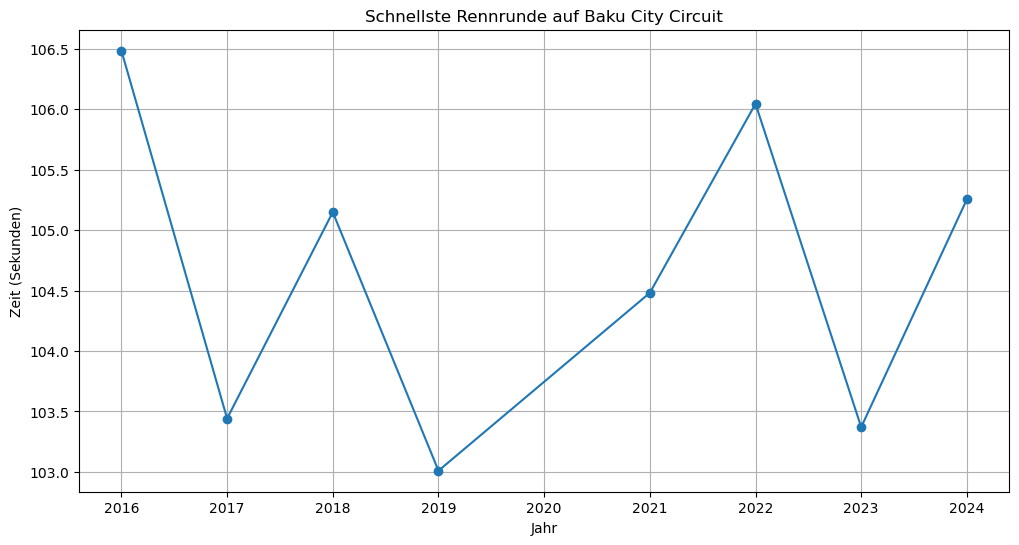

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

base_path = "f1db/"

df_circuits = pd.read_csv(base_path + "circuits.csv")
df_lap_times = pd.read_csv(base_path + "lap_times.csv")
df_races = pd.read_csv(base_path + "races.csv")

if "name" in df_circuits.columns:
    df_circuits.rename(columns={"name": "circuit_name"}, inplace=True)

# mergen der Daten (erst circuits, dann lap_times)
df = pd.merge(df_races, df_circuits, on="circuitId", how="left")
df = pd.merge(df, df_lap_times, on="raceId", how="left")

# nur relevante spalten behalten
df = df[["year", "circuit_name", "milliseconds"]]

# schnellste rundenzeiten pro jahr & strecke aggregieren
df_fastest_lap_per_year = df.groupby(["year", "circuit_name"])["milliseconds"].min().reset_index()

# filter: strecken mit weniger als 5 einträgen entfernen
df_fastest_lap_per_year = df_fastest_lap_per_year.groupby("circuit_name").filter(lambda x: len(x) > 4)

unique_circuits = df_fastest_lap_per_year["circuit_name"].unique()

# visualisierung für jede strecke über die jahre iterieren
for circuit in unique_circuits:
    circuit_data = df_fastest_lap_per_year[df_fastest_lap_per_year["circuit_name"] == circuit]
    
    plt.figure(figsize=(12, 6))
    plt.plot(circuit_data["year"], circuit_data["milliseconds"] / 1000, marker='o', linestyle="-")
    plt.title(f'Schnellste Rennrunde auf {circuit}')
    plt.xlabel("Jahr")
    plt.ylabel("Zeit (Sekunden)")
    plt.grid(True)
    plt.show()


## Analyse der schnellsten Rennrunden auf dem Circuit de Spa-Francorchamps  

Die Analyse der schnellsten Rundenzeiten auf dem Circuit de Spa-Francorchamps zeigt zwei markante Ausschläge:  

### **1998 – Das Regenchaos-Rennen**  
- **Massencrash in der ersten Runde** → Über 13 Autos kollidierten nach wenigen Sekunden.  
- **Extremregen** → Rutschige Bedingungen führten zu deutlich langsameren Rundenzeiten.  
- **Sieg für Damon Hill im Jordan** ...durch Ankommen.  
- **Folge:** Die schnellste Rennrunde lag weit über dem üblichen Niveau.  

### **2021 – Das kürzeste F1-Rennen aller Zeiten**  
- **Dauerregen führte zur Absage** → Keine echten Rennrunden, nur langsame Fahrten hinter dem Safety-Car.  
- **Offizielle "schnellste Runde" ist eine Anomalie** → Keine echten schnellen Zeiten wurden gefahren.  
- **Folge:** Ein extremer Datenpunkt in unserer Analyse, aber kein Fehler.  


## Analyse der schnellsten Rennrunden auf dem Nürburgring  

Die Entwicklung der schnellsten Rennrunden auf dem Nürburgring zeigt einen markanten Sprung zwischen **2001 und 2002**.  

### **2002 – Streckenumbau**  
- **Umbau der Streckenführung** Das „Castrol-S“ wurde durch die langsamere „Mercedes-Arena“ ersetzt.  
- **Ziel:** Mehr Überholmöglichkeiten und bessere Zuschauerfreundlichkeit.  
- **Folge:** Die Streckenlänge wurde verändert, was die Vergleichbarkeit früherer Rundenzeiten erschwert.  


### Fazit:  
**Der Sprung 2002 ist kein Fehler, sondern durch bauliche Anpassungen begründet!**  


## Hockenheimring – Veränderung der Rundenzeiten nach dem Umbau  

Die Grafik zeigt die Entwicklung der schnellsten Rennrunde auf dem **Hockenheimring** über die Jahre.  

### **Erkenntnisse:**  
- Bis **2001** war der Hockenheimring eine **Highspeed-Strecke** mit langen Geraden durch den Wald.  
- **2002:** Der **Umbau** führte zu einem drastischen Rückgang der Rundenzeiten – das Streckenlayout wurde kompakter und technischer.  
- Die Rundenzeiten sanken abrupt um etwa **30 Sekunden**, was die signifikante Verkürzung der Streckenlänge widerspiegelt.  
- Nach dem Umbau blieb die Entwicklung relativ stabil, mit kleineren Anpassungen über die Jahre.  

### **Hintergrund zum Umbau (2002):**  
- Entfernung der langen Waldgeraden → Mehr technische Passagen  
- Verkürzung der Streckenlänge von **6,8 km → 4,6 km**  
- Erhöhte Sicherheit & bessere Zuschauerfreundlichkeit  

Der Umbau hat den Hockenheimring von einer Hochgeschwindigkeitsstrecke in eine technisch anspruchsvollere Strecke mit mehr Überholmöglichkeiten verwandelt.


## Monza – Entwicklung der schnellsten Rennrunde  

Die Grafik zeigt die schnellsten Rennrunden auf dem **Autodromo Nazionale di Monza** über die Jahre.  

### **Erkenntnisse:**  
- **2008:** **Sebastian Vettel** gewinnt sensationell mit Toro Rosso bei Regen – ein Ausreißer in der Zeitreihe.  
- **2000–2002:** Anpassungen an der **Rettifilo-Schikane** Leichte Verlängerung der Rundenzeiten.  
- **2010–2015:** Schwankungen durch technische Regeländerungen (Tankstopp-Verbot, veränderte Aerodynamik).  
- **2017–2021:** Kontinuierlicher Abwärtstrend → Verbesserte Motorleistung & DRS-Optimierung.  
- **2023:** Extrem schnelle Runde möglich durch aerodynamische Anpassungen und Trockenrennen.  

### **Warum Monza so besonders ist:**  
**"Temple of Speed"** – Die schnellste Strecke im F1-Kalender  
- Kaum langsame Kurven, Fokus auf Top-Speed & wenig Abtrieb  
- Tradition seit **1921**, mit wenigen grundlegenden Änderungen. Eine der ikonischsten Strecken der Formel 1  


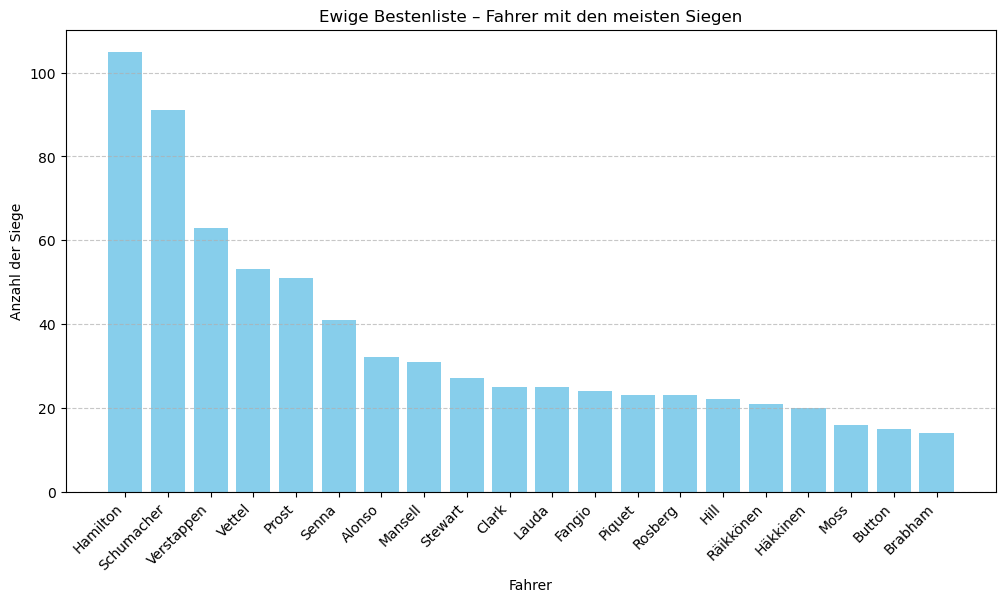

In [38]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect(db_path)

# siege pro fahrer
query = """
SELECT d.surname, COUNT(r.resultId) AS wins
FROM results r
JOIN drivers d ON r.driverId = d.driverId
WHERE r.positionOrder = 1
GROUP BY r.driverId
ORDER BY wins DESC
LIMIT 20;
"""
df_wins = pd.read_sql(query, conn)

# verbindung schließen
conn.close()

# visualisierung - top 20 Fahrer nach siegen
plt.figure(figsize=(12, 6))
plt.bar(df_wins["surname"], df_wins["wins"], color="skyblue")
plt.title("Ewige Bestenliste – Fahrer mit den meisten Siegen")
plt.xlabel("Fahrer")
plt.ylabel("Anzahl der Siege")
plt.xticks(rotation=45, ha="right")  # namen lesbar durch schräg
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.rcParams["font.family"] = "Arial"  
plt.show()


## Ewige Bestenliste – Fahrer mit den meisten Siegen

Dieser Plot zeigt die erfolgreichsten Fahrer in der Geschichte der Formel 1, gemessen an der Anzahl ihrer Rennsiege.

### **Analyse & Erkenntnisse**
- **Lewis Hamilton und Michael Schumacher** stehen mit Abstand an der Spitze der ewigen Bestenliste – zwei Legenden, die in ihren Epochen das Maß aller Dinge waren.
- **Max Verstappen** hat sich bereits früh in seiner Karriere auf Platz 3 vorgearbeitet und könnte in den kommenden Jahren noch weiter aufsteigen.
- **Sebastian Vettel, Alain Prost und Ayrton Senna** gehören zu den dominierenden Fahrern ihrer jeweiligen Ära und prägten das Bild der Formel 1 über Jahrzehnte.
- **Von Fangio bis Verstappen**: Die Liste vereint Fahrer aus allen Generationen – von den Pionieren der 1950er über die Helden der 80er und 90er bis zu den Stars der Gegenwart.
- Die **Veränderungen im Rennkalender** (mehr Rennen pro Saison) und die **technische Entwicklung** der Fahrzeuge beeinflussen die Anzahl der möglichen Siege, was frühere und heutige Erfolge nur bedingt vergleichbar macht.

Ein Blick auf diese Liste zeigt: Legenden kommen und gehen – doch ihr Vermächtnis bleibt bestehen.


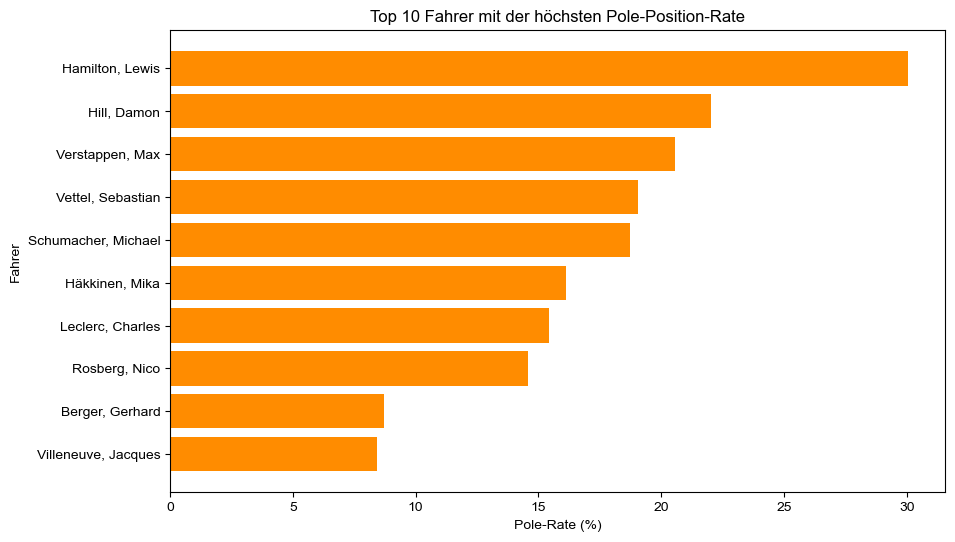

In [39]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect(db_path)

# pole-position-rate
query = """
WITH PoleCounts AS (
    SELECT driverId, COUNT(*) AS poles
    FROM qualifying
    WHERE position = 1
    GROUP BY driverId
),
QualiCounts AS (
    SELECT driverId, COUNT(*) AS starts
    FROM qualifying
    GROUP BY driverId
)
SELECT d.surname || ', ' || d.forename AS Driver, 
       (100.0 * COALESCE(pc.poles, 0) / qc.starts) AS Pole_Rate
FROM QualiCounts qc
LEFT JOIN PoleCounts pc ON qc.driverId = pc.driverId
JOIN drivers d ON qc.driverId = d.driverId
WHERE qc.starts >= 10  -- Fahrer mit mindestens 10 Qualifying-Teilnahmen
ORDER BY Pole_Rate DESC
LIMIT 10;
"""

# daten abrufen
df_pole_rates = pd.read_sql(query, conn)

conn.close()

# balkendiagramm erstellen
plt.figure(figsize=(10, 6))
plt.barh(df_pole_rates["Driver"], df_pole_rates["Pole_Rate"], color="darkorange")
plt.xlabel("Pole-Rate (%)")
plt.ylabel("Fahrer")
plt.title("Top 10 Fahrer mit der höchsten Pole-Position-Rate")
plt.gca().invert_yaxis()  # Höchste Werte oben anzeigen
plt.show()


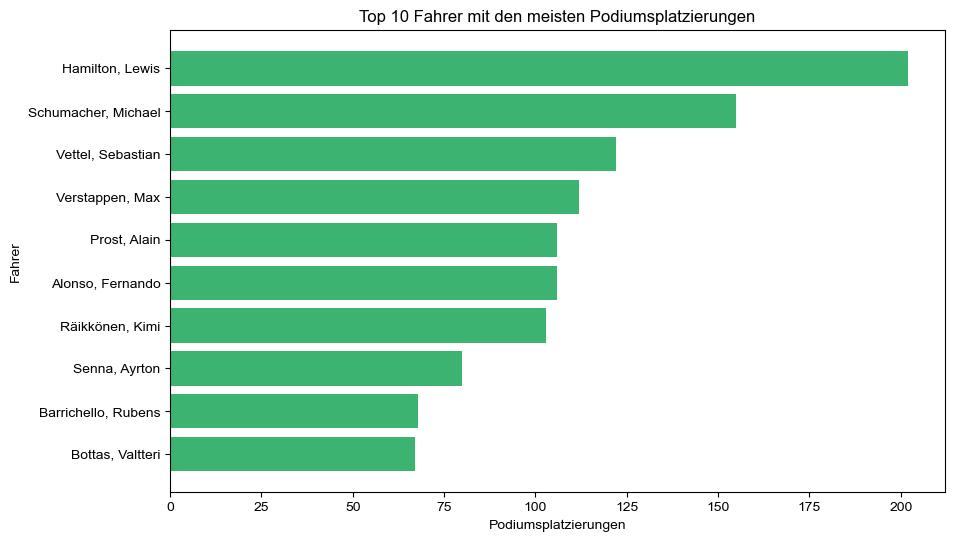

In [40]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect(db_path)

# Podiumsplatzierungen
query = """
SELECT d.surname || ', ' || d.forename AS Driver, 
       COUNT(*) AS Podiums
FROM results r
JOIN drivers d ON r.driverId = d.driverId
WHERE r.positionOrder IN (1, 2, 3)
GROUP BY r.driverId
ORDER BY Podiums DESC
LIMIT 10;
"""

df_podiums = pd.read_sql(query, conn)

conn.close()

# balkendiagramm erstellen
plt.figure(figsize=(10, 6))
plt.barh(df_podiums["Driver"], df_podiums["Podiums"], color="mediumseagreen")
plt.xlabel("Podiumsplatzierungen")
plt.ylabel("Fahrer")
plt.title("Top 10 Fahrer mit den meisten Podiumsplatzierungen")
plt.gca().invert_yaxis()  # höchste werte oben
plt.show()


In [41]:
# folgt noch einmal mit gestapelten balken

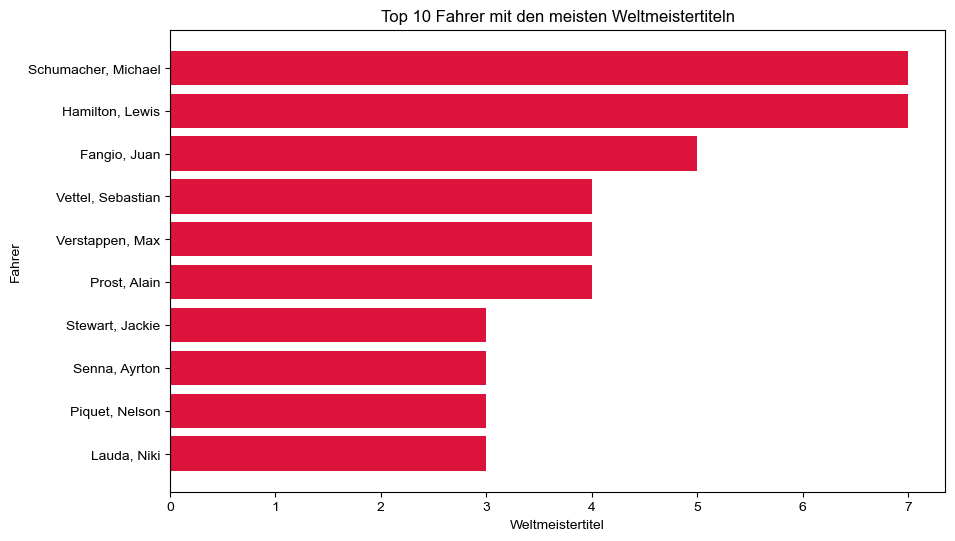


🔍 Weltmeister pro Jahr:
                Driver                           DriversChampion
0  Schumacher, Michael  1994, 1995, 2000, 2001, 2002, 2003, 2004
1      Hamilton, Lewis  2008, 2014, 2015, 2017, 2018, 2019, 2020
2         Fangio, Juan              1951, 1954, 1955, 1956, 1957
3    Vettel, Sebastian                    2010, 2011, 2012, 2013
4      Verstappen, Max                    2021, 2022, 2023, 2024
5         Prost, Alain                    1985, 1986, 1989, 1993
6      Stewart, Jackie                          1969, 1971, 1973
7        Senna, Ayrton                          1988, 1990, 1991
8       Piquet, Nelson                          1981, 1983, 1987
9          Lauda, Niki                          1975, 1977, 1984


In [42]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect(db_path)

# year als variable setzen (dynamisch ändern!)
year_filter = 1950  # startjahr für die analyse

# weltmeistertitel + weltmeister jedes jahres als neues feld
query = f"""
WITH SeasonFinalRace AS (
    SELECT year, MAX(raceId) AS last_race_id
    FROM races
    GROUP BY year
),
WorldChampions AS (
    SELECT d.driverId, d.surname || ', ' || d.forename AS Driver, r.year
    FROM driver_standings ds
    JOIN SeasonFinalRace sfr ON ds.raceId = sfr.last_race_id
    JOIN races r ON ds.raceId = r.raceId
    JOIN drivers d ON ds.driverId = d.driverId
    WHERE ds.points = (SELECT MAX(ds2.points) FROM driver_standings ds2 WHERE ds2.raceId = sfr.last_race_id)  -- Fahrer mit den meisten Punkten am Saisonende
)
SELECT wc.Driver, COUNT(wc.year) AS Championships, GROUP_CONCAT(wc.year, ', ') AS DriversChampion
FROM WorldChampions wc
GROUP BY wc.Driver
ORDER BY Championships DESC
LIMIT 10;
"""

df_champions = pd.read_sql(query, conn)

conn.close()

# balkendiagramm erstellen
plt.figure(figsize=(10, 6))
plt.barh(df_champions["Driver"], df_champions["Championships"], color="crimson")
plt.xlabel("Weltmeistertitel")
plt.ylabel("Fahrer")
plt.title("Top 10 Fahrer mit den meisten Weltmeistertiteln")
plt.gca().invert_yaxis()  # Höchste Werte oben anzeigen
plt.xticks(range(0, max(df_champions["Championships"]) + 1))  # Achsenskalierung korrigieren
plt.show()

# debug-Ausgabe für weltmeister jedes jahres
print("\n🔍 Weltmeister pro Jahr:")
print(df_champions[["Driver", "DriversChampion"]])


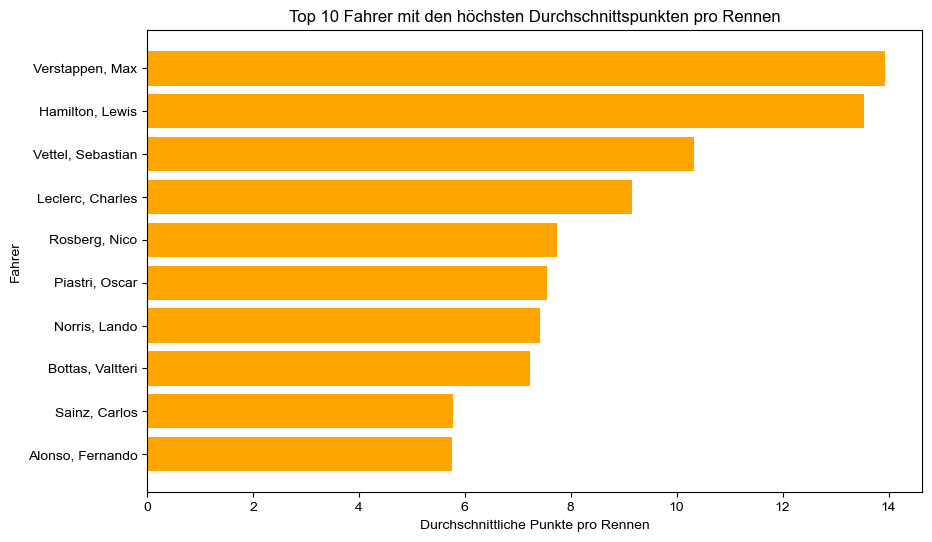

In [43]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect(db_path)

# durchschnittspunkte pro rennen
query = """
WITH PointsPerDriver AS (
    SELECT driverId, SUM(points) AS total_points, COUNT(raceId) AS race_entries
    FROM results
    GROUP BY driverId
)
SELECT d.surname || ', ' || d.forename AS Driver, 
       (ppd.total_points * 1.0 / ppd.race_entries) AS Points_Per_Entry
FROM PointsPerDriver ppd
JOIN drivers d ON ppd.driverId = d.driverId
WHERE ppd.race_entries >= 10  -- Nur Fahrer mit mindestens 10 Rennteilnahmen
ORDER BY Points_Per_Entry DESC
LIMIT 10;
"""

df_points_per_entry = pd.read_sql(query, conn)

conn.close()

# balkendiagramm erstellen
plt.figure(figsize=(10, 6))
plt.barh(df_points_per_entry["Driver"], df_points_per_entry["Points_Per_Entry"], color="orange")
plt.xlabel("Durchschnittliche Punkte pro Rennen")
plt.ylabel("Fahrer")
plt.title("Top 10 Fahrer mit den höchsten Durchschnittspunkten pro Rennen")
plt.gca().invert_yaxis()  # höchste werte oben anzeigen
plt.show()


## Die Gnade der späten Geburt – Warum fehlt Michael Schumacher?  

Die Grafik zeigt die **Top 10 Fahrer mit den höchsten Durchschnittspunkten pro Rennen**.  
Doch wo ist **Michael Schumacher**?  

### **Hintergrund: Das sich wandelnde Punktesystem**  
- Schumachers Ära (1991–2012) fiel größtenteils in eine Zeit, in der der Sieg **10 Punkte** brachte.  
- Seit **2010** gibt es das heutige System mit **25 Punkten pro Sieg**, was die Punktedurchschnitte massiv nach oben trieb.  
- Fahrer wie Verstappen und Hamilton profitieren von diesem Punktesprung.  


Farbzuweisung abgeschlossen!


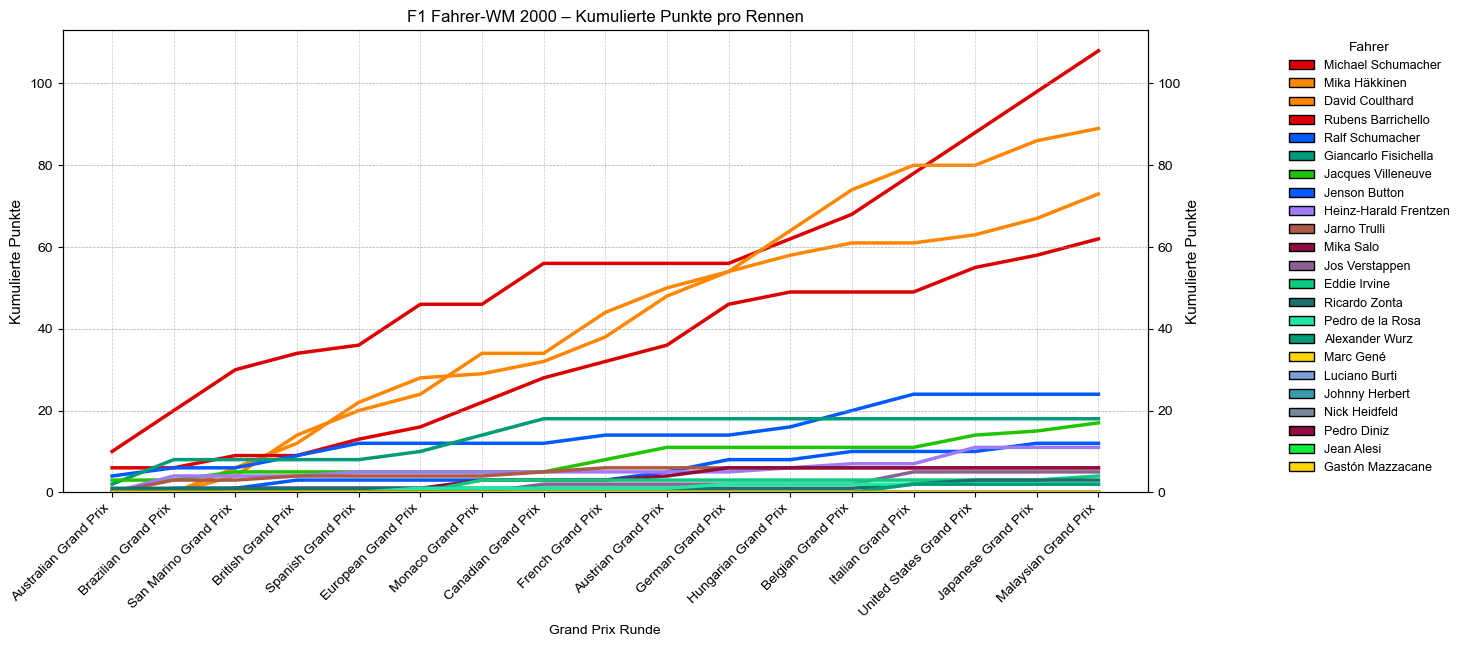

In [44]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorsys
import random
from matplotlib.patches import Patch

conn = sqlite3.connect(db_path)

# saison 2000 aus `f1season_results` abrufen
year = 2000
query = f"""
SELECT race_round, race_name, driver_unique, driver_fullname, team, cumulative_points
FROM f1season_results
WHERE year = {year}
ORDER BY race_round, driver_unique;
"""
df_year = pd.read_sql(query, conn)

conn.close()

# fahrer-sortierung nach wm-endstand
driver_final_standings = df_year.groupby("driver_unique")["cumulative_points"].max().sort_values(ascending=False)
driver_order = driver_final_standings.index.tolist()

# teamfarben explizit setzen
team_colors = {
    "McLaren": "#FF8700", "Ferrari": "#DC0000", "Mercedes": "#A0A0A0",
    "Red Bull": "#1E41FF", "Williams": "#005AFF", "Renault": "#FFD700",
    "Lotus": "#FFB400", "Brabham": "#0047AB", "Tyrrell": "#00308F",
    "Benetton": "#009B77", "Ligier": "#0055A4", "Cooper": "#006F62",
    "BRM": "#004225", "Vanwall": "#008000", "Alpine": "#0090FF",
    "Aston Martin": "#006F62", "AlphaTauri": "#2B4562", "Haas": "#B6BABD",
    "Sauber": "#900C3F", "Force India": "#FF69B4", "Spyker": "#FF4500",
    "Super Aguri": "#E4002B", "Minardi": "#FFD700", "Brawn GP": "#FFFFFF"
}

# manuelle farbzuteilung mit `driver_unique` als key
custom_palette = {driver: team_colors.get(team, "#{:06x}".format(random.randint(0, 0xFFFFFF)))
                  for driver, team in df_year.groupby("driver_unique")["team"].first().items()}

# R. Schumacher farbzuteilung
if "R. Schumacher" in custom_palette:
    custom_palette["R. Schumacher"] = team_colors["Williams"]

print("Farbzuweisung abgeschlossen!")

# grafik breiter
fig, ax1 = plt.subplots(figsize=(14, 6))  
ax2 = ax1.twinx()  # zweite y-achse

sns.lineplot(
    ax=ax1,
    data=df_year,
    x="race_round",
    y="cumulative_points",
    hue="driver_unique",
    hue_order=driver_order,
    palette=custom_palette,
    linewidth=2.5
)

# achsentitel & layout
ax1.set_xlabel("Grand Prix Runde")
ax1.set_ylabel("Kumulierte Punkte", fontsize=11)
ax2.set_ylabel("Kumulierte Punkte", fontsize=11)  # y-achse auch rechts
ax1.set_xticks(df_year["race_round"].unique())
ax1.set_xticklabels(df_year["race_name"].unique(), rotation=45, ha="right")
ax1.set_ylim(0, max(df_year["cumulative_points"]) + 5)
ax2.set_ylim(0, max(df_year["cumulative_points"]) + 5)  # **beide achsen synchronisieren
ax1.set_title(f"F1 Fahrer-WM {year} – Kumulierte Punkte pro Rennen")

# legende mit dichterem abstand zur grafik
legend_labels = df_year.drop_duplicates(subset=["driver_unique"]).set_index("driver_unique").loc[driver_order, "driver_fullname"]
legend_handles = [Patch(facecolor=custom_palette[driver], edgecolor="black", label=legend_labels[driver]) for driver in driver_order]

ax1.legend(
    handles=legend_handles,
    title="Fahrer",
    bbox_to_anchor=(1.12, 1),  # legende näher an die grafik
    loc="upper left",
    frameon=False,
    fontsize=9
)

# gitternetzlinien hinzufügen**
ax1.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)  
ax2.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)  

plt.show()


## Saisonverlauf der Formel-1-Weltmeisterschaft 2000 – Kumulierte Punkte

Dieser Plot zeigt die kumulierten Punkte der Fahrer während der gesamten Saison 2000. Er veranschaulicht, wie sich der WM-Kampf zwischen den Spitzenfahrern entwickelte und welche Fahrer im Laufe der Saison konstant punkten konnten.

### **Analyse & Erkenntnisse**
- **Schumacher vs. Häkkinen – Der Titelkampf**  
  - Michael Schumacher (rot) und Mika Häkkinen (orange) lieferten sich einen intensiven Zweikampf über die gesamte Saison hinweg.  
  - Schumachers Vorsprung wuchs in der ersten Saisonhälfte, doch durch DNFs und starke McLaren-Ergebnisse wurde der Titelkampf wieder offen.  
  - Nach den Sommer-Rennen übernahm Schumacher wieder die Führung und sicherte sich den Titel mit drei Siegen in den letzten vier Rennen.
  
- **Coulthard als beständiger Dritter**  
  - David Coulthard (dunkelorange) war konstant stark, konnte sich aber nie wirklich in den Titelkampf einmischen.

- **Ferrari vs. McLaren – Duell der alten Rivalen**  
  - Rubens Barrichello (rot-orange) sicherte Ferrari regelmäßig wertvolle Punkte, während Coulthard McLaren stabilisierte.  
  - Ferrari gewann am Ende auch die Konstrukteurswertung.

- **Umkämpftes Mittelfeld**  
  - Ralf Schumacher, Giancarlo Fisichella und Jacques Villeneuve hielten sich über die Saison hinweg unter den besten 6 Fahrern.  
  - Die ausgeprägte Dominanz von Ferrari und McLaren sorgte dafür, daß der Punkteabstand zum fünften erheblich war.

- **Hinterfeld ohne Punktechancen**  
  - Teams wie Minardi (Mazzacane, Gené) oder Prost (Alesi, Heidfeld) konnten in der Saison 2000 kaum Punkte sammeln.  
  - Selbst erfahrende Fahrer wie Jean Alesi fanden sich weit hinten wieder.

### **Fazit**
- Der Plot zeigt, dass **Schumacher durch seine Siege am Saisonende die Weltmeisterschaft gewann**,
  auch wenn Häkkinen lange Zeit mithalten konnte.  


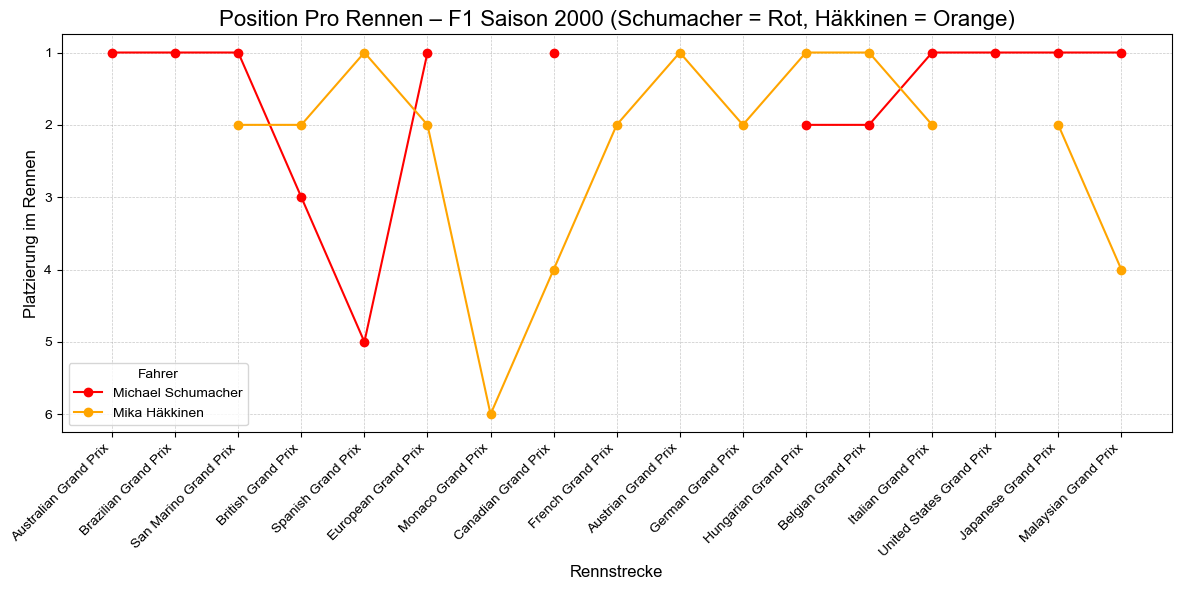

In [45]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorsys
import random
from matplotlib.patches import Patch

db_path = "data/f1db.sqlite" 
conn = sqlite3.connect(db_path)

# ergebnisse von Schumacher vs. Häkkinen in der saison 2000
query = """
SELECT 
    r.name AS circuit,
    r.round AS race_round,
    d.forename || ' ' || d.surname AS driverName,
    res.position AS positionRace
FROM results res
JOIN races r ON res.raceId = r.raceId
JOIN drivers d ON res.driverId = d.driverId
WHERE r.year = 2000
AND d.surname IN ('Schumacher', 'Häkkinen')
AND d.forename IN ('Michael', 'Mika')
ORDER BY r.round;
"""

df = pd.read_sql(query, conn)
conn.close()

# pivot-tabelle für das plotten
df_positions_debug = df.pivot(index="race_round", columns="driverName", values="positionRace")

plt.figure(figsize=(12, 6))

# farbzuordnung manuell
colors = {
    "Michael Schumacher": "red",
    "Mika Häkkinen": "orange"
}

# rennen in korrekter reihenfolge
sorted_races = df.sort_values("race_round")["circuit"].unique()

# plotten der positionen pro rennen mit festen farben
for driver in df_positions_debug.columns:
    plt.plot(sorted_races, df_positions_debug.loc[:, driver], marker="o", label=driver, color=colors.get(driver, "gray"))

# achsen und titel
plt.title("Position Pro Rennen – F1 Saison 2000 (Schumacher = Rot, Häkkinen = Orange)", fontsize=16)
plt.xlabel("Rennstrecke", fontsize=12)
plt.ylabel("Platzierung im Rennen", fontsize=12)
plt.xticks(rotation=45, ha="right")  
plt.gca().invert_yaxis()  # platz 1 oben
plt.legend(title="Fahrer")
plt.grid(True, linestyle="--", alpha=0.6)  # gitternetzlinien
plt.grid(which="both", linestyle="--", linewidth=0.5, alpha=0.7)  
plt.tight_layout()
plt.show()


## Rennplatzierungen von Michael Schumacher und Mika Häkkinen in der Saison 2000

Dieser Plot zeigt die Rennplatzierungen von Michael Schumacher (rot) und Mika Häkkinen (orange) über die gesamte Saison 2000 hinweg. Die Platzierungen pro Grand Prix verdeutlichen die Höhen und Tiefen des Titelduells.

### **Analyse & Erkenntnisse**
- **Perfekter Saisonstart für Schumacher**  
  - Schumacher gewann die ersten drei Rennen (Australien, Brasilien, San Marino) und baute früh einen Vorsprung auf.
  
- **McLaren schlägt zurück: Häkkinen holt auf**  
  - Häkkinen kam mit starken Platzierungen zurück, vor allem mit seinem ersten Saisonsieg in Spanien.
  - Schumachers Formkurve zeigte einen Knick: In Spanien und Monaco nur P5 bzw. DNF.

- **Sommerwende: Häkkinen geht in Führung**  
  - Nach dem **unglücklichen DNF von Schumacher in Hockenheim** und dem Sieg von Häkkinen in Ungarn kippte der WM-Kampf.
  - Häkkinen übernahm die Führung und schien auf dem Weg zum Titel.

- **Dramatisches Saisonfinale: Schumacher schlägt zurück**  
  - Nach Belgien lag Häkkinen knapp vorne – sein legendäres Überholmanöver gegen Schumacher in Spa war ein Schlüsselmoment.  
  - Doch Ferrari konterte: Schumacher gewann **die letzten vier Rennen in Serie (Italien, USA, Japan, Malaysia)** und sicherte sich so den WM-Titel.

### **Fazit**
- **Schumacher gewann die Meisterschaft durch seine späten Siege**, nachdem Häkkinen über den Sommer stark aufgeholt hatte.
- **DNFs spielten eine große Rolle**: Schumacher hatte Pech in Monaco und Hockenheim, während Häkkinen in Indianapolis keine Punkte holte.
- **Das letzte Renndrittel war entscheidend**: Schumachers vier Siege in Folge machten den Unterschied im WM-Kampf.

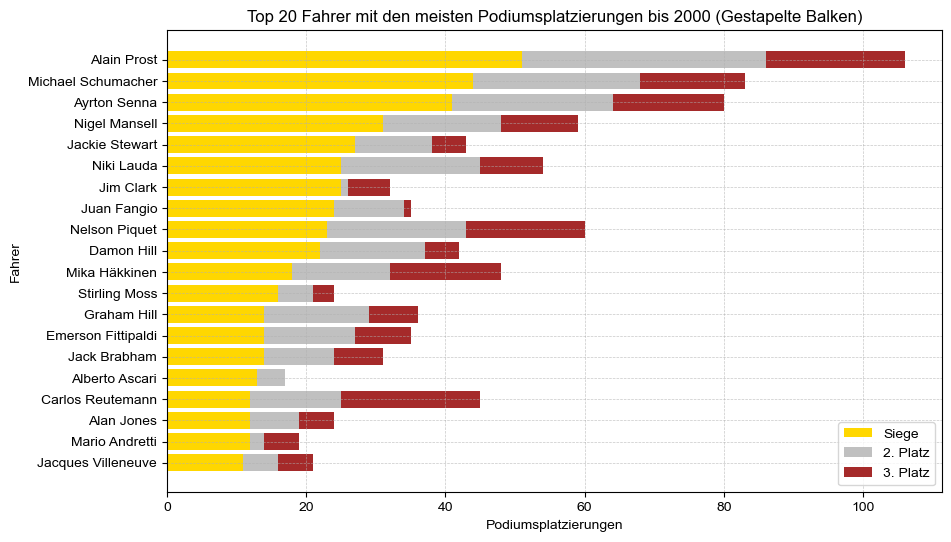

In [46]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect(db_path)

# fastest laps pro fahrer & rennen
year_filter = 2000  # Beispieljahr
query_fastest_laps = f"""
WITH FastestLaps AS (
    SELECT r.year, 
           r.name AS race_name, 
           d.forename || ' ' || d.surname AS driver_name,
           MIN(res.fastestLapTime) AS fastest_lap_time
    FROM results res
    JOIN races r ON res.raceId = r.raceId
    JOIN drivers d ON res.driverId = d.driverId
    WHERE res.fastestLapTime IS NOT NULL
      AND r.year = {year_filter}
    GROUP BY r.year, r.name, d.driverId
    ORDER BY r.year, r.name
)
SELECT * FROM FastestLaps;
"""

# podiumsplatzierungen mit separaten siegen, 2. und 3. plätzen bis zum year_filter
query_podiums = f"""
WITH PodiumFinishes AS (
    SELECT d.forename || ' ' || d.surname AS driver_name,
           COUNT(CASE WHEN res.position = 1 THEN 1 END) AS wins,
           COUNT(CASE WHEN res.position = 2 THEN 1 END) AS second_places,
           COUNT(CASE WHEN res.position = 3 THEN 1 END) AS third_places
    FROM results res
    JOIN races r ON res.raceId = r.raceId
    JOIN drivers d ON res.driverId = d.driverId
    WHERE res.position IN (1,2,3)
      AND r.year <= {year_filter}  
    GROUP BY d.driverId
    ORDER BY wins DESC, second_places DESC, third_places DESC
    LIMIT 20  
)
SELECT * FROM PodiumFinishes;
"""

# gesamtsiege pro fahrer bis year_filter
query_total_wins = f"""
WITH TotalWins AS (
    SELECT d.forename || ' ' || d.surname AS driver_name,
           COUNT(*) AS total_wins
    FROM results res
    JOIN races r ON res.raceId = r.raceId
    JOIN drivers d ON res.driverId = d.driverId
    WHERE res.position = 1
      AND r.year <= {year_filter}  
    GROUP BY d.driverId
    ORDER BY total_wins DESC
    LIMIT 20  
)
SELECT * FROM TotalWins;
"""

df_fastest_laps = pd.read_sql(query_fastest_laps, conn)
df_podiums = pd.read_sql(query_podiums, conn)
df_total_wins = pd.read_sql(query_total_wins, conn)

conn.close()

# balkendiagramm für podiumsplatzierungen
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(df_podiums["driver_name"], df_podiums["wins"], color="gold", label="Siege")
ax.barh(df_podiums["driver_name"], df_podiums["second_places"], left=df_podiums["wins"], color="silver", label="2. Platz")
ax.barh(df_podiums["driver_name"], df_podiums["third_places"], left=df_podiums["wins"] + df_podiums["second_places"], color="brown", label="3. Platz")

# achsentitel & layout
ax.set_xlabel("Podiumsplatzierungen")
ax.set_ylabel("Fahrer")
ax.set_title(f"Top 20 Fahrer mit den meisten Podiumsplatzierungen bis {year_filter} (Gestapelte Balken)")
ax.legend()
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)  
plt.gca().invert_yaxis()  # höchste werte oben
plt.show()


## Top 20 Fahrer mit den meisten Podiumsplatzierungen bis 2000

Dieser Plot zeigt die Fahrer mit den meisten Podiumsplatzierungen (1., 2. und 3. Platz) in der Formel 1 bis zum Jahr 2000. 

### **Analyse & Erkenntnisse**
- **Alain Prost, Michael Schumacher und Ayrton Senna** fühtren die Liste an und dominieren mit einer hohen Anzahl an Siegen.
- **Starke Konstanz**: Viele Fahrer in dieser Liste waren über Jahre hinweg an der Spitze des Feldes und konnten regelmäßig Podiumsplätze einfahren.
- **Legenden der frühen Jahre**: Fahrer wie **Juan Manuel Fangio, Jim Clark oder Stirling Moss** zeigen, dass auch in den Anfangsjahren der Formel 1 außergewöhnliche Konstanz möglich war. Auffällig sind vor allem die hohe Anteil von Siegen an den Podestplatzierungen bei Ascari und Fangio in den 50ern und Clark und Stewart in den 60gern.




In [47]:
conn = sqlite3.connect(db_path)

query_grid_avg = """
WITH GridStats AS (
    SELECT r.year, 
           d.forename || ' ' || d.surname AS driver_name,
           AVG(res.grid) AS avg_start_position,
           COUNT(res.raceId) AS total_races
    FROM results res
    JOIN races r ON res.raceId = r.raceId
    JOIN drivers d ON res.driverId = d.driverId
    WHERE res.grid IS NOT NULL
      AND r.year = 2000 
    GROUP BY r.year, d.driverId
    HAVING total_races >= 4          -- um one-off fahrer auszugrenzen
)
SELECT * FROM GridStats
ORDER BY avg_start_position;
"""

df_grid_avg = pd.read_sql(query_grid_avg, conn)

print("debug: Durchschnittliche Startposition 2000:")
print(df_grid_avg.head())

conn.close()


debug: Durchschnittliche Startposition 2000:
   year         driver_name  avg_start_position  total_races
0  2000  Michael Schumacher            2.000000           17
1  2000       Mika Häkkinen            2.529412           17
2  2000     David Coulthard            2.705882           17
3  2000  Rubens Barrichello            4.823529           17
4  2000        Jarno Trulli            7.529412           17


Durchschnittliche Startpositionen für 2000:
   year         driver_name  avg_start_position  total_races
0  2000  Michael Schumacher            2.000000           17
1  2000       Mika Häkkinen            2.529412           17
2  2000     David Coulthard            2.705882           17
3  2000  Rubens Barrichello            4.823529           17
4  2000        Jarno Trulli            7.529412           17


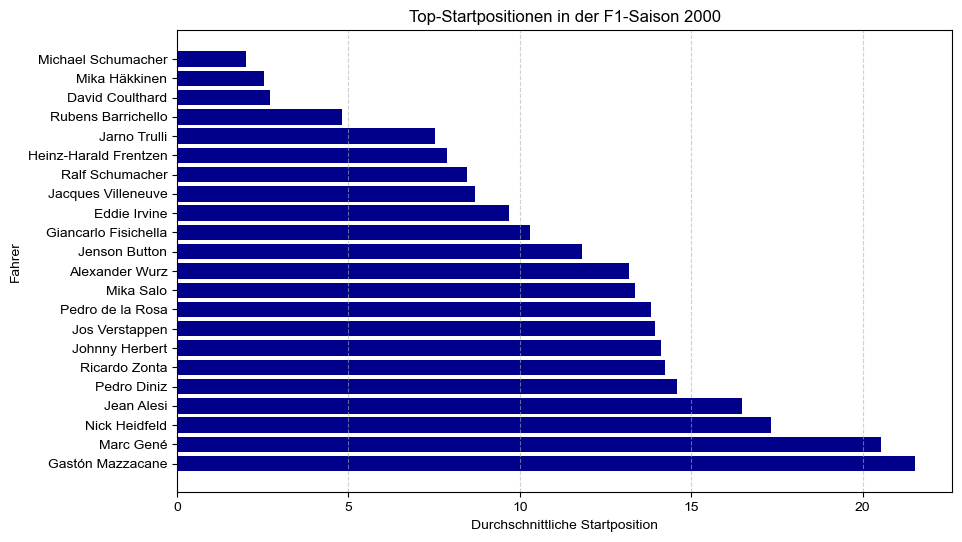

In [48]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect(db_path)

year_filter = 2000  

# durchschnittliche startposition
query_grid_avg = f"""
WITH GridStats AS (
    SELECT r.year, 
           d.forename || ' ' || d.surname AS driver_name,
           AVG(res.grid) AS avg_start_position,
           COUNT(res.raceId) AS total_races
    FROM results res
    JOIN races r ON res.raceId = r.raceId
    JOIN drivers d ON res.driverId = d.driverId
    WHERE res.grid IS NOT NULL
      AND r.year = {year_filter}
    GROUP BY r.year, d.driverId
    HAVING total_races >= 4  -- mindestens 4 rennen
)
SELECT * FROM GridStats
ORDER BY avg_start_position;
"""

df_grid_avg = pd.read_sql(query_grid_avg, conn)
conn.close()

# debug
print(f"Durchschnittliche Startpositionen für {year_filter}:")
print(df_grid_avg.head())

# visualisierung
plt.figure(figsize=(10, 6))
plt.barh(df_grid_avg["driver_name"], df_grid_avg["avg_start_position"], color="darkblue")

plt.xlabel("Durchschnittliche Startposition")
plt.ylabel("Fahrer")
plt.title(f"Top-Startpositionen in der F1-Saison {year_filter}")
plt.gca().invert_yaxis()  # beste startposition oben
plt.grid(axis="x", linestyle="--", alpha=0.6)

plt.show()


## Durchschnittliche Startpositionen in der F1-Saison 2000

Dieser Plot zeigt die durchschnittliche Startposition der Fahrer in der Formel-1-Saison 2000. Eine niedrigere Startposition bedeutet eine bessere durchschnittliche Qualifikationsleistung.

### **Analyse & Erkenntnisse**
- **Mika Häkkinen und Michael Schumacher** dominierten das Qualifying mit den besten durchschnittlichen Startpositionen – sie machen den Titel unter sich aus.
- **David Coulthard, Rubens Barrichello und Jarno Trulli** hatten ebenfalls starke Qualifying-Leistungen und platzierten sich regelmäßig in der vorderen Startreihe.
- **Gastón Mazzacane und Marc Gené, Alesi und Heidfeld** bilden meistens das Ende des Feldes, was ihre Rolle in schwächeren Teams widerspiegelt.
- **Teamduelle**: Die Startpositionen geben interessante Einblicke in teaminterne Vergleiche, z. B. Jarno Trulli vs. Heinz-Harald Frentzen
- **Bedeutung der Qualifikation**: In einer Ära ohne DRS und noch nicht so strikter Handhabungen blauer Flaggen war eine gute Startposition  entscheidend für das Rennergebnis.


🔍 Durchschnittliche Zielpositionen für 2000:
   year         driver_name  avg_race_position  total_races  dnf_count
0  2000       Mika Häkkinen           4.823529           17          3
1  2000     David Coulthard           5.176471           17          3
2  2000  Michael Schumacher           5.294118           17          4
3  2000  Rubens Barrichello           6.294118           17          4
4  2000  Jacques Villeneuve           9.529412           17          4


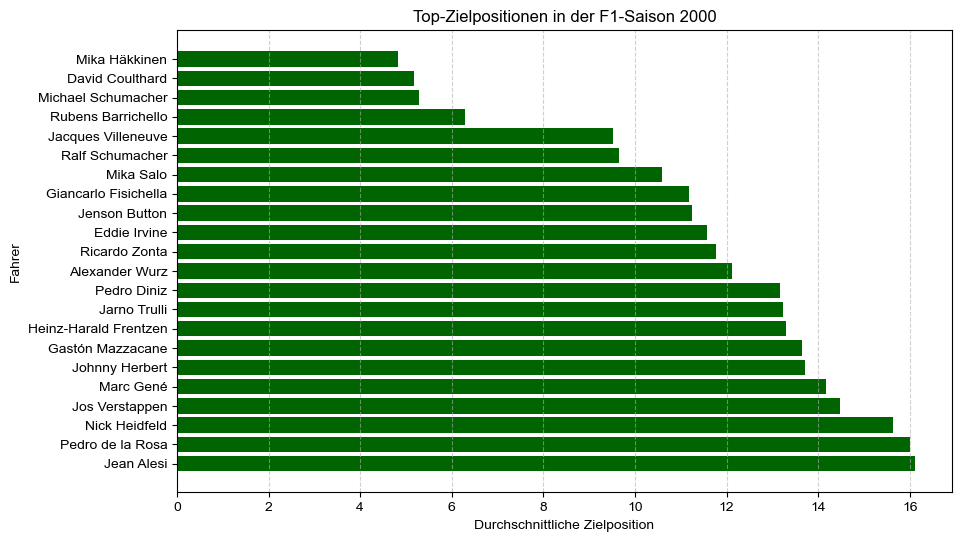

In [49]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect(db_path)

year_filter = 2000  

query_race_avg = f"""
WITH RaceStats AS (
    SELECT r.year, 
           d.forename || ' ' || d.surname AS driver_name,
           AVG(res.positionOrder) AS avg_race_position,  -- ohne DNFs
           COUNT(res.raceId) AS total_races,
           SUM(CASE WHEN res.position GLOB '[0-9]*' THEN 0 ELSE 1 END) AS dnf_count  
    FROM results res
    JOIN races r ON res.raceId = r.raceId
    JOIN drivers d ON res.driverId = d.driverId
    WHERE r.year = {year_filter}
    GROUP BY r.year, d.driverId
    HAVING total_races >= 10
)
SELECT * FROM RaceStats
ORDER BY avg_race_position ASC, dnf_count ASC;  -- erst beste zielposition, dann wenigste DNFs
"""

df_race_avg = pd.read_sql(query_race_avg, conn)
conn.close()

# debug
print(f"🔍 Durchschnittliche Zielpositionen für {year_filter}:")
print(df_race_avg.head())

# visualisierung
plt.figure(figsize=(10, 6))
plt.barh(df_race_avg["driver_name"], df_race_avg["avg_race_position"], color="darkgreen")

plt.xlabel("Durchschnittliche Zielposition")
plt.ylabel("Fahrer")
plt.title(f"Top-Zielpositionen in der F1-Saison {year_filter}")
plt.gca().invert_yaxis()  # Beste Zielposition oben
plt.grid(axis="x", linestyle="--", alpha=0.6)

plt.show()


## Durchschnittliche Zielpositionen in der F1-Saison 2000 – Warum ist Schumi nicht oben?

Dieser Plot zeigt die durchschnittlichen Zielpositionen der Fahrer in der Formel-1-Saison 2000. Überraschend ist, dass Mika Häkkinen vor Michael Schumacher liegt, obwohl Schumacher den Titel gewann.

### **Analyse & Erkenntnisse**
- **Michael Schumacher wurde trotz schlechterer durchschnittlicher Zielposition Weltmeister, da er mehr Punkte durch sehr gute Platzierungen einfuhr. Grund ist das damalige Punktesystem 10-6-4-3-2-1 für die ersten sechs Platzierungen, das bessere Platzierungen überproportional belohnte. Die durchschnittliche Position ist hier also eine irrefürende Metrik.**
- **DNFs beeinflussen die Statistik**: Schumacher hatte einige **Ausfälle (DNFs), die seinen Durchschnitt verschlechterten**
- darunter zwei entscheidende in Österreich und Hockenheim.
- **Mika Häkkinen mit besserem Durchschnitt bei weniger Siegen**: Der McLaren-Pilot hatte nach Problemen am Jahresanfang einen Lauf.
- **David Coulthard als Konstante bei McLaren**: Coulthard fuhr regelmäßig in die Top 3, konnte sich aber nie wirklich in den Titelkampf einmischen.
- **Ferrari vs. McLaren, der Rest kämpfte um Platz 3**: Barrichello als zweiter Ferrari-Pilot war konstant vorne, während das Mittelfeld mit Ralf Schumacher, Villeneuve und Fisichella stark umkämpft war.

Bester Fahrer der F1-Saison 2000:
   year         driver_name  total_races  total_points  dnf_count  dnf_loss  \
0  2000  Michael Schumacher           17         108.0          4        29   
1  2000       Mika Häkkinen           17          89.0          3        24   
2  2000     David Coulthard           17          73.0          3        14   
3  2000  Rubens Barrichello           17          62.0          4        19   
4  2000     Ralf Schumacher           17          24.0          7         5   

   base_score  extended_score  
0       108.0           137.0  
1        89.0           113.0  
2        73.0            87.0  
3        62.0            81.0  
4        24.0            29.0  


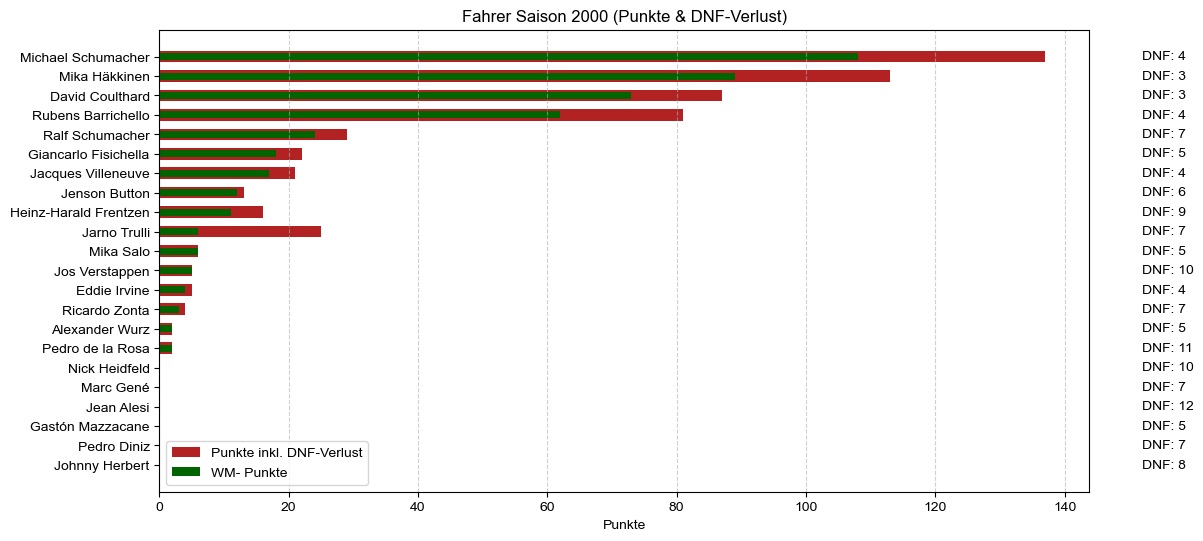

In [50]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect(db_path)


year_filter = 2000  

query_best_driver = f"""
WITH RaceStats AS (
    SELECT r.year, 
           d.forename || ' ' || d.surname AS driver_name,
           COUNT(res.raceId) AS total_races,
           SUM(res.points) AS total_points,  -- Gesamtpunkte
           SUM(CASE WHEN res.position GLOB '[0-9]*' THEN 0 ELSE 1 END) AS dnf_count,  -- DNFs 
           SUM(
               CASE 
                   WHEN res.grid = 1 THEN 10 
                   WHEN res.grid = 2 THEN 6 
                   WHEN res.grid = 3 THEN 4 
                   WHEN res.grid = 4 THEN 3 
                   WHEN res.grid = 5 THEN 2 
                   WHEN res.grid = 6 THEN 1 
                   ELSE 0 
               END * (CASE WHEN res.position GLOB '[0-9]*' THEN 0 ELSE 1 END) -- nur für DNFs zählen
           ) AS dnf_loss,  -- 'Verlorene Punkte' basierend auf Grid-Position
           SUM(res.points) AS base_score,  -- Punkte ohne DNF-Loss
           SUM(res.points) + SUM(
               CASE 
                   WHEN res.grid = 1 THEN 10 
                   WHEN res.grid = 2 THEN 6 
                   WHEN res.grid = 3 THEN 4 
                   WHEN res.grid = 4 THEN 3 
                   WHEN res.grid = 5 THEN 2 
                   WHEN res.grid = 6 THEN 1 
                   ELSE 0 
               END * (CASE WHEN res.position GLOB '[0-9]*' THEN 0 ELSE 1 END)
           ) AS extended_score  -- Punkte inklusive DNF-Loss
    FROM results res
    JOIN races r ON res.raceId = r.raceId
    JOIN drivers d ON res.driverId = d.driverId
    WHERE r.year = {year_filter}
    GROUP BY r.year, d.driverId
    HAVING total_races >= 10
)
SELECT * FROM RaceStats
ORDER BY base_score DESC;  -- nach wm-stand sortieren
"""

df_best_driver = pd.read_sql(query_best_driver, conn)
conn.close()

print(f"Bester Fahrer der F1-Saison {year_filter}:")
print(df_best_driver.head())

plt.figure(figsize=(12, 6))  
bar_width = 0.6  

# maximale punkte für die platzierung der DNFs außerhalb des plots
max_points = df_best_driver["extended_score"].max()
y_positions = range(len(df_best_driver))  # y-positionen der fahrer

# hintergrundbalken für die verlängerten punkte inkl. DNFs
plt.barh(
    y_positions, 
    df_best_driver["extended_score"], 
    color="firebrick",  # kräftigeres rot
    height=bar_width, 
    label="Punkte inkl. DNF-Verlust"
)

# vordergrundbalken für die real erreichten punkte
plt.barh(
    y_positions, 
    df_best_driver["base_score"], 
    color="darkgreen", 
    height=bar_width * 0.6,  
    label="WM- Punkte"
)

# DNFs als text außerhalb des plots
for index, value in enumerate(df_best_driver["dnf_count"]):
    plt.text(max_points + 15, index, f"DNF: {value}", va="center", fontsize=10, color="black")

plt.xlabel("Punkte")
plt.yticks(y_positions, df_best_driver["driver_name"])  # fahrer mittig setzen
plt.title(f"Fahrer Saison {year_filter} (Punkte & DNF-Verlust)")
plt.gca().invert_yaxis()  # beste fahrer oben
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.legend()

plt.show()


## DNF-Verlust und tatsächliche WM-Punkte in der F1-Saison 2000

Dieser Plot stellt die real erzielten Punkte der Fahrer in der Saison 2000 den Punkten gegenüber, die sie ohne DNFs (Did Not Finish) theoretisch hätten erreichen können. Als Metrik soll der theoretische Verlust der Punkte der Startaufstellung dienen, auf detailliertere Ausfallgründe wird nicht eingegangen.

### **Einführung: "DNF Loss" – Der verlorene Punktevorsprung durch Ausfälle**
- In der Formel 1 können **Ausfälle (DNFs)** einen erheblichen Einfluss auf die Meisterschaft haben.
- Ein **DNF bedeutet potenziellen Punkteverlust**, da ein Fahrer das Rennen nicht beendet und damit keine Punkte erhält.
- **"DNF Loss"** bezeichnet den hypothetischen Punktestand eines Fahrers, wenn alle seine Ausfälle durch eine realistische Platzierung ersetzt würden.

### **Analyse & Erkenntnisse**
- **Michael Schumacher hatte 4 DNFs, meistens von vorderen Startpositionen**
- **Mika Häkkinen hatte 3 DNFs, verlor im Verhältnis ebenso viel wertvolle Punkte**
- **Jarno Trulli schneidet in diesem Verhältnis auffällig schlecht ab: da er ein guter Qualifyer ist, kosten ihn seine DNFs besonders viele Punkte**
- **Die Schlusslichter ohne DNF-loss bilden die Fahrer, die keine Startposition in den Punkterängen erzielen konnten, trotz teils 10+ DNFs**

### **Fazit**
- **In Erinnerung blieben Barrichello und Hakkinen als Pechvögel der Saison 2000. Tatsächlich war der rechnerische Punkteverlust durch DNFs zwischen den Top 4 Fahrern relativ ausgeglichen** 
- **DNFs sind eine zentrale Variable für den WM-Kampf**, die nicht nur Pech widerspiegelt, sondern auch die Zuverlässigkeit der Teams und Fahrer.


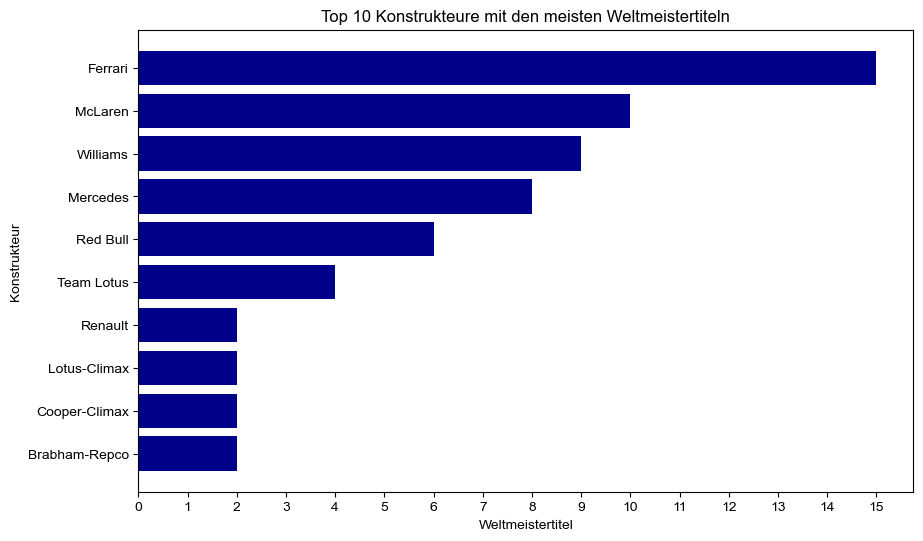


🔍 Konstrukteurs-Weltmeister pro Jahr:
     Constructor  \
0        Ferrari   
1        McLaren   
2       Williams   
3       Mercedes   
4       Red Bull   
5     Team Lotus   
6        Renault   
7   Lotus-Climax   
8  Cooper-Climax   
9  Brabham-Repco   

                                                                       ConstructorsChampion  
0  1961, 1964, 1975, 1976, 1977, 1979, 1982, 1983, 1999, 2000, 2001, 2002, 2003, 2004, 2008  
1                                1974, 1984, 1985, 1988, 1989, 1990, 1991, 1998, 2007, 2024  
2                                      1980, 1981, 1986, 1987, 1992, 1993, 1994, 1996, 1997  
3                                            2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021  
4                                                        2010, 2011, 2012, 2013, 2022, 2023  
5                                                                    1970, 1972, 1973, 1978  
6                                                                                2

In [51]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect(db_path)

year_filter = 1950  # startjahr für die analyse

# konstrukteurs-weltmeistertitel + meister pro jahr
query = f"""
WITH SeasonFinalRace AS (
    SELECT year, MAX(raceId) AS last_race_id
    FROM races
    GROUP BY year
),
ConstructorsChampions AS (
    SELECT c.constructorId, c.name AS Constructor, r.year
    FROM constructor_standings cs
    JOIN SeasonFinalRace sfr ON cs.raceId = sfr.last_race_id
    JOIN races r ON cs.raceId = r.raceId
    JOIN constructors c ON cs.constructorId = c.constructorId
    WHERE cs.points = (SELECT MAX(cs2.points) FROM constructor_standings cs2 WHERE cs2.raceId = sfr.last_race_id)  -- Konstrukteur mit den meisten Punkten am Saisonende
)
SELECT cc.Constructor, COUNT(cc.year) AS Championships, GROUP_CONCAT(cc.year, ', ') AS ConstructorsChampion
FROM ConstructorsChampions cc
GROUP BY cc.Constructor
ORDER BY Championships DESC
LIMIT 10;
"""

df_constructors = pd.read_sql(query, conn)

conn.close()

# balkendiagramm erstellen
plt.figure(figsize=(10, 6))
plt.barh(df_constructors["Constructor"], df_constructors["Championships"], color="darkblue")
plt.xlabel("Weltmeistertitel")
plt.ylabel("Konstrukteur")
plt.title("Top 10 Konstrukteure mit den meisten Weltmeistertiteln")
plt.gca().invert_yaxis()  # höchste werte oben anzeigen
plt.xticks(range(0, max(df_constructors["Championships"]) + 1))  # achsenskalierung korrigieren
plt.show()

# debug Konstrukteurs-Weltmeister jedes Jahres
print("\n🔍 Konstrukteurs-Weltmeister pro Jahr:")
print(df_constructors[["Constructor", "ConstructorsChampion"]])


## Die erfolgreichsten Konstrukteure der Formel 1

Dieser Plot zeigt die Konstrukteure mit den meisten gewonnenen Weltmeistertiteln in der Geschichte der Formel 1.

### **Analyse & Erkenntnisse**
- **Ferrari ist mit Abstand das erfolgreichste Team der Formel 1**: Der Traditionsrennstall führt mit den meisten Konstrukteurstiteln.
- **McLaren und Williams dominieren die Liste der Verfolger**, zwei britische Teams, die insbesondere in den 1980er- und 1990er-Jahren eine dominante Rolle spielten.
- **Mercedes und Red Bull haben in der modernen Ära große Erfolge gefeiert**: Beide Teams sind erst in den letzten Jahrzehnten wirklich in die Top 5 aufgestiegen.
- **Lotus, Renault und historische Teams wie Brabham oder Cooper** zeigen die Evolution der Formel 1 – viele große Namen von damals sind heute nicht mehr im Sport aktiv.
- **Die Liste reflektiert die Entwicklung der Formel 1**, von den britischen Erfolgen in den 1960er- bis 1990er-Jahren, über Ferraris Dominanz bis hin zu den modernen Serienerfolgen von Mercedes und Red Bull.

Diese Statistik zeigt nicht nur Erfolge, sondern auch den Wandel des Motorsports über Jahrzehnte.


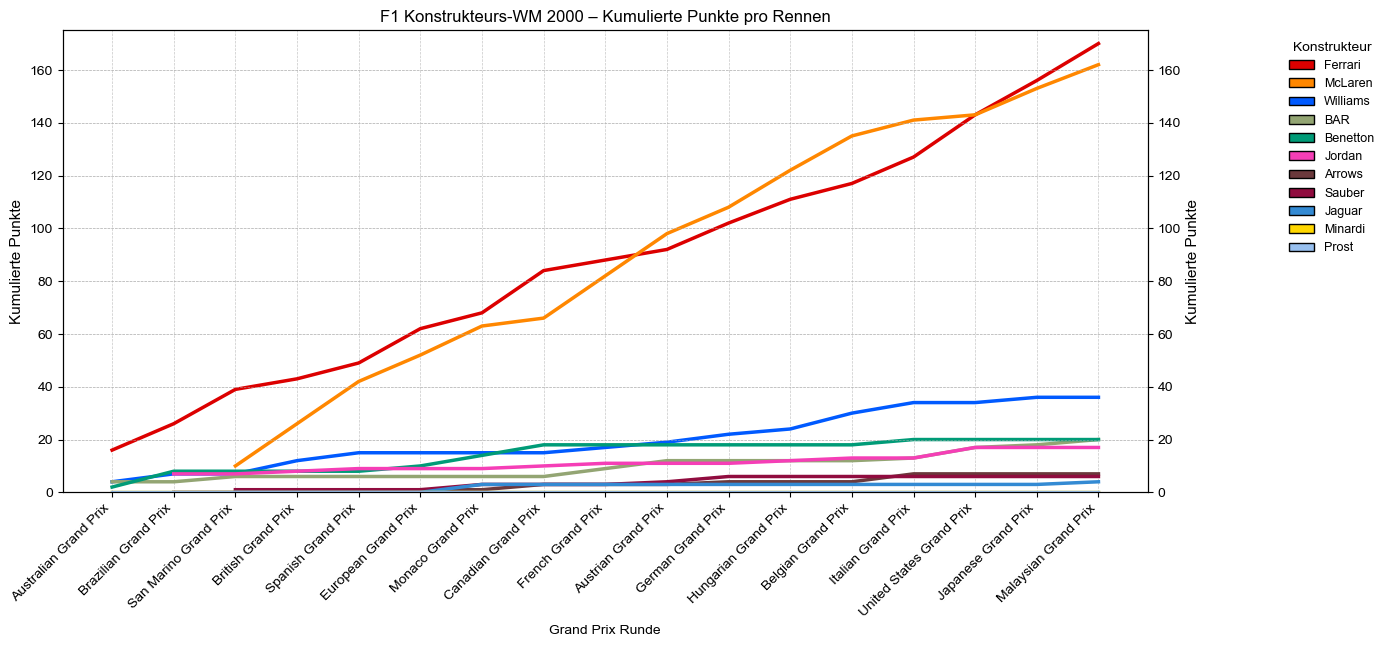

In [52]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorsys
import random
from matplotlib.patches import Patch

conn = sqlite3.connect(db_path)

year_filter = 2000

# Konstrukteurs-Punkteverlauf
query = f"""
SELECT r.round AS race_round, r.name AS race_name, c.name AS constructor_name, cs.points AS cumulative_points
FROM constructor_standings cs
JOIN races r ON cs.raceId = r.raceId
JOIN constructors c ON cs.constructorId = c.constructorId
WHERE r.year = {year_filter}
ORDER BY race_round, constructor_name;
"""

df_year = pd.read_sql(query, conn)

conn.close()

constructor_final_standings = df_year.groupby("constructor_name")["cumulative_points"].max().sort_values(ascending=False)
constructor_order = constructor_final_standings.index.tolist()

team_colors = {
    "McLaren": "#FF8700", "Ferrari": "#DC0000", "Mercedes": "#A0A0A0",
    "Red Bull": "#1E41FF", "Williams": "#005AFF", "Renault": "#FFD700",
    "Lotus": "#FFB400", "Brabham": "#0047AB", "Tyrrell": "#00308F",
    "Benetton": "#009B77", "Ligier": "#0055A4", "Cooper": "#006F62",
    "BRM": "#004225", "Vanwall": "#008000", "Alpine": "#0090FF",
    "Aston Martin": "#006F62", "AlphaTauri": "#2B4562", "Haas": "#B6BABD",
    "Sauber": "#900C3F", "Force India": "#FF69B4", "Spyker": "#FF4500",
    "Super Aguri": "#E4002B", "Minardi": "#FFD700", "Brawn GP": "#FFFFFF"
}

custom_palette = {constructor: team_colors.get(constructor, "#{:06x}".format(random.randint(0, 0xFFFFFF)))
                  for constructor in df_year["constructor_name"].unique()}

fig, ax1 = plt.subplots(figsize=(14, 6))
ax2 = ax1.twinx()

sns.lineplot(
    ax=ax1,
    data=df_year,
    x="race_round",
    y="cumulative_points",
    hue="constructor_name",
    hue_order=constructor_order,
    palette=custom_palette,
    linewidth=2.5
)

# achsentitel & layout
ax1.set_xlabel("Grand Prix Runde")
ax1.set_ylabel("Kumulierte Punkte", fontsize=11)
ax2.set_ylabel("Kumulierte Punkte", fontsize=11)
ax1.set_xticks(df_year["race_round"].unique())
ax1.set_xticklabels(df_year["race_name"].unique(), rotation=45, ha="right")
ax1.set_ylim(0, max(df_year["cumulative_points"]) + 5)
ax2.set_ylim(0, max(df_year["cumulative_points"]) + 5)
ax1.set_title(f"F1 Konstrukteurs-WM {year_filter} – Kumulierte Punkte pro Rennen")

# legende
legend_handles = [Patch(facecolor=custom_palette[constructor], edgecolor="black", label=constructor)
                  for constructor in constructor_order]
ax1.legend(
    handles=legend_handles,
    title="Konstrukteur",
    bbox_to_anchor=(1.12, 1),
    loc="upper left",
    frameon=False,
    fontsize=9
)

# gitternetzlinien hinzufügen
ax1.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
ax2.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

plt.show()


## Konstrukteurs-Weltmeisterschaft 2000 – Kumulierte Team Punkte

Dieser Plot zeigt den Saisonverlauf der Konstrukteurs-WM 2000, mit den kumulierten Punkten der Teams pro Rennen. Er veranschaulicht das Duell zwischen Ferrari und McLaren sowie die Entwicklungen im Mittelfeld.

### **Analyse & Erkenntnisse**
- **Ferrari vs. McLaren – dann lange Zeit nichts**  
  - Ferrari (rot) und McLaren (orange) dominierten die Saison und lieferten sich ein enges Kopf-an-Kopf-Rennen.  
  - Beide Teams profitierten von starken Fahrerduos: **Schumacher/Barrichello für Ferrari, Häkkinen/Coulthard für McLaren.**  
  
- **Williams als "Best of the Rest"**  
  - Williams (blau) war das drittbeste Team, konnte aber nicht annähernd mit den beiden Spitzenreitern mithalten.  
  - Das Team sammelte konstant Punkte, war aber nicht siegfähig.  

- **Stark umkämpftes Mittelfeld**  
  - Teams wie Benetton, BAR und Jordan lieferten sich einen engen Kampf um die restlichen Punkteplatzierungen.  
  - **Jordan und Benetton holten vereinzelt Podestplätze, während BAR durch Villeneuve solide abschnitt.**  

### **Fazit**
- Die starken Leistungen von Ferrari und Ferrari die gesamte Saison über sorgten für einen deutlichen Abstand zum drittplatzierten Williams


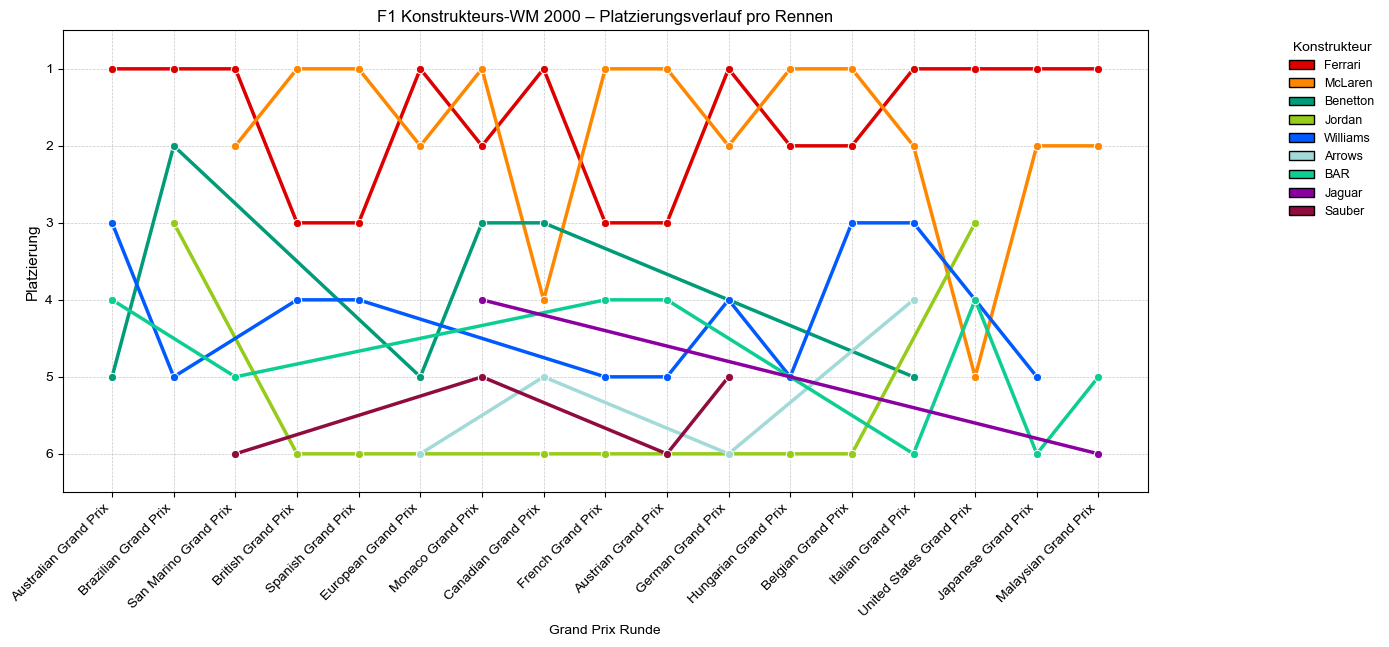

In [53]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorsys
import random
from matplotlib.patches import Patch

conn = sqlite3.connect(db_path)

year_filter = 2000

# konstrukteurs-platzierungsverlauf (alle fahrer)
query = f"""
WITH ConstructorPositions AS (
    SELECT r.round AS race_round, r.name AS race_name, c.name AS constructor_name, res.position
    FROM results res
    JOIN races r ON res.raceId = r.raceId
    JOIN constructors c ON res.constructorId = c.constructorId
    WHERE r.year = {year_filter} AND res.position <= 6
)
SELECT race_round, race_name, constructor_name, MIN(position) AS position
FROM ConstructorPositions
GROUP BY race_round, race_name, constructor_name
ORDER BY race_round, position;
"""

df_year = pd.read_sql(query, conn)

conn.close()

constructor_final_standings = df_year.groupby("constructor_name")["position"].min().sort_values()
constructor_order = constructor_final_standings.index.tolist()

team_colors = {
    "McLaren": "#FF8700", "Ferrari": "#DC0000", "Mercedes": "#A0A0A0",
    "Red Bull": "#1E41FF", "Williams": "#005AFF", "Renault": "#FFD700",
    "Lotus": "#FFB400", "Brabham": "#0047AB", "Tyrrell": "#00308F",
    "Benetton": "#009B77", "Ligier": "#0055A4", "Cooper": "#006F62",
    "BRM": "#004225", "Vanwall": "#008000", "Alpine": "#0090FF",
    "Aston Martin": "#006F62", "AlphaTauri": "#2B4562", "Haas": "#B6BABD",
    "Sauber": "#900C3F", "Force India": "#FF69B4", "Spyker": "#FF4500",
    "Super Aguri": "#E4002B", "Minardi": "#FFD700", "Brawn GP": "#FFFFFF"
}

custom_palette = {constructor: team_colors.get(constructor, "#{:06x}".format(random.randint(0, 0xFFFFFF)))
                  for constructor in df_year["constructor_name"].unique()}

fig, ax = plt.subplots(figsize=(14, 6))

sns.lineplot(
    ax=ax,
    data=df_year,
    x="race_round",
    y="position",
    hue="constructor_name",
    hue_order=constructor_order,
    palette=custom_palette,
    linewidth=2.5,
    marker="o"
)

# achsentitel & layout
ax.set_xlabel("Grand Prix Runde")
ax.set_ylabel("Platzierung", fontsize=11)
ax.set_xticks(df_year["race_round"].unique())
ax.set_xticklabels(df_year["race_name"].unique(), rotation=45, ha="right")
ax.set_ylim(6.5, 0.5)  # platz 1 oben
ax.set_title(f"F1 Konstrukteurs-WM {year_filter} – Platzierungsverlauf pro Rennen")

# legende
legend_handles = [Patch(facecolor=custom_palette[constructor], edgecolor="black", label=constructor)
                  for constructor in constructor_order]
ax.legend(
    handles=legend_handles,
    title="Konstrukteur",
    bbox_to_anchor=(1.12, 1),
    loc="upper left",
    frameon=False,
    fontsize=9
)

# gitternetzlinien
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

plt.show()


## Konstrukteurs-WM 2000 – Platzierungsverlauf pro Rennen

Dieser Plot zeigt analog zum Fahrervergleich, welches Team bei jedem Grand Prix am besten abgeschnitten hat. 

- **Ferrari vs. McLaren** → Ferrari (rot) und McLaren (orange) dominierten fast jedes Rennen, mit wechselnden Platzierungen an der Spitze.  
- **Williams als Dritter** → Williams (blau) war das beständige dritte Team, mit gelegentlichen Schwankungen.  
- **Enges Mittelfeld** → Teams wie Benetton, Jordan und BAR kämpften um die verbleibenden Punkteplätze, mit stark variierenden Ergebnissen.  


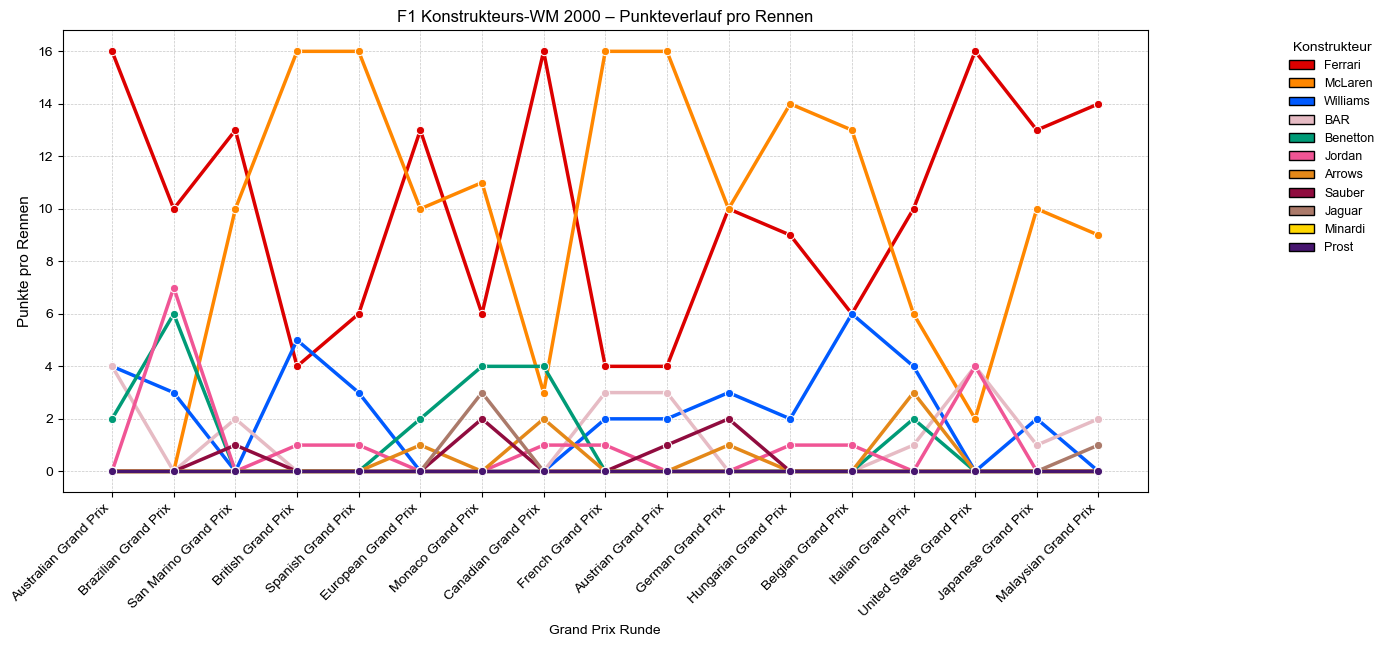

In [54]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from matplotlib.patches import Patch

conn = sqlite3.connect(db_path)

year_filter = 2000

# konstrukteurs-punkteverlauf
query = f"""
WITH ConstructorPoints AS (
    SELECT 
        r.round AS race_round, 
        r.name AS race_name, 
        c.name AS constructor_name, 
        SUM(res.points) AS team_points
    FROM results res
    JOIN races r ON res.raceId = r.raceId
    JOIN constructors c ON res.constructorId = c.constructorId
    WHERE r.year = {year_filter}
    GROUP BY r.round, r.name, c.name
)
SELECT * FROM ConstructorPoints
ORDER BY race_round, team_points DESC;
"""

df_year = pd.read_sql(query, conn)

conn.close()

constructor_final_standings = df_year.groupby("constructor_name")["team_points"].sum().sort_values(ascending=False)
constructor_order = constructor_final_standings.index.tolist()

team_colors = {
    "McLaren": "#FF8700", "Ferrari": "#DC0000", "Mercedes": "#A0A0A0",
    "Red Bull": "#1E41FF", "Williams": "#005AFF", "Renault": "#FFD700",
    "Lotus": "#FFB400", "Brabham": "#0047AB", "Tyrrell": "#00308F",
    "Benetton": "#009B77", "Ligier": "#0055A4", "Cooper": "#006F62",
    "BRM": "#004225", "Vanwall": "#008000", "Alpine": "#0090FF",
    "Aston Martin": "#006F62", "AlphaTauri": "#2B4562", "Haas": "#B6BABD",
    "Sauber": "#900C3F", "Force India": "#FF69B4", "Spyker": "#FF4500",
    "Super Aguri": "#E4002B", "Minardi": "#FFD700", "Brawn GP": "#FFFFFF"
}

custom_palette = {constructor: team_colors.get(constructor, "#{:06x}".format(random.randint(0, 0xFFFFFF)))
                  for constructor in df_year["constructor_name"].unique()}

fig, ax1 = plt.subplots(figsize=(14, 6))

sns.lineplot(
    ax=ax1,
    data=df_year,
    x="race_round",
    y="team_points",
    hue="constructor_name",
    hue_order=constructor_order,
    palette=custom_palette,
    linewidth=2.5,
    marker="o"
)

# achsentitel & layout
ax1.set_xlabel("Grand Prix Runde")
ax1.set_ylabel("Punkte pro Rennen", fontsize=11)
ax1.set_xticks(df_year["race_round"].unique())
ax1.set_xticklabels(df_year["race_name"].unique(), rotation=45, ha="right")
ax1.set_title(f"F1 Konstrukteurs-WM {year_filter} – Punkteverlauf pro Rennen")

# legende
legend_handles = [Patch(facecolor=custom_palette[constructor], edgecolor="black", label=constructor)
                  for constructor in constructor_order]
ax1.legend(
    handles=legend_handles,
    title="Konstrukteur",
    bbox_to_anchor=(1.12, 1),
    loc="upper left",
    frameon=False,
    fontsize=9
)

# gitternetzlinien
ax1.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

plt.show()


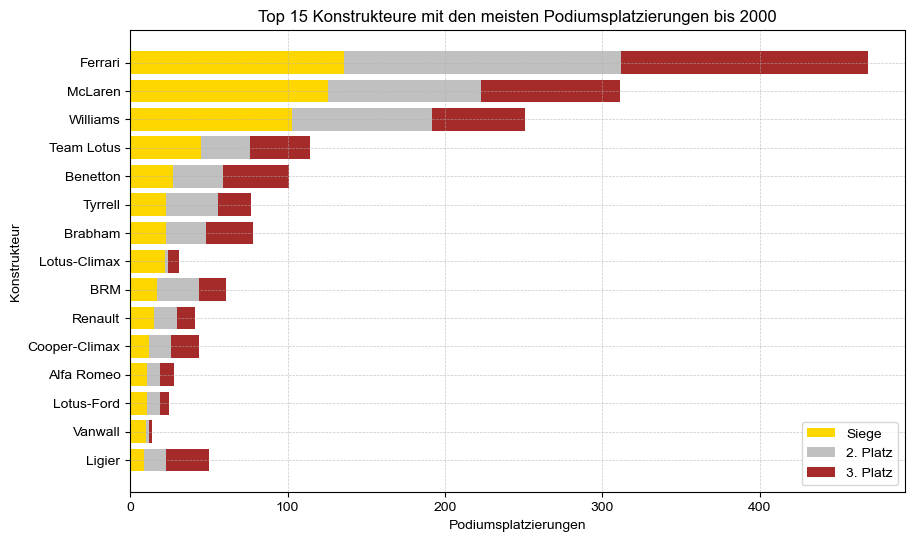

In [55]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect(db_path)

year_filter = 2000

# konstrukteurs-podiumsplatzierungen
query_podiums = f"""
WITH PodiumFinishes AS (
    SELECT c.name AS constructor_name,
           COUNT(CASE WHEN res.position = 1 THEN 1 END) AS wins,
           COUNT(CASE WHEN res.position = 2 THEN 1 END) AS second_places,
           COUNT(CASE WHEN res.position = 3 THEN 1 END) AS third_places
    FROM results res
    JOIN races r ON res.raceId = r.raceId
    JOIN constructors c ON res.constructorId = c.constructorId
    WHERE res.position IN (1,2,3)
      AND r.year <= {year_filter}  
    GROUP BY c.constructorId
    ORDER BY wins DESC, second_places DESC, third_places DESC
    LIMIT 15  
)
SELECT * FROM PodiumFinishes;
"""

df_podiums = pd.read_sql(query_podiums, conn)

conn.close()

# gestapeltes balkendiagramm für podiumsplatzierungen der konstrukteure
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(df_podiums["constructor_name"], df_podiums["wins"], color="gold", label="Siege")
ax.barh(df_podiums["constructor_name"], df_podiums["second_places"], left=df_podiums["wins"], color="silver", label="2. Platz")
ax.barh(df_podiums["constructor_name"], df_podiums["third_places"], left=df_podiums["wins"] + df_podiums["second_places"], color="brown", label="3. Platz")

# achsentitel & Layout
ax.set_xlabel("Podiumsplatzierungen")
ax.set_ylabel("Konstrukteur")
ax.set_title(f"Top 15 Konstrukteure mit den meisten Podiumsplatzierungen bis {year_filter}")
ax.legend()
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.gca().invert_yaxis()  # Höchste Werte oben anzeigen
plt.show()


## Top 15 Konstrukteure mit den meisten Podiumsplatzierungen bis 2000

Diese Grafik zeigt die erfolgreichsten Konstrukteure in der Formel-1-Geschichte bis zum Jahr 2000 anhand ihrer Podiumsplatzierungen.

- **Ferrari als Rekordhalter** → Ferrari dominiert mit den meisten Podiumsplätzen, wobei viele Siege (gelb) erkennbar sind.  
- **McLaren & Williams als Verfolger** → Beide Teams haben ebenfalls eine starke Erfolgsbilanz mit vielen Top-3-Platzierungen.  
- **Historische Größen** → Teams wie Team Lotus, Benetton oder Tyrrell waren in früheren Jahrzehnten erfolgreich.


Beste Konstrukteure der F1-Saison 2000:
  constructor_name  total_races  total_points  dnf_count  dnf_loss  \
0          Ferrari           34         170.0          8        48   
1          McLaren           34         162.0          6        38   
2         Williams           34          36.0         13         6   
3              BAR           34          20.0         11         5   
4         Benetton           34          20.0         10         4   

   base_score  extended_score  
0       170.0           218.0  
1       162.0           200.0  
2        36.0            42.0  
3        20.0            25.0  
4        20.0            24.0  


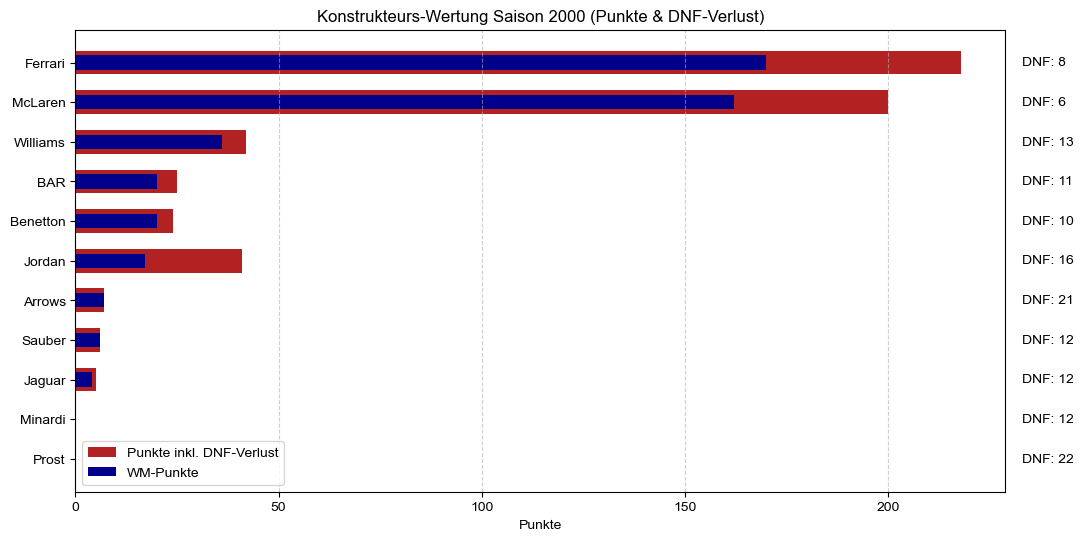

In [56]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect(db_path)

year_filter = 2000

# konstrukteurs-wertung inkl. DNF-Verlust
query_constructors = f"""
WITH ConstructorStats AS (
    SELECT c.name AS constructor_name,
           COUNT(res.raceId) AS total_races,
           SUM(res.points) AS total_points,  -- Gesamtpunkte
           SUM(CASE WHEN res.position GLOB '[0-9]*' THEN 0 ELSE 1 END) AS dnf_count,  -- DNFs 
           SUM(
               CASE 
                   WHEN res.grid = 1 THEN 10 
                   WHEN res.grid = 2 THEN 6 
                   WHEN res.grid = 3 THEN 4 
                   WHEN res.grid = 4 THEN 3 
                   WHEN res.grid = 5 THEN 2 
                   WHEN res.grid = 6 THEN 1 
                   ELSE 0 
               END * (CASE WHEN res.position GLOB '[0-9]*' THEN 0 ELSE 1 END) -- nur für DNFs zählen
           ) AS dnf_loss,  -- 'verlorene punkte' basierend auf grid-position
           SUM(res.points) AS base_score,  -- punkte ohne DNF-Loss
           SUM(res.points) + SUM(
               CASE 
                   WHEN res.grid = 1 THEN 10 
                   WHEN res.grid = 2 THEN 6 
                   WHEN res.grid = 3 THEN 4 
                   WHEN res.grid = 4 THEN 3 
                   WHEN res.grid = 5 THEN 2 
                   WHEN res.grid = 6 THEN 1 
                   ELSE 0 
               END * (CASE WHEN res.position GLOB '[0-9]*' THEN 0 ELSE 1 END)
           ) AS extended_score  -- punkte inklusive DNF-loss
    FROM results res
    JOIN races r ON res.raceId = r.raceId
    JOIN constructors c ON res.constructorId = c.constructorId
    WHERE r.year = {year_filter}
    GROUP BY r.year, c.constructorId
    HAVING total_races >= 10
)
SELECT * FROM ConstructorStats
ORDER BY base_score DESC;  -- nach wm-stand sortieren
"""

df_constructors = pd.read_sql(query_constructors, conn)
conn.close()

# debug
print(f"Beste Konstrukteure der F1-Saison {year_filter}:")
print(df_constructors.head())

# visualisierung mit balken-in-balken
plt.figure(figsize=(12, 6))
bar_width = 0.6  
max_points = df_constructors["extended_score"].max()
y_positions = range(len(df_constructors))  # y-positionen der konstrukteure

# hintergrundbalken für die verlängerten punkte inkl. DNFs
plt.barh(
    y_positions, 
    df_constructors["extended_score"], 
    color="firebrick",  # kräftigeres rot
    height=bar_width, 
    label="Punkte inkl. DNF-Verlust"
)

# vordergrundbalken für die real erreichten punkte
plt.barh(
    y_positions, 
    df_constructors["base_score"], 
    color="darkblue", 
    height=bar_width * 0.6,  
    label="WM-Punkte"
)

# DNFs als text außerhalb des plots 
for index, value in enumerate(df_constructors["dnf_count"]):
    plt.text(max_points + 15, index, f"DNF: {value}", va="center", fontsize=10, color="black")

plt.xlabel("Punkte")
plt.yticks(y_positions, df_constructors["constructor_name"])  # konstrukteure mittig
plt.title(f"Konstrukteurs-Wertung Saison {year_filter} (Punkte & DNF-Verlust)")
plt.gca().invert_yaxis()  # beste teams oben
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.legend()
plt.show()


## Konstrukteurs-Wertung 2000: DNF-Verluste & verpasste Chancen  

Die Grafik zeigt die Konstrukteurswertung der Saison **2000**, inklusive der verlorenen Punkte durch **DNFs (Did Not Finish)**.  

### **Schlüssel-Erkenntnisse:**  
**Ferrari vs. McLaren – Fast identisch**  
   - Ferrari (8 DNFs) und McLaren (6 DNFs) hatten fast gleich viele technische Ausfälle.  
   - Trotz dieser DNFs blieben sie weit vor der Konkurrenz. 

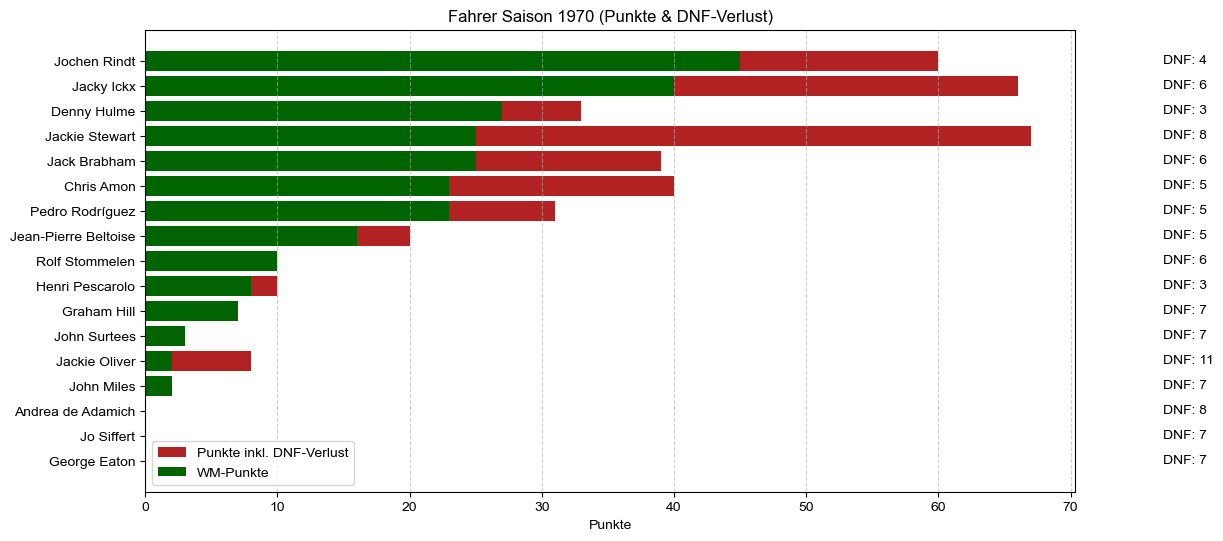

In [57]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect(db_path)

year_filter = 1970  

query_best_driver = f"""
WITH RaceStats AS (
    SELECT r.year, 
           d.forename || ' ' || d.surname AS driver_name,
           COUNT(res.raceId) AS total_races,
           SUM(res.points) AS total_points,  
           SUM(CASE WHEN res.position IS NULL THEN 1 ELSE 0 END) AS dnf_count,  
           SUM(
               CASE 
                   WHEN r.year BETWEEN 1950 AND 1959 THEN 
                        CASE res.grid WHEN 1 THEN 8 WHEN 2 THEN 6 WHEN 3 THEN 4 WHEN 4 THEN 3 WHEN 5 THEN 2 WHEN 6 THEN 1 ELSE 0 END 
                   WHEN r.year = 1960 THEN 
                        CASE res.grid WHEN 1 THEN 8 WHEN 2 THEN 6 WHEN 3 THEN 4 WHEN 4 THEN 3 WHEN 5 THEN 2 WHEN 6 THEN 1 ELSE 0 END 
                   WHEN r.year BETWEEN 1961 AND 1990 THEN 
                        CASE res.grid WHEN 1 THEN 9 WHEN 2 THEN 6 WHEN 3 THEN 4 WHEN 4 THEN 3 WHEN 5 THEN 2 WHEN 6 THEN 1 ELSE 0 END 
                   WHEN r.year BETWEEN 1991 AND 2002 THEN 
                        CASE res.grid WHEN 1 THEN 10 WHEN 2 THEN 6 WHEN 3 THEN 4 WHEN 4 THEN 3 WHEN 5 THEN 2 WHEN 6 THEN 1 ELSE 0 END 
                   WHEN r.year BETWEEN 2003 AND 2009 THEN 
                        CASE res.grid WHEN 1 THEN 10 WHEN 2 THEN 8 WHEN 3 THEN 6 WHEN 4 THEN 5 WHEN 5 THEN 4 WHEN 6 THEN 3 WHEN 7 THEN 2 WHEN 8 THEN 1 ELSE 0 END 
                   WHEN r.year BETWEEN 2010 AND 2018 THEN 
                        CASE res.grid WHEN 1 THEN 25 WHEN 2 THEN 18 WHEN 3 THEN 15 WHEN 4 THEN 12 WHEN 5 THEN 10 WHEN 6 THEN 8 WHEN 7 THEN 6 WHEN 8 THEN 4 WHEN 9 THEN 2 WHEN 10 THEN 1 ELSE 0 END 
                   WHEN r.year >= 2019 THEN 
                        CASE res.grid WHEN 1 THEN 25 WHEN 2 THEN 18 WHEN 3 THEN 15 WHEN 4 THEN 12 WHEN 5 THEN 10 WHEN 6 THEN 8 WHEN 7 THEN 6 WHEN 8 THEN 4 WHEN 9 THEN 2 WHEN 10 THEN 1 ELSE 0 END 
                   ELSE 0
               END * (CASE WHEN res.position IS NULL THEN 1 ELSE 0 END)
           ) AS dnf_loss,  
           SUM(res.points) AS base_score,  
           SUM(res.points) + SUM(
               CASE 
                   WHEN r.year BETWEEN 1950 AND 1959 THEN 
                        CASE res.grid WHEN 1 THEN 8 WHEN 2 THEN 6 WHEN 3 THEN 4 WHEN 4 THEN 3 WHEN 5 THEN 2 WHEN 6 THEN 1 ELSE 0 END 
                   WHEN r.year = 1960 THEN 
                        CASE res.grid WHEN 1 THEN 8 WHEN 2 THEN 6 WHEN 3 THEN 4 WHEN 4 THEN 3 WHEN 5 THEN 2 WHEN 6 THEN 1 ELSE 0 END 
                   WHEN r.year BETWEEN 1961 AND 1990 THEN 
                        CASE res.grid WHEN 1 THEN 9 WHEN 2 THEN 6 WHEN 3 THEN 4 WHEN 4 THEN 3 WHEN 5 THEN 2 WHEN 6 THEN 1 ELSE 0 END 
                   WHEN r.year BETWEEN 1991 AND 2002 THEN 
                        CASE res.grid WHEN 1 THEN 10 WHEN 2 THEN 6 WHEN 3 THEN 4 WHEN 4 THEN 3 WHEN 5 THEN 2 WHEN 6 THEN 1 ELSE 0 END 
                   WHEN r.year BETWEEN 2003 AND 2009 THEN 
                        CASE res.grid WHEN 1 THEN 10 WHEN 2 THEN 8 WHEN 3 THEN 6 WHEN 4 THEN 5 WHEN 5 THEN 4 WHEN 6 THEN 3 WHEN 7 THEN 2 WHEN 8 THEN 1 ELSE 0 END 
                   WHEN r.year BETWEEN 2010 AND 2018 THEN 
                        CASE res.grid WHEN 1 THEN 25 WHEN 2 THEN 18 WHEN 3 THEN 15 WHEN 4 THEN 12 WHEN 5 THEN 10 WHEN 6 THEN 8 WHEN 7 THEN 6 WHEN 8 THEN 4 WHEN 9 THEN 2 WHEN 10 THEN 1 ELSE 0 END 
                   WHEN r.year >= 2019 THEN 
                        CASE res.grid WHEN 1 THEN 25 WHEN 2 THEN 18 WHEN 3 THEN 15 WHEN 4 THEN 12 WHEN 5 THEN 10 WHEN 6 THEN 8 WHEN 7 THEN 6 WHEN 8 THEN 4 WHEN 9 THEN 2 WHEN 10 THEN 1 ELSE 0 END 
                   ELSE 0
               END * (CASE WHEN res.position IS NULL THEN 1 ELSE 0 END)
           ) AS extended_score  
    FROM results res
    JOIN races r ON res.raceId = r.raceId
    JOIN drivers d ON res.driverId = d.driverId
    WHERE r.year = {year_filter}
    GROUP BY r.year, d.driverId
    HAVING total_races >= 10
)
SELECT * FROM RaceStats
ORDER BY base_score DESC;
"""

df_best_driver = pd.read_sql(query_best_driver, conn)
conn.close()

# visualisierung mit durchgehenden balken
plt.figure(figsize=(12, 6))
bar_width = 0.8
y_positions = range(len(df_best_driver))
plt.barh(y_positions, df_best_driver["extended_score"], color="firebrick", height=bar_width, label="Punkte inkl. DNF-Verlust")
plt.barh(y_positions, df_best_driver["base_score"], color="darkgreen", height=bar_width, label="WM-Punkte")
for index, value in enumerate(df_best_driver["dnf_count"]):
    plt.text(df_best_driver["extended_score"].max() + 10, index, f"DNF: {value}", va="center", fontsize=10, color="black")
plt.xlabel("Punkte")
plt.yticks(y_positions, df_best_driver["driver_name"])
plt.title(f"Fahrer Saison {year_filter} (Punkte & DNF-Verlust)")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.legend()
plt.show()

## Fahrerwertung 1970: Die Bedeutung von DNFs in der Vergangenheit  

Die Grafik zeigt die Fahrerwertung der Saison **1970**, inklusive der verlorenen Punkte durch **DNFs**.  

### **Schlüssel-Erkenntnisse:**  
**Jochen Rindt – Tragischer Champion mit relativer Zuverlässigkeit**  
   - **Nur 4 DNFs** – im Vergleich zu anderen Fahrern relativ zuverlässig.  
   
**Jackie Stewart – Extrem viele DNFs**  
   - **8 DNFs**, aber hätte mit weniger Ausfällen **locker um den Titel mitkämpfen können**.  
   - **Beispiel für das Problem der 70er:** Leistung allein reichte nicht – **die Technik musste halten.**  

**Jack Brabham & Chris Amon – Verlorene Chancen**  
   - **DNF-Verlust fast so hoch wie ihre realen Punkte.**  
   - Hätten beide durch Zuverlässigkeit ein deutlich besseres Saisonergebnis erzielt.  

**Rennen als Lotterie – Hohe Ausfallquoten**  
   - Selbst Top-Fahrer wie **Jacky Ickx (6 DNFs), Pedro Rodríguez (5 DNFs) und Jean-Pierre Beltoise (5 DNFs)** verloren wertvolle Punkte.  
   - **Viele Fahrer schieden fast die Hälfte der Rennen aus.**  

### **Fazit:**  
In den 1970ern war ein erfolgreiches Jahr nicht nur **eine Frage des Talents**, sondern vor allem **der Technik**.  
Ein schneller Fahrer konnte nur gewinnen, wenn sein Auto durchhielt – das erklärt auch, warum einige große Talente, zb Chris Amon, oft leer ausgingen.  


## URLS, Team Colors und Master Query 


In [58]:
import os
print(os.listdir("f1db/"))  


['circuits.csv', 'circuits_urls_de.csv', 'constructors.csv', 'constructors_urls_de.csv', 'constructor_results.csv', 'constructor_standings.csv', 'drivers.csv', 'drivers_urls_de.csv', 'driver_standings.csv', 'lap_times.csv', 'pit_stops.csv', 'qualifying.csv', 'races.csv', 'races_urls_de.csv', 'results.csv', 'seasons.csv', 'seasons_urls_de.csv', 'sprint_results.csv', 'status.csv']


In [59]:
import sqlite3
import pandas as pd
import os

base_path = "f1db/"

db_path = "data/f1db.sqlite"
conn = sqlite3.connect(db_path)

csv_files = [
    "drivers_urls_de.csv",
    "constructors_urls_de.csv",
    "races_urls_de.csv",
    "circuits_urls_de.csv",
    "seasons_urls_de.csv"
]

for csv_file in csv_files:
    table_name = csv_file.replace(".csv", "")  
    file_path = os.path.join(base_path, csv_file)

    if os.path.exists(file_path):  
        try:
            df = pd.read_csv(file_path)  
            df.to_sql(table_name, conn, if_exists="replace", index=False)
            print(f"Tabelle '{table_name}' importiert!")
        except Exception as e:
            print(f"Fehler beim Import von {file_path}: {e}")
    else:
        print(f"Datei nicht gefunden: {file_path}")

# verbindung schließen
conn.close()
print("Wikipedia-URLs in SQLite gespeichert!")


Tabelle 'drivers_urls_de' importiert!
Tabelle 'constructors_urls_de' importiert!
Tabelle 'races_urls_de' importiert!
Tabelle 'circuits_urls_de' importiert!
Tabelle 'seasons_urls_de' importiert!
Wikipedia-URLs in SQLite gespeichert!


In [60]:
import sqlite3

conn = sqlite3.connect(db_path)
cursor = conn.cursor()

cursor.execute("DROP TABLE IF EXISTS team_colors;")

# neue tabelle `team_colors` anlegen
cursor.execute("""
CREATE TABLE team_colors (
    team TEXT PRIMARY KEY,
    color TEXT
);
""")

# teamfarben
team_colors = [
    ("McLaren", "#FF8700"),
    ("Ferrari", "#DC0000"),
    ("Mercedes", "#A0A0A0"),
    ("Red Bull", "#1E41FF"),
    ("Williams", "#005AFF"),
    ("Renault", "#FFD700"),
    ("Lotus", "#FFB400"),
    ("Brabham", "#0047AB"),
    ("Tyrrell", "#00308F"),
    ("Benetton", "#009B77"),
    ("Ligier", "#0055A4"),
    ("Cooper", "#006F62"),
    ("BRM", "#004225"),
    ("Vanwall", "#008000"),
    ("Alpine", "#0090FF"),
    ("Aston Martin", "#006F62"),
    ("AlphaTauri", "#2B4562"),
    ("Haas", "#B6BABD"),
    ("Sauber", "#900C3F"),
    ("Force India", "#FF69B4"),
    ("Spyker", "#FF4500"),
    ("Super Aguri", "#E4002B"),
    ("Minardi", "#FFD700"),
    ("Brawn GP", "#FFFFFF")
]

# daten einfügen
cursor.executemany("INSERT INTO team_colors (team, color) VALUES (?, ?);", team_colors)

# änderungen speichern & Verbindung schließen
conn.commit()
conn.close()

print("`team_colors` in `f1db.sqlite` gespeichert!")


`team_colors` in `f1db.sqlite` gespeichert!


In [61]:
#debg mq1
import sqlite3
import pandas as pd

# Verbindung zur SQLite-Datenbank herstellen
db_path = "data/f1db.sqlite"
conn = sqlite3.connect(db_path)

# Master-SQL-Query ausführen
query = """
WITH base_results AS (
    SELECT
        res.raceId,
        r.year,
        r.name AS race_name,
        r.round AS race_round,
        d.driverId AS driver_id,
        d.forename || ' ' || d.surname AS driver_fullname,
        substr(d.forename, 1, 1) || '. ' || d.surname AS driver_unique,
        d.code AS driver_code,  
        d.nationality AS driver_nationality,
        c.name AS team_name,
        COALESCE(tc.color, "#808080") AS team_color,
        res.points AS race_points,
        res.position AS race_position,
        res.number AS driver_number,
        res.grid AS start_position,
        res.laps,
        res.milliseconds,
        res.time AS race_time,
        res.rank AS race_rank,
        res.fastestLap,
        res.fastestLapTime,
        res.fastestLapSpeed,
        res.statusId AS status_id,
        du.url AS drivers_wikipedia_url_de,
        cu.url AS constructors_wikipedia_url_de,
        ru.url AS races_wikipedia_url_de,
        ciru.url AS circuits_wikipedia_url_de,
        seu.url AS seasons_wikipedia_url_de,
                -- DNF-loss
        (
            CASE 
                WHEN r.year BETWEEN 1950 AND 1959 THEN 
                    CASE res.grid 
                        WHEN 1 THEN 8 WHEN 2 THEN 6 WHEN 3 THEN 4 WHEN 4 THEN 3 
                        WHEN 5 THEN 2 WHEN 6 THEN 1 ELSE 0 
                    END 
                WHEN r.year = 1960 THEN 
                    CASE res.grid 
                        WHEN 1 THEN 8 WHEN 2 THEN 6 WHEN 3 THEN 4 WHEN 4 THEN 3 
                        WHEN 5 THEN 2 WHEN 6 THEN 1 ELSE 0 
                    END 
                WHEN r.year BETWEEN 1961 AND 1990 THEN 
                    CASE res.grid 
                        WHEN 1 THEN 9 WHEN 2 THEN 6 WHEN 3 THEN 4 WHEN 4 THEN 3 
                        WHEN 5 THEN 2 WHEN 6 THEN 1 ELSE 0 
                    END 
                WHEN r.year BETWEEN 1991 AND 2002 THEN 
                    CASE res.grid 
                        WHEN 1 THEN 10 WHEN 2 THEN 6 WHEN 3 THEN 4 WHEN 4 THEN 3 
                        WHEN 5 THEN 2 WHEN 6 THEN 1 ELSE 0 
                    END 
                WHEN r.year BETWEEN 2003 AND 2009 THEN 
                    CASE res.grid 
                        WHEN 1 THEN 10 WHEN 2 THEN 8 WHEN 3 THEN 6 WHEN 4 THEN 5 
                        WHEN 5 THEN 4 WHEN 6 THEN 3 WHEN 7 THEN 2 WHEN 8 THEN 1 ELSE 0 
                    END 
                WHEN r.year BETWEEN 2010 AND 2018 THEN 
                    CASE res.grid 
                        WHEN 1 THEN 25 WHEN 2 THEN 18 WHEN 3 THEN 15 WHEN 4 THEN 12 
                        WHEN 5 THEN 10 WHEN 6 THEN 8 WHEN 7 THEN 6 WHEN 8 THEN 4 
                        WHEN 9 THEN 2 WHEN 10 THEN 1 ELSE 0 
                    END 
                WHEN r.year BETWEEN 2019 AND 2023 THEN 
                    CASE res.grid 
                        WHEN 1 THEN 25 WHEN 2 THEN 18 WHEN 3 THEN 15 WHEN 4 THEN 12 
                        WHEN 5 THEN 10 WHEN 6 THEN 8 WHEN 7 THEN 6 WHEN 8 THEN 4 
                        WHEN 9 THEN 2 WHEN 10 THEN 1 ELSE 0 
                    END 
                ELSE 0  -- fallback für alle anderen Jahre
            END * (CASE WHEN res.position IS NULL THEN 1 ELSE 0 END)
        ) AS dnf_loss,
        -- berechnete felder
        CASE WHEN res.position = 1 THEN 1 ELSE 0 END AS race_wins,
        CASE WHEN res.position <= 3 THEN 1 ELSE 0 END AS podiums,
        CASE WHEN res.grid = 1 THEN 1 ELSE 0 END AS pole_positions,
        CASE WHEN res.position IS NULL THEN 1 ELSE 0 END AS dnf_count,
        res.position - res.grid AS grid_difference,
        -- zeit in Sekunden
        CAST(res.time AS FLOAT) / 1000 AS race_time_seconds,

        -- gesamt-renndauer in minuten
        CAST(res.time AS FLOAT) / 60000 AS race_duration_minutes,

        -- zeitdifferenz zum sieger
        CASE 
            WHEN res.position = 1 THEN 0 
            ELSE CAST(res.time AS FLOAT) - 
                FIRST_VALUE(CAST(res.time AS FLOAT)) OVER (PARTITION BY res.raceId ORDER BY res.position)
        END AS gap_to_winner,

        -- durchschnittliche rundenzeit
        CASE 
            WHEN res.laps > 0 THEN CAST(res.time AS FLOAT) / res.laps 
            ELSE NULL 
            END AS average_lap_time,
        -- Berechnung der Startnummer (direkt aus `results`)
        res.number AS driver_number,

        -- startplatz aus `results`
        res.grid AS start_position,

        res.fastestLap,
        res.fastestLapTime,
        res.fastestLapSpeed,

        -- position im ziel
        res.rank AS race_rank,

            
        -- dynamisches punktesystem
        CASE 
            WHEN r.year BETWEEN 1950 AND 1959 OR r.year = 1960 THEN 
                CASE res.position
                    WHEN 1 THEN 8 WHEN 2 THEN 6 WHEN 3 THEN 4 WHEN 4 THEN 3 
                    WHEN 5 THEN 2 WHEN 6 THEN 1 ELSE 0 END 
            WHEN r.year BETWEEN 1961 AND 1990 THEN 
                CASE res.position
                    WHEN 1 THEN 9 WHEN 2 THEN 6 WHEN 3 THEN 4 WHEN 4 THEN 3 
                    WHEN 5 THEN 2 WHEN 6 THEN 1 ELSE 0 END 
            WHEN r.year BETWEEN 1991 AND 2002 THEN 
                CASE res.position
                    WHEN 1 THEN 10 WHEN 2 THEN 6 WHEN 3 THEN 4 WHEN 4 THEN 3 
                    WHEN 5 THEN 2 WHEN 6 THEN 1 ELSE 0 END 
            WHEN r.year BETWEEN 2003 AND 2009 THEN 
                CASE res.position
                    WHEN 1 THEN 10 WHEN 2 THEN 8 WHEN 3 THEN 6 WHEN 4 THEN 5 
                    WHEN 5 THEN 4 WHEN 6 THEN 3 WHEN 7 THEN 2 WHEN 8 THEN 1 ELSE 0 END 
            WHEN r.year BETWEEN 2010 AND 2018 THEN 
                CASE res.position
                    WHEN 1 THEN 25 WHEN 2 THEN 18 WHEN 3 THEN 15 WHEN 4 THEN 12 
                    WHEN 5 THEN 10 WHEN 6 THEN 8 WHEN 7 THEN 6 WHEN 8 THEN 4 
                    WHEN 9 THEN 2 WHEN 10 THEN 1 ELSE 0 END 
            WHEN r.year >= 2019 THEN 
                CASE res.position
                    WHEN 1 THEN 25 WHEN 2 THEN 18 WHEN 3 THEN 15 WHEN 4 THEN 12 
                    WHEN 5 THEN 10 WHEN 6 THEN 8 WHEN 7 THEN 6 WHEN 8 THEN 4 
                    WHEN 9 THEN 2 WHEN 10 THEN 1 ELSE 0 END 
                + CASE WHEN res.fastestLap = 1 AND res.position <= 10 THEN 1 ELSE 0 END 
            ELSE 0 
        END AS adjusted_race_points,
        -- normalisierte punkte (auf aktuelles system)
        CASE 
            WHEN res.position = 1 THEN 25
            WHEN res.position = 2 THEN 18
            WHEN res.position = 3 THEN 15
            WHEN res.position = 4 THEN 12
            WHEN res.position = 5 THEN 10
            WHEN res.position = 6 THEN 8
            WHEN res.position = 7 THEN 6
            WHEN res.position = 8 THEN 4
            WHEN res.position = 9 THEN 2
            WHEN res.position = 10 THEN 1
            ELSE 0
        END + CASE WHEN res.fastestLap = 1 AND res.position <= 10 THEN 1 ELSE 0 END AS normalized_points,
                
        d.driverRef AS driver_reference,
        c.constructorRef AS constructor_reference,
        c.nationality AS constructor_nationality,
        ci.name AS circuit_name,
        ci.location AS circuit_location,
        ci.country AS circuit_country,
        ci.lat AS circuit_latitude,
        ci.lng AS circuit_longitude,
        ci.alt AS circuit_altitude

    FROM results res
    JOIN races r ON res.raceId = r.raceId  
    JOIN drivers d ON res.driverId = d.driverId
    JOIN constructors c ON res.constructorId = c.constructorId
    LEFT JOIN team_colors tc ON c.name = tc.team
    JOIN circuits ci ON r.circuitId = ci.circuitId
    LEFT JOIN drivers_urls_de du ON d.driverId = du.driverId
    LEFT JOIN constructors_urls_de cu ON c.constructorId = cu.constructorId
    LEFT JOIN races_urls_de ru ON r.raceId = ru.raceId
    LEFT JOIN circuits_urls_de ciru ON r.circuitId = ciru.circuitId
    LEFT JOIN seasons_urls_de seu ON r.year = seu.year
), 

career_driver_stats AS (    
    SELECT 
        d.driverId AS driver_id,
        d.surname || ', ' || d.forename AS stats_driver_name,
        MIN(r.year) || '-' || MAX(r.year) AS active_seasons,  
        r.year,
        COUNT(DISTINCT ds.raceId) AS total_race_entries,  
        COUNT(CASE WHEN b.start_position IS NOT NULL THEN 1 ELSE 0 END) AS total_race_starts,
        COUNT(CASE WHEN b.start_position = 1 THEN 1 ELSE 0 END) AS total_pole_positions,
        COUNT(CASE WHEN b.race_position = 1 THEN 1 ELSE 0 END) AS total_race_wins,
        COUNT(CASE WHEN b.race_position <= 3 THEN 1 ELSE 0 END) AS total_podiums,
        COUNT(CASE WHEN b.fastestLap = 1 THEN 1 ELSE 0 END) AS total_fastest_laps,  
        SUM(ds.points) AS career_total_points,
        CASE 
            WHEN r.year = (SELECT MAX(year) FROM races) THEN 'Yes' 
            ELSE 'No' 
        END AS active_driver,
        COUNT(CASE WHEN ds.position = 1 THEN 1 ELSE 0 END) AS total_championships,
        
        GROUP_CONCAT(CASE WHEN ds.position = 1 THEN r.year ELSE NULL END, ', ') AS championship_years,

        (CAST(r.year AS INTEGER) / 10) * 10 AS active_decade,

        -- berechnete quoten
        ROUND(COUNT(CASE WHEN b.start_position = 1 THEN 1 ELSE 0 END) * 1.0 / COUNT(DISTINCT ds.raceId), 3) AS pole_rate,
        ROUND(COUNT(CASE WHEN b.start_position IS NOT NULL THEN 1 ELSE 0 END) * 1.0 / COUNT(DISTINCT ds.raceId), 3) AS start_rate,
        ROUND(COUNT(CASE WHEN b.race_position = 1 THEN 1 ELSE 0 END) * 1.0 / COUNT(DISTINCT ds.raceId), 3) AS race_win_rate,
        ROUND(COUNT(CASE WHEN b.race_position <= 3 THEN 1 ELSE 0 END) * 1.0 / COUNT(DISTINCT ds.raceId), 3) AS podium_rate,
        ROUND(COUNT(CASE WHEN b.fastestLap = 1 THEN 1 ELSE 0 END) * 1.0 / COUNT(DISTINCT ds.raceId), 3) AS fast_lap_rate,
        ROUND(SUM(ds.points) * 1.0 / COUNT(DISTINCT ds.raceId), 3) AS Points_Per_Entry,
        ROUND(SUM(ds.points) * 1.0 / COUNT(CASE WHEN b.race_position IS NOT NULL THEN 1 ELSE NULL END), 3) AS points_per_race
    FROM drivers d
    LEFT JOIN driver_standings ds ON d.driverId = ds.driverId
    LEFT JOIN races r ON ds.raceId = r.raceId  
    LEFT JOIN (
        SELECT driver_id, raceId, start_position, race_position, fastestLap
        FROM base_results
    ) b ON ds.driverId = b.driver_id AND ds.raceId = b.raceId  
    GROUP BY d.driverId, r.year  
),

best_driver_per_season AS (
    SELECT 
        b.year, 
        b.driver_id,
        COUNT(b.raceId) AS season_race_count,
        SUM(b.adjusted_race_points) AS season_total_points,
        SUM(b.dnf_count) AS season_dnf_count,
        SUM(b.dnf_loss) AS season_dnf_loss,
        SUM(b.adjusted_race_points) + SUM(b.dnf_loss) AS season_extended_score  
    FROM base_results b
    JOIN races r ON b.raceId = r.raceId
    JOIN drivers d ON b.driver_Id = d.driverId
    GROUP BY b.year, b.driver_Id
),

constructor_points_per_race AS (
    SELECT 
        r.year,
        r.raceId,
        r.round AS race_round,
        r.name AS race_name,
        c.constructorId,
        c.name AS constructor_name,
        COALESCE(SUM(cr.points), 0) AS constructor_race_points,
        -- normalisierte konstrukteurspunkte (aktuelles punktesystem)
        COALESCE(SUM(
            CASE 
                WHEN res.position = 1 THEN 25
                WHEN res.position = 2 THEN 18
                WHEN res.position = 3 THEN 15
                WHEN res.position = 4 THEN 12
                WHEN res.position = 5 THEN 10
                WHEN res.position = 6 THEN 8
                WHEN res.position = 7 THEN 6
                WHEN res.position = 8 THEN 4
                WHEN res.position = 9 THEN 2
                WHEN res.position = 10 THEN 1
                ELSE 0 END 
                + CASE WHEN res.fastestLap = 1 AND res.position <= 10 THEN 1 ELSE 0 END
        ), 0) AS constructor_normalized_points
    FROM constructor_results cr
    JOIN races r ON cr.raceId = r.raceId
    JOIN constructors c ON cr.constructorId = c.constructorId
    JOIN results res ON cr.raceId = res.raceId AND cr.constructorId = res.constructorId
    GROUP BY r.year, r.raceId, r.round, r.name, c.constructorId, c.name
),

driver_stats AS (
    SELECT 
        d.driverId,
        d.surname || ', ' || d.forename AS driver_name,
        d.nationality AS nationality,
        MIN(r.year) || '-' || MAX(r.year) AS seasons,
        COUNT(DISTINCT ds.raceId) AS race_entries,
        COUNT(CASE WHEN b.race_position IS NOT NULL THEN 1 ELSE 0 END) AS race_starts,
        COUNT(CASE WHEN b.start_position = 1 THEN 1 ELSE 0 END) AS pole_positions,
        COUNT(CASE WHEN b.race_position = 1 THEN 1 ELSE 0 END) AS race_wins,
        COUNT(CASE WHEN b.race_position <= 3 THEN 1 ELSE 0 END) AS podiums,
        COUNT(CASE WHEN b.fastestLap = 1 THEN 1 ELSE 0 END) AS fastest_laps,
        SSUM(b.race_points) AS Points,
        CASE WHEN MAX(r.year) = (SELECT MAX(year) FROM races) THEN 'Yes' ELSE 'No' END AS active,
        COUNT(CASE WHEN ds.position = 1 THEN 1 ELSE 0 END) AS championships,
        GROUP_CONCAT(CASE WHEN ds.position = 1 THEN r.year ELSE NULL END) AS championship_years,
        (MIN(r.year) / 10) * 10 AS decade
    FROM drivers d
    LEFT JOIN driver_standings ds ON d.driverId = ds.driverId
    LEFT JOIN races r ON ds.raceId = r.raceId
    LEFT JOIN (
        SELECT driver_id, raceId, start_position, race_position, fastestLap
        FROM base_results
    ) b ON ds.driverId = b.driver_id AND ds.raceId = b.raceId  
    GROUP BY d.driverId
),


cumulative_points AS (
    SELECT 
        r.driverId,
        r.raceId,
        SUM(r.points) OVER (PARTITION BY r.driverId ORDER BY ra.year, ra.round) AS cumulative_points
    FROM results r
    LEFT JOIN races ra ON r.raceId = ra.raceId
),


cumulative_calc AS (
    SELECT 
        b.*, 
        s.stats_driver_name, 
        s.active_seasons, 
        s.total_race_entries, 
        s.total_pole_positions, 
        s.total_race_wins, 
        s.total_podiums, 
        s.total_fastest_laps, 
        s.career_total_points, 
        s.active_driver, 
        s.total_championships, 
        s.championship_years, 
        s.active_decade,
        bdps.season_race_count,
        bdps.season_total_points,
        bdps.season_dnf_count,
        bdps.season_dnf_loss,
        bdps.season_extended_score,

        -- falls `constructor_name` fehlt, setze "team_name*" oder "Unknown_*"
        CASE 
            WHEN cpr.constructor_name IS NULL AND b.team_name IS NOT NULL THEN b.team_name || '*' 
            WHEN b.team_name IS NULL THEN 'Unknown_*' 
            ELSE cpr.constructor_name 
        END AS constructor_name,

        COALESCE(cpr.constructor_race_points, 0) AS constructor_race_points,
        COALESCE(cpr.constructor_normalized_points, 0) AS constructor_normalized_points,

        -- kumulierte punkte pro fahrer pro saison!  
        SUM(b.race_points) OVER (
            PARTITION BY b.driver_id, b.year  
            ORDER BY b.race_round
        ) AS cumulative_points,
        
        -- fahrer-rennstatistiken (aus career_driver_stats)
        s.total_race_starts,
        s.race_win_rate,
        s.podium_rate,
        s.pole_rate,
        s.fast_lap_rate,
        s.points_per_race,

        -- zeit- und gap-berechnungen (aus base_results)
        b.race_time_seconds,
        b.race_duration_minutes,
        b.gap_to_winner,
        b.average_lap_time

    FROM base_results b
    LEFT JOIN career_driver_stats s 
        ON b.driver_id = s.driver_id
        AND b.year = s.year
    LEFT JOIN best_driver_per_season bdps  
        ON b.driver_id = bdps.driver_id
        AND b.year = bdps.year
    LEFT JOIN constructor_points_per_race cpr  
        ON b.raceId = cpr.raceId  
        AND b.team_name = cpr.constructor_name
)
SELECT * FROM cumulative_calc;

"""
# daten abrufen für quali check
df = pd.read_sql(query, conn)

# verbindung schließen
conn.close()

# datenüberprüfung
print("Vorschau der Daten:")
print(df.head())

print("\n Übersicht über die Spalten:")
print(df.info())
print(df.shape)


Vorschau der Daten:
   raceId  year              race_name  race_round  driver_id driver_fullname  \
0      36  2007  Australian Grand Prix           1          1  Lewis Hamilton   
1      37  2007   Malaysian Grand Prix           2          1  Lewis Hamilton   
2      38  2007     Bahrain Grand Prix           3          1  Lewis Hamilton   
3      39  2007     Spanish Grand Prix           4          1  Lewis Hamilton   
4      40  2007      Monaco Grand Prix           5          1  Lewis Hamilton   

  driver_unique driver_code driver_nationality team_name  ...  \
0   L. Hamilton         HAM            British   McLaren  ...   
1   L. Hamilton         HAM            British   McLaren  ...   
2   L. Hamilton         HAM            British   McLaren  ...   
3   L. Hamilton         HAM            British   McLaren  ...   
4   L. Hamilton         HAM            British   McLaren  ...   

  total_race_starts  race_win_rate  podium_rate  pole_rate  fast_lap_rate  \
0              17.0      

## Export nach Check


In [62]:
# nach check: export mit aktualisierter mq
import sqlite3
import pandas as pd

conn = sqlite3.connect(db_path)

query = """  
WITH base_results AS (
    SELECT
        res.raceId,
        r.year,
        r.name AS race_name,
        r.round AS race_round,
        d.driverId AS driver_id,
        d.forename || ' ' || d.surname AS driver_fullname,
        substr(d.forename, 1, 1) || '. ' || d.surname AS driver_unique,
        d.code AS driver_code,  
        d.nationality AS driver_nationality,
        c.name AS team_name,
        COALESCE(tc.color, "#808080") AS team_color,
        res.points AS race_points,
        res.position AS race_position,
        res.number AS driver_number,
        res.grid AS start_position,
        res.laps,
        res.milliseconds,
        res.time AS race_time,
        res.rank AS race_rank,
        res.fastestLap,
        res.fastestLapTime,
        res.fastestLapSpeed,
        res.statusId AS status_id,
        du.url AS drivers_wikipedia_url_de,
        cu.url AS constructors_wikipedia_url_de,
        ru.url AS races_wikipedia_url_de,
        ciru.url AS circuits_wikipedia_url_de,
        seu.url AS seasons_wikipedia_url_de,
                -- DNF-loss
        (
            CASE 
                WHEN r.year BETWEEN 1950 AND 1959 THEN 
                    CASE res.grid 
                        WHEN 1 THEN 8 WHEN 2 THEN 6 WHEN 3 THEN 4 WHEN 4 THEN 3 
                        WHEN 5 THEN 2 WHEN 6 THEN 1 ELSE 0 
                    END 
                WHEN r.year = 1960 THEN 
                    CASE res.grid 
                        WHEN 1 THEN 8 WHEN 2 THEN 6 WHEN 3 THEN 4 WHEN 4 THEN 3 
                        WHEN 5 THEN 2 WHEN 6 THEN 1 ELSE 0 
                    END 
                WHEN r.year BETWEEN 1961 AND 1990 THEN 
                    CASE res.grid 
                        WHEN 1 THEN 9 WHEN 2 THEN 6 WHEN 3 THEN 4 WHEN 4 THEN 3 
                        WHEN 5 THEN 2 WHEN 6 THEN 1 ELSE 0 
                    END 
                WHEN r.year BETWEEN 1991 AND 2002 THEN 
                    CASE res.grid 
                        WHEN 1 THEN 10 WHEN 2 THEN 6 WHEN 3 THEN 4 WHEN 4 THEN 3 
                        WHEN 5 THEN 2 WHEN 6 THEN 1 ELSE 0 
                    END 
                WHEN r.year BETWEEN 2003 AND 2009 THEN 
                    CASE res.grid 
                        WHEN 1 THEN 10 WHEN 2 THEN 8 WHEN 3 THEN 6 WHEN 4 THEN 5 
                        WHEN 5 THEN 4 WHEN 6 THEN 3 WHEN 7 THEN 2 WHEN 8 THEN 1 ELSE 0 
                    END 
                WHEN r.year BETWEEN 2010 AND 2018 THEN 
                    CASE res.grid 
                        WHEN 1 THEN 25 WHEN 2 THEN 18 WHEN 3 THEN 15 WHEN 4 THEN 12 
                        WHEN 5 THEN 10 WHEN 6 THEN 8 WHEN 7 THEN 6 WHEN 8 THEN 4 
                        WHEN 9 THEN 2 WHEN 10 THEN 1 ELSE 0 
                    END 
                WHEN r.year BETWEEN 2019 AND 2023 THEN 
                    CASE res.grid 
                        WHEN 1 THEN 25 WHEN 2 THEN 18 WHEN 3 THEN 15 WHEN 4 THEN 12 
                        WHEN 5 THEN 10 WHEN 6 THEN 8 WHEN 7 THEN 6 WHEN 8 THEN 4 
                        WHEN 9 THEN 2 WHEN 10 THEN 1 ELSE 0 
                    END 
                ELSE 0  -- fallback für alle anderen Jahre
            END * (CASE WHEN res.position IS NULL THEN 1 ELSE 0 END)
        ) AS dnf_loss,
        -- berechnete felder
        CASE WHEN res.position = 1 THEN 1 ELSE 0 END AS race_wins,
        CASE WHEN res.position <= 3 THEN 1 ELSE 0 END AS podiums,
        CASE WHEN res.grid = 1 THEN 1 ELSE 0 END AS pole_positions,
        CASE WHEN res.position IS NULL THEN 1 ELSE 0 END AS dnf_count,
        res.position - res.grid AS grid_difference,
        -- zeit in Sekunden
        CAST(res.time AS FLOAT) / 1000 AS race_time_seconds,

        -- gesamt-renndauer in minuten
        CAST(res.time AS FLOAT) / 60000 AS race_duration_minutes,

        -- zeitdifferenz zum sieger
        CASE 
            WHEN res.position = 1 THEN 0 
            ELSE CAST(res.time AS FLOAT) - 
                FIRST_VALUE(CAST(res.time AS FLOAT)) OVER (PARTITION BY res.raceId ORDER BY res.position)
        END AS gap_to_winner,

        -- durchschnittliche rundenzeit
        CASE 
            WHEN res.laps > 0 THEN CAST(res.time AS FLOAT) / res.laps 
            ELSE NULL 
            END AS average_lap_time,
        -- Berechnung der Startnummer (direkt aus `results`)
        res.number AS driver_number,

        -- startplatz aus `results`
        res.grid AS start_position,

        res.fastestLap,
        res.fastestLapTime,
        res.fastestLapSpeed,

        -- position im ziel
        res.rank AS race_rank,

            
        -- dynamisches punktesystem
        CASE 
            WHEN r.year BETWEEN 1950 AND 1959 OR r.year = 1960 THEN 
                CASE res.position
                    WHEN 1 THEN 8 WHEN 2 THEN 6 WHEN 3 THEN 4 WHEN 4 THEN 3 
                    WHEN 5 THEN 2 WHEN 6 THEN 1 ELSE 0 END 
            WHEN r.year BETWEEN 1961 AND 1990 THEN 
                CASE res.position
                    WHEN 1 THEN 9 WHEN 2 THEN 6 WHEN 3 THEN 4 WHEN 4 THEN 3 
                    WHEN 5 THEN 2 WHEN 6 THEN 1 ELSE 0 END 
            WHEN r.year BETWEEN 1991 AND 2002 THEN 
                CASE res.position
                    WHEN 1 THEN 10 WHEN 2 THEN 6 WHEN 3 THEN 4 WHEN 4 THEN 3 
                    WHEN 5 THEN 2 WHEN 6 THEN 1 ELSE 0 END 
            WHEN r.year BETWEEN 2003 AND 2009 THEN 
                CASE res.position
                    WHEN 1 THEN 10 WHEN 2 THEN 8 WHEN 3 THEN 6 WHEN 4 THEN 5 
                    WHEN 5 THEN 4 WHEN 6 THEN 3 WHEN 7 THEN 2 WHEN 8 THEN 1 ELSE 0 END 
            WHEN r.year BETWEEN 2010 AND 2018 THEN 
                CASE res.position
                    WHEN 1 THEN 25 WHEN 2 THEN 18 WHEN 3 THEN 15 WHEN 4 THEN 12 
                    WHEN 5 THEN 10 WHEN 6 THEN 8 WHEN 7 THEN 6 WHEN 8 THEN 4 
                    WHEN 9 THEN 2 WHEN 10 THEN 1 ELSE 0 END 
            WHEN r.year >= 2019 THEN 
                CASE res.position
                    WHEN 1 THEN 25 WHEN 2 THEN 18 WHEN 3 THEN 15 WHEN 4 THEN 12 
                    WHEN 5 THEN 10 WHEN 6 THEN 8 WHEN 7 THEN 6 WHEN 8 THEN 4 
                    WHEN 9 THEN 2 WHEN 10 THEN 1 ELSE 0 END 
                + CASE WHEN res.fastestLap = 1 AND res.position <= 10 THEN 1 ELSE 0 END 
            ELSE 0 
        END AS adjusted_race_points,
        -- normalisierte punkte (auf aktuelles system)
        CASE 
            WHEN res.position = 1 THEN 25
            WHEN res.position = 2 THEN 18
            WHEN res.position = 3 THEN 15
            WHEN res.position = 4 THEN 12
            WHEN res.position = 5 THEN 10
            WHEN res.position = 6 THEN 8
            WHEN res.position = 7 THEN 6
            WHEN res.position = 8 THEN 4
            WHEN res.position = 9 THEN 2
            WHEN res.position = 10 THEN 1
            ELSE 0
        END + CASE WHEN res.fastestLap = 1 AND res.position <= 10 THEN 1 ELSE 0 END AS normalized_points,
                
        d.driverRef AS driver_reference,
        c.constructorRef AS constructor_reference,
        c.nationality AS constructor_nationality,
        ci.name AS circuit_name,
        ci.location AS circuit_location,
        ci.country AS circuit_country,
        ci.lat AS circuit_latitude,
        ci.lng AS circuit_longitude,
        ci.alt AS circuit_altitude

    FROM results res
    JOIN races r ON res.raceId = r.raceId  
    JOIN drivers d ON res.driverId = d.driverId
    JOIN constructors c ON res.constructorId = c.constructorId
    LEFT JOIN team_colors tc ON c.name = tc.team
    JOIN circuits ci ON r.circuitId = ci.circuitId
    LEFT JOIN drivers_urls_de du ON d.driverId = du.driverId
    LEFT JOIN constructors_urls_de cu ON c.constructorId = cu.constructorId
    LEFT JOIN races_urls_de ru ON r.raceId = ru.raceId
    LEFT JOIN circuits_urls_de ciru ON r.circuitId = ciru.circuitId
    LEFT JOIN seasons_urls_de seu ON r.year = seu.year
), 

career_driver_stats AS (    
    SELECT 
        d.driverId AS driver_id,
        d.surname || ', ' || d.forename AS stats_driver_name,
        MIN(r.year) || '-' || MAX(r.year) AS active_seasons,  
        r.year,
        COUNT(DISTINCT ds.raceId) AS total_race_entries,  
        COUNT(CASE WHEN b.start_position IS NOT NULL THEN 1 ELSE 0 END) AS total_race_starts,
        COUNT(CASE WHEN b.start_position = 1 THEN 1 ELSE 0 END) AS total_pole_positions,
        COUNT(CASE WHEN b.race_position = 1 THEN 1 ELSE 0 END) AS total_race_wins,
        COUNT(CASE WHEN b.race_position <= 3 THEN 1 ELSE 0 END) AS total_podiums,
        COUNT(CASE WHEN b.fastestLap = 1 THEN 1 ELSE 0 END) AS total_fastest_laps,  
        SUM(ds.points) AS career_total_points,
        CASE 
            WHEN r.year = (SELECT MAX(year) FROM races) THEN 'Yes' 
            ELSE 'No' 
        END AS active_driver,
        COUNT(CASE WHEN ds.position = 1 THEN 1 ELSE 0 END) AS total_championships,
        
        GROUP_CONCAT(CASE WHEN ds.position = 1 THEN r.year ELSE NULL END, ', ') AS championship_years,

        (CAST(r.year AS INTEGER) / 10) * 10 AS active_decade,

        -- berechnete quoten
        ROUND(COUNT(CASE WHEN b.start_position = 1 THEN 1 ELSE 0 END) * 1.0 / COUNT(DISTINCT ds.raceId), 3) AS pole_rate,
        ROUND(COUNT(CASE WHEN b.start_position IS NOT NULL THEN 1 ELSE 0 END) * 1.0 / COUNT(DISTINCT ds.raceId), 3) AS start_rate,
        ROUND(COUNT(CASE WHEN b.race_position = 1 THEN 1 ELSE 0 END) * 1.0 / COUNT(DISTINCT ds.raceId), 3) AS race_win_rate,
        ROUND(COUNT(CASE WHEN b.race_position <= 3 THEN 1 ELSE 0 END) * 1.0 / COUNT(DISTINCT ds.raceId), 3) AS podium_rate,
        ROUND(COUNT(CASE WHEN b.fastestLap = 1 THEN 1 ELSE 0 END) * 1.0 / COUNT(DISTINCT ds.raceId), 3) AS fast_lap_rate,
        ROUND(SUM(ds.points) * 1.0 / COUNT(DISTINCT ds.raceId), 3) AS Points_Per_Entry,
        ROUND(SUM(ds.points) * 1.0 / COUNT(CASE WHEN b.race_position IS NOT NULL THEN 1 ELSE NULL END), 3) AS points_per_race
    FROM drivers d
    LEFT JOIN driver_standings ds ON d.driverId = ds.driverId
    LEFT JOIN races r ON ds.raceId = r.raceId  
    LEFT JOIN (
        SELECT driver_id, raceId, start_position, race_position, fastestLap
        FROM base_results
    ) b ON ds.driverId = b.driver_id AND ds.raceId = b.raceId  
    GROUP BY d.driverId, r.year  
),

best_driver_per_season AS (
    SELECT 
        b.year, 
        b.driver_id,
        COUNT(b.raceId) AS season_race_count,
        SUM(b.adjusted_race_points) AS season_total_points,
        SUM(b.dnf_count) AS season_dnf_count,
        SUM(b.dnf_loss) AS season_dnf_loss,
        SUM(b.adjusted_race_points) + SUM(b.dnf_loss) AS season_extended_score  
    FROM base_results b
    JOIN races r ON b.raceId = r.raceId
    JOIN drivers d ON b.driver_Id = d.driverId
    GROUP BY b.year, b.driver_Id
),

constructor_points_per_race AS (
    SELECT 
        r.year,
        r.raceId,
        r.round AS race_round,
        r.name AS race_name,
        c.constructorId,
        c.name AS constructor_name,
        COALESCE(SUM(cr.points), 0) AS constructor_race_points,
        -- normalisierte konstrukteurspunkte (aktuelles punktesystem)
        COALESCE(SUM(
            CASE 
                WHEN res.position = 1 THEN 25
                WHEN res.position = 2 THEN 18
                WHEN res.position = 3 THEN 15
                WHEN res.position = 4 THEN 12
                WHEN res.position = 5 THEN 10
                WHEN res.position = 6 THEN 8
                WHEN res.position = 7 THEN 6
                WHEN res.position = 8 THEN 4
                WHEN res.position = 9 THEN 2
                WHEN res.position = 10 THEN 1
                ELSE 0 END 
                + CASE WHEN res.fastestLap = 1 AND res.position <= 10 THEN 1 ELSE 0 END
        ), 0) AS constructor_normalized_points
    FROM constructor_results cr
    JOIN races r ON cr.raceId = r.raceId
    JOIN constructors c ON cr.constructorId = c.constructorId
    JOIN results res ON cr.raceId = res.raceId AND cr.constructorId = res.constructorId
    GROUP BY r.year, r.raceId, r.round, r.name, c.constructorId, c.name
),

driver_stats AS (
    SELECT 
        d.driverId,
        d.surname || ', ' || d.forename AS driver_name,
        d.nationality AS nationality,
        MIN(r.year) || '-' || MAX(r.year) AS seasons,
        COUNT(DISTINCT ds.raceId) AS race_entries,
        COUNT(CASE WHEN b.race_position IS NOT NULL THEN 1 ELSE 0 END) AS race_starts,
        COUNT(CASE WHEN b.start_position = 1 THEN 1 ELSE 0 END) AS pole_positions,
        COUNT(CASE WHEN b.race_position = 1 THEN 1 ELSE 0 END) AS race_wins,
        COUNT(CASE WHEN b.race_position <= 3 THEN 1 ELSE 0 END) AS podiums,
        COUNT(CASE WHEN b.fastestLap = 1 THEN 1 ELSE 0 END) AS fastest_laps,
        SSUM(b.race_points) AS Points,
        CASE WHEN MAX(r.year) = (SELECT MAX(year) FROM races) THEN 'Yes' ELSE 'No' END AS active,
        COUNT(CASE WHEN ds.position = 1 THEN 1 ELSE 0 END) AS championships,
        GROUP_CONCAT(CASE WHEN ds.position = 1 THEN r.year ELSE NULL END) AS championship_years,
        (MIN(r.year) / 10) * 10 AS decade
    FROM drivers d
    LEFT JOIN driver_standings ds ON d.driverId = ds.driverId
    LEFT JOIN races r ON ds.raceId = r.raceId
    LEFT JOIN (
        SELECT driver_id, raceId, start_position, race_position, fastestLap
        FROM base_results
    ) b ON ds.driverId = b.driver_id AND ds.raceId = b.raceId  
    GROUP BY d.driverId
),


cumulative_points AS (
    SELECT 
        r.driverId,
        r.raceId,
        SUM(r.points) OVER (PARTITION BY r.driverId ORDER BY ra.year, ra.round) AS cumulative_points
    FROM results r
    LEFT JOIN races ra ON r.raceId = ra.raceId
),


cumulative_calc AS (
    SELECT 
        b.*, 
        s.stats_driver_name, 
        s.active_seasons, 
        s.total_race_entries, 
        s.total_pole_positions, 
        s.total_race_wins, 
        s.total_podiums, 
        s.total_fastest_laps, 
        s.career_total_points, 
        s.active_driver, 
        s.total_championships, 
        s.championship_years, 
        s.active_decade,
        bdps.season_race_count,
        bdps.season_total_points,
        bdps.season_dnf_count,
        bdps.season_dnf_loss,
        bdps.season_extended_score,

        -- falls `constructor_name` fehlt, setze "team_name*" oder "Unknown_*"
        CASE 
            WHEN cpr.constructor_name IS NULL AND b.team_name IS NOT NULL THEN b.team_name || '*' 
            WHEN b.team_name IS NULL THEN 'Unknown_*' 
            ELSE cpr.constructor_name 
        END AS constructor_name,

        COALESCE(cpr.constructor_race_points, 0) AS constructor_race_points,
        COALESCE(cpr.constructor_normalized_points, 0) AS constructor_normalized_points,

        -- kumulierte punkte pro fahrer pro saison!  
        SUM(b.race_points) OVER (
            PARTITION BY b.driver_id, b.year  
            ORDER BY b.race_round
        ) AS cumulative_points,
        
        -- fahrer-rennstatistiken (aus career_driver_stats)
        s.total_race_starts,
        s.race_win_rate,
        s.podium_rate,
        s.pole_rate,
        s.fast_lap_rate,
        s.points_per_race,

        -- zeit- und gap-berechnungen (aus base_results)
        b.race_time_seconds,
        b.race_duration_minutes,
        b.gap_to_winner,
        b.average_lap_time

    FROM base_results b
    LEFT JOIN career_driver_stats s 
        ON b.driver_id = s.driver_id
        AND b.year = s.year
    LEFT JOIN best_driver_per_season bdps  
        ON b.driver_id = bdps.driver_id
        AND b.year = bdps.year
    LEFT JOIN constructor_points_per_race cpr  
        ON b.raceId = cpr.raceId  
        AND b.team_name = cpr.constructor_name
)
SELECT * FROM cumulative_calc;

"""
df_f1db = pd.read_sql(query, conn)

conn.close()

In [63]:
# neue CSV in neues verzeichnis für df-csv speichern 
#(semikolon als Trennzeichen für tableau-kompatibilität)
os.makedirs("f1db_master", exist_ok=True)
df_f1db.to_csv("f1db_master/f1db_master.csv", index=False, sep=";")

print("CSV erstellt: f1db_master.csv")

CSV erstellt: f1db_master.csv


In [64]:
stop

NameError: name 'stop' is not defined

In [ ]:
HIER HALT !

In [ ]:
DEBUGGING EXPORT